# 2023 Homework 2 COMP47350 - Covid-19 CDC Statistics
---------------------------------------------------------------------------------------------------------------

Conor McElduff, Student Number: 18970614 <br>
Nicholas Hegarty, Student Number: 18317256

---------------------------------------------------------------------------------------------------------------


Section 5 of this notebook would take a considerable amount of time to run due to hyper parameter optimisation using Randomised Search. To prevent this, I have saved the output of the Randomised Search to pickle files which are then used rather than running the code again. If you would like to run the code you can uncomment the lines. <br>

---------------------------------------------------------------------------------------------------------------


### Introduction

This homework will be broken down into 5 main parts:

1. Review the dataset from Homework 1 and decide which features to use to train our model
2. Train Linear Regression model and evaluate metrics
3. Train Logistic Regression model and evaluate metrics
4. Train Random Forest model and evaluate metrics
5. Model Optimisation and test on new dataset

In [1606]:
#Import all dependencies
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import scipy.stats as ss
from scipy.stats import pointbiserialr
from prettytable import PrettyTable
import matplotlib.patches as mpatches
import math
import datetime
import calendar
import io
import pickle
##import fitz
from PIL import Image
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit, TimeSeriesSplit, KFold, LeaveOneOut
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
import warnings
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
##from wand.image import Image as WandImage
from IPython.display import Image
import PyPDF2
from pdf2image import convert_from_path
from IPython.display import IFrame
import shap
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import svgutils.transform as sg
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPM
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from  sklearn.preprocessing import *
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn import over_sampling, under_sampling
from imblearn.combine import SMOTETomek


import warnings
from numba import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings("ignore", category=NumbaPendingDeprecationWarning)

# 1. Data Understanding and Preparation

Exploring the relationships between feature pairs and selecting/transforming promising features based on a given training set. 

<u> Steps taken to process and clean data: </u>
1. We decided to analyse both Quality Reports at the beginning of the project and choose the dataset with the most promising features for model predictions 
2. With this, we began the same cleaning process on Nick's dataset to ensure they were no conflicting errors between features and data types
3. These additional features added to the merged dataset consist of:
    * percent = shows the proportion of each feature value within its respective "Death" category, which helped to clarify the relationship between the feature and the risk of death
    * Season = groups the Case_Month into seasonal data for further investigation into covid cases at specific times of the year 
    * case_per_month = number of cases per month 
    * case_per_season = number of cases per season
    * at_risk = where underlying condition is true and age is above 65
    * old_aged = regroup the age column into a binary category: either young or old

## Summary of Data Quality Plan

---------------------------------------------------------------------------------------------------------------
| Feature | Data Quality Issue | Handling Strategy |
| --- | --- | --- |
| Case_Month | None Identified, almost all rows have valid values (>99% valid) | Keep as is |
| Underlying_Conditions | 36,390 null values (91%) | Column will be kept - Important information for death predictor |
| Process | No null values - Large proportion of Missing values | Feature will be dropped |
| Age_Group | None Identified, almost all rows have valid values (>99% valid) | Keep as is |
| Res_State | None Idenitfied, a lot of individual values | May need reviewing |
| County_Fips_Code | Large proportion of individual values - Irrelevant data | Feature will be dropped |
| Case_Positive_Specimen | 10,452 non-null values - Irrelevant data | Feature will be dropped |
| Death | None identified, all rows have valid yes/no values | Keep as is, also worth taking into account when choosing not to drop other rows for missing features as the ultimate target feature is present in each row |
| Hospital | None identified - Missing and Unknown values incorporated with column | Take missing values into account when analysing, not worth dropping |
| Case_Onset | 8754 non-null values - Irrelevant data | Feature will be dropped |
| ICU | 89% missing/unknown values | Take into account when analysing, not worth dropping feature as would expect this to be a high predictor death |
| Exposure | No null values - Large proportion of Missing values | Feature will be dropped |
| State_Fips_Code | None Idenitfied, a lot of individual values | Kept for now - May need analysing after dropping County_Fips_Code |
| Current_Status | None identified, most values specify relevant status | May not be beneficial to death predictor |
| Symptom_Status | >50% of the values are Missing or Unknown | Keep as is, also worth taking into account when choosing not to drop other rows for missing features as the ultimate target feature is present in each row |

In [310]:
##Using a pandas dataframe to work with the raw dataset
df1 = pd.read_csv("CSV Files/covid19-cdc-18317256.csv", header=0)
##Showing the df's dtypes, among other info
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case_month                       20000 non-null  object 
 1   res_state                        20000 non-null  object 
 2   state_fips_code                  20000 non-null  float64
 3   res_county                       18761 non-null  object 
 4   county_fips_code                 18761 non-null  float64
 5   age_group                        19895 non-null  object 
 6   sex                              19637 non-null  object 
 7   race                             17768 non-null  object 
 8   ethnicity                        17554 non-null  object 
 9   case_positive_specimen_interval  10452 non-null  float64
 10  case_onset_interval              8754 non-null   float64
 11  process                          20000 non-null  object 
 12  exposure_yn       

In [1608]:
#Capitalise the column headings 
df1.rename(columns={'case_month':'Case_Month','underlying_conditions_yn':'Underlying_Conditions', 'death_yn':'Death',
                    'icu_yn':'ICU', 'hosp_yn':'Hospital','symptom_status':'Symptom_Status',
                      'current_status':'Current_Status','exposure_yn':'Exposure',
                        'process':'Process','case_onset_interval':'Case_Onset',
                          'case_positive_specimen_interval':'Case_Positive_Specimen',
                            'ethnicity':'Ethnicity','race':'Race','sex':'Sex',
                                'age_group':'Age_Group','county_fips_code':'County_Fips_Code',
                                  'res_county':'Res_County','state_fips_code':'State_Fips_Code',
                                      'res_state':'Res_State'}, inplace=True)

In [1609]:
#Select all columns of type 'object'
object_columns = df1.select_dtypes(['object']).columns
#Convert selected columns to type 'category'
for column in object_columns:
    df1[column] = df1[column].astype('category')
#df1.dtypes 

In [1610]:
# Convert the 'Case_Month' column to a datetime data type
df1['Case_Month'] = pd.to_datetime(df1['Case_Month'])

# Extract the month name and update the 'Case_Month' column
df1['Case_Month'] = df1['Case_Month'].dt.strftime('%B')
#df1.dtypes

In [1611]:
##dropping the columns of Process, Exposure, Case Onset, Case Positive Specimen and County Fips code
##Reasoning outlined in earlier table
df1 = df1.drop(columns=['Process','Exposure','Case_Onset', 'Case_Positive_Specimen','County_Fips_Code'])
#df1

In [1612]:
#1 at risk
def at_risk(s):
    if ((s["Age_Group"] == "65+ years") & (s["Underlying_Conditions"] == "Yes")):
        return "Yes"
    else:
        return "No"

In [1613]:
df1['at_risk'] = df1.apply(at_risk, axis=1)

In [1614]:
df1['at_risk']

0         No
1         No
2        Yes
3        Yes
4         No
        ... 
19995     No
19996     No
19997     No
19998     No
19999     No
Name: at_risk, Length: 20000, dtype: object

In [1615]:
#2 young_old
def young_old(s):
    if ((s["Age_Group"] == "65+ years")):
        return "Yes"
    else:
        return "No"

In [1616]:
df1['old_aged'] = df1.apply(young_old, axis=1)

In [1617]:
df1['old_aged']

0        Yes
1        Yes
2        Yes
3        Yes
4        Yes
        ... 
19995     No
19996     No
19997     No
19998    Yes
19999     No
Name: old_aged, Length: 20000, dtype: object

In [1618]:
season_dict = {'January': 'Winter',
               'February': 'Winter',
               'March': 'Spring', 
               'April': 'Spring',
               'May': 'Spring',
               'June': 'Summer',
               'July': 'Summer',
               'August': 'Summer',
               'September': 'Fall',
               'October': 'Fall',
               'November': 'Fall',
               'December': 'Winter'}

df1['Season'] = df1['Case_Month'].apply(lambda x: season_dict[x])

In [1619]:
#3 count of cases per month
df1['case_per_month'] = df1.groupby([df1.Case_Month])['Case_Month'].transform('size')

In [1620]:
df1['case_per_month']

0        4033
1        4033
2        3070
3        1414
4        2083
         ... 
19995    3070
19996    1331
19997     823
19998    4033
19999    1144
Name: case_per_month, Length: 20000, dtype: int64

In [1621]:
#3 count of cases per month
df1['case_per_season'] = df1.groupby([df1.Season])['Season'].transform('size')

In [1622]:
df1['case_per_season']

0        8020
1        8020
2        8020
3        3428
4        4739
         ... 
19995    8020
19996    4739
19997    3813
19998    8020
19999    3428
Name: case_per_season, Length: 20000, dtype: int64

In [1623]:
df1

Case_Month Res_State  State_Fips_Code Res_County       Age_Group   
0        January        FL             12.0      DUVAL       65+ years  \
1        January        PA             42.0       YORK       65+ years   
2       December        OH             39.0      ALLEN       65+ years   
3          April        NY             36.0     QUEENS       65+ years   
4       November        IL             17.0   TAZEWELL       65+ years   
...          ...       ...              ...        ...             ...   
19995   December        IN             18.0   HAMILTON  18 to 49 years   
19996  September        KY             21.0     SHELBY  18 to 49 years   
19997       June        TX             48.0       BELL  50 to 64 years   
19998    January        KS             20.0        NaN       65+ years   
19999        May        MD             24.0    CARROLL    0 - 17 years   

          Sex     Race            Ethnicity             Current_Status   
0      Female    White  Non-Hispanic/Latino  Laboratory-confirmed case  \
1        Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
2        Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
3        Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
4        Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
...       ...      ...                  ...                        ...   
19995  Female    White  Non-Hispanic/Latino  Laboratory-confirmed case   
19996    Male    White  Non-Hispanic/Latino              Probable Case   
19997  Female      NaN                  NaN  Laboratory-confirmed case   
19998  Female    White  Non-Hispanic/Latino  Laboratory-confirmed case   
19999  Female  Missing              Missing  Laboratory-confirmed case   

      Symptom_Status Hospital      ICU Death Underlying_Conditions at_risk   
0            Missing  Missing  Missing   Yes                   NaN      No  \
1        Symptomatic  Unknown  Unknown   Yes                   NaN      No   
2        Symptomatic       No  Missing   Yes                   Yes     Yes   
3            Unknown      Yes  Unknown   Yes                   Yes     Yes   
4            Missing  Missing  Missing   Yes                   NaN      No   
...              ...      ...      ...   ...                   ...     ...   
19995        Missing       No  Missing    No                   NaN      No   
19996    Symptomatic       No  Missing    No                   Yes      No   
19997        Missing       No  Missing    No                   NaN      No   
19998    Symptomatic       No  Missing    No                   NaN      No   
19999        Missing       No  Missing    No                   NaN      No   

      old_aged  Season  case_per_month  case_per_season  
0          Yes  Winter            4033             8020  
1          Yes  Winter            4033             8020  
2          Yes  Winter            3070             8020  
3          Yes  Spring            1414             3428  
4          Yes    Fall            2083             4739  
...        ...     ...             ...              ...  
19995       No  Winter            3070             8020  
19996       No    Fall            1331             4739  
19997       No  Summer             823             3813  
19998      Yes  Winter            4033             8020  
19999       No  Spring            1144             3428  

[20000 rows x 19 columns]

In [312]:
##open Conor's cleaned dataset to a new dataframe
df2 = pd.read_csv("CSV Files/covid19-cdc-18970614-clean-new-features.csv")
##merge the two dataframes to one
df = pd.concat([df1, df2], axis=0)
# Reset the index of the merged DataFrame
df.reset_index(drop=True, inplace=True)
# Save the merged DataFrame to a new CSV file
df.to_csv("CSV Files/merged_covid19_data.csv", index=False)
df

case_month res_state  state_fips_code res_county  county_fips_code  \
0        2021-01        FL             12.0      DUVAL           12031.0   
1        2022-01        PA             42.0       YORK           42133.0   
2        2020-12        OH             39.0      ALLEN           39003.0   
3        2020-04        NY             36.0     QUEENS           36081.0   
4        2020-11        IL             17.0   TAZEWELL           17179.0   
...          ...       ...              ...        ...               ...   
39995        NaN       NaN              NaN        NaN               NaN   
39996        NaN       NaN              NaN        NaN               NaN   
39997        NaN       NaN              NaN        NaN               NaN   
39998        NaN       NaN              NaN        NaN               NaN   
39999        NaN       NaN              NaN        NaN               NaN   

       age_group     sex   race            ethnicity  \
0      65+ years  Female  White  Non-Hispanic/Latino   
1      65+ years    Male  White  Non-Hispanic/Latino   
2      65+ years    Male  White  Non-Hispanic/Latino   
3      65+ years    Male  White  Non-Hispanic/Latino   
4      65+ years    Male  White  Non-Hispanic/Latino   
...          ...     ...    ...                  ...   
39995        NaN     NaN    NaN                  NaN   
39996        NaN     NaN    NaN                  NaN   
39997        NaN     NaN    NaN                  NaN   
39998        NaN     NaN    NaN                  NaN   
39999        NaN     NaN    NaN                  NaN   

       case_positive_specimen_interval  ...  Hospital      ICU Death  \
0                                  0.0  ...       NaN      NaN   NaN   
1                                  0.0  ...       NaN      NaN   NaN   
2                                  0.0  ...       NaN      NaN   NaN   
3                                  0.0  ...       NaN      NaN   NaN   
4                                  NaN  ...       NaN      NaN   NaN   
...                                ...  ...       ...      ...   ...   
39995                              NaN  ...   Unknown  Unknown    No   
39996                              NaN  ...   Unknown  Unknown    No   
39997                              NaN  ...   Unknown  Unknown    No   
39998                              NaN  ...        No  Unknown    No   
39999                              NaN  ...        No  Unknown    No   

      Underlying_Conditions percent  Season case_per_month case_per_season  \
0                       NaN     NaN     NaN            NaN             NaN   
1                       NaN     NaN     NaN            NaN             NaN   
2                       NaN     NaN     NaN            NaN             NaN   
3                       NaN     NaN     NaN            NaN             NaN   
4                       NaN     NaN     NaN            NaN             NaN   
...                     ...     ...     ...            ...             ...   
39995                   NaN     0.0  Winter         4018.0             NaN   
39996                   NaN     0.0  Winter         4018.0             NaN   
39997                   NaN     0.0  Spring         1172.0             NaN   
39998                   NaN     0.0  Spring         1172.0             NaN   
39999                   NaN     0.0  Winter         4018.0             NaN   

      at_risk  old_aged  
0         NaN       NaN  
1         NaN       NaN  
2         NaN       NaN  
3         NaN       NaN  
4         NaN       NaN  
...       ...       ...  
39995      No        No  
39996      No        No  
39997      No        No  
39998      No        No  
39999      No        No  

[40000 rows x 40 columns]

In [1625]:
#dropped artifact created during merge
df = df.drop(columns="Unnamed: 0")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Case_Month             40000 non-null  object 
 1   Res_State              40000 non-null  object 
 2   State_Fips_Code        40000 non-null  float64
 3   Res_County             37597 non-null  object 
 4   Age_Group              39754 non-null  object 
 5   Sex                    39227 non-null  object 
 6   Race                   35466 non-null  object 
 7   Ethnicity              35046 non-null  object 
 8   Current_Status         40000 non-null  object 
 9   Symptom_Status         40000 non-null  object 
 10  Hospital               40000 non-null  object 
 11  ICU                    40000 non-null  object 
 12  Death                  40000 non-null  object 
 13  Underlying_Conditions  3610 non-null   object 
 14  at_risk                40000 non-null  object 
 15  ol

## Setup Column Types
<b> Select all the categorical columns and convert to categorical type

In [1626]:
categorical_columns = df[['Case_Month', 'Res_State', 'Res_County', 'Age_Group',
       'Sex', 'Race', 'Ethnicity', 'Current_Status', 'Symptom_Status',
       'Hospital', 'ICU', 'Death', 'Underlying_Conditions',
       'Season','at_risk', 'old_aged']].columns

# Convert data type to category for these columns 
for column in categorical_columns:
    df[column] = df[column].astype('category')
    


In [1627]:
df.dtypes

Case_Month               category
Res_State                category
State_Fips_Code           float64
Res_County               category
Age_Group                category
Sex                      category
Race                     category
Ethnicity                category
Current_Status           category
Symptom_Status           category
Hospital                 category
ICU                      category
Death                    category
Underlying_Conditions    category
at_risk                  category
old_aged                 category
Season                   category
case_per_month              int64
case_per_season           float64
percent                   float64
dtype: object

In [1628]:
print(df['Death'])

0        Yes
1        Yes
2        Yes
3        Yes
4        Yes
        ... 
39995     No
39996     No
39997     No
39998     No
39999     No
Name: Death, Length: 40000, dtype: category
Categories (2, object): ['No', 'Yes']


In [1629]:
# Convert "Death" to int64
try:
    df['Death'] = df['Death'].map({'Yes':1,'No':0})
    df['Death'] = df['Death'].astype('int64')
except:
    pass

## 1.1 Splitting dataset into two datasets
#### We will now shuffle the dataframe before splitting the dataset
* This step is strictly not necessary as performing train/test split will also shuffle the dataframe

In [1630]:
# Shuffle the dataframe and save shuffled to csv
df = df.sample(frac=1)

In [1631]:
df.head()

Case_Month Res_State  State_Fips_Code   Res_County       Age_Group   
0        January        FL             12.0        DUVAL       65+ years  \
14350   December        NY             36.0     TOMPKINS  18 to 49 years   
15593    January        NC             37.0         WAKE  50 to 64 years   
9216    February        NC             37.0  MECKLENBURG  50 to 64 years   
17398    January        TX             48.0          NaN  18 to 49 years   

          Sex     Race            Ethnicity             Current_Status   
0      Female    White  Non-Hispanic/Latino  Laboratory-confirmed case  \
14350    Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
15593  Female    Black  Non-Hispanic/Latino  Laboratory-confirmed case   
9216   Female    Black  Non-Hispanic/Latino  Laboratory-confirmed case   
17398    Male  Unknown              Unknown  Laboratory-confirmed case   

      Symptom_Status Hospital      ICU  Death Underlying_Conditions at_risk   
0            Missing  Missing  Missing      1                   NaN      No  \
14350    Symptomatic       No  Missing      0                   NaN      No   
15593        Unknown  Unknown  Unknown      0                   NaN      No   
9216         Unknown  Unknown  Unknown      0                   NaN      No   
17398        Missing       No  Missing      0                   NaN      No   

      old_aged  Season  case_per_month  case_per_season  percent  
0          Yes  Winter            4033           8020.0      NaN  
14350       No  Winter            3070           8020.0      NaN  
15593       No  Winter            4033           8020.0      NaN  
9216        No  Winter             917           8020.0      NaN  
17398       No  Winter            4033           8020.0      NaN

#### Now, we will split the datasets into 70% training and 30% testing <br>
* First we will set the target feature "y" to be Death
* We will also set "X" to be the remaining features in the dataframe i.e drop the "death" from the dataframe

In [1632]:
print("\n Original Dataframe:\n", df.head(10))

X = df.drop(["Death"],axis=1)
Y = df.Death

print("\n Descriptive Fetaures in X: \n", X)
print("\n Target Feature in Y: \n", Y)


 Original Dataframe:
       Case_Month Res_State  State_Fips_Code   Res_County       Age_Group   
0        January        FL             12.0        DUVAL       65+ years  \
14350   December        NY             36.0     TOMPKINS  18 to 49 years   
15593    January        NC             37.0         WAKE  50 to 64 years   
9216    February        NC             37.0  MECKLENBURG  50 to 64 years   
17398    January        TX             48.0          NaN  18 to 49 years   
38179   December        IN             18.0         LAKE    0 - 17 years   
4586    December        NV             32.0        CLARK  50 to 64 years   
14817     August        TX             48.0       DALLAS  18 to 49 years   
1014    November        OH             39.0     AUGLAIZE       65+ years   
20439       July        TX             48.0        BEXAR       65+ years   

          Sex     Race            Ethnicity             Current_Status   
0      Female    White  Non-Hispanic/Latino  Laboratory-confirmed 

<b> This data set can now be split into its training and testing sets <br> 
* The training test split will randomly split the the database as per the test size

In [1633]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  40000
training range (70%):	 rows 0 to 28000
test range (30%): 	 rows 28000 to 40000


In [1634]:
# Logical integrity test for the train test split 
X_train.shape[0]/(X_test.shape[0]+X_train.shape[0])

0.7

## 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model
* All plots will be using the training subset of dataset: X_train, y_train <br> 
### 1.2.1 Plot the correlations between all the continuous features.

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'State_Fips_Code'),
  Text(1.5, 0, 'percent'),
  Text(2.5, 0, 'case_per_month'),
  Text(3.5, 0, 'case_per_season')])

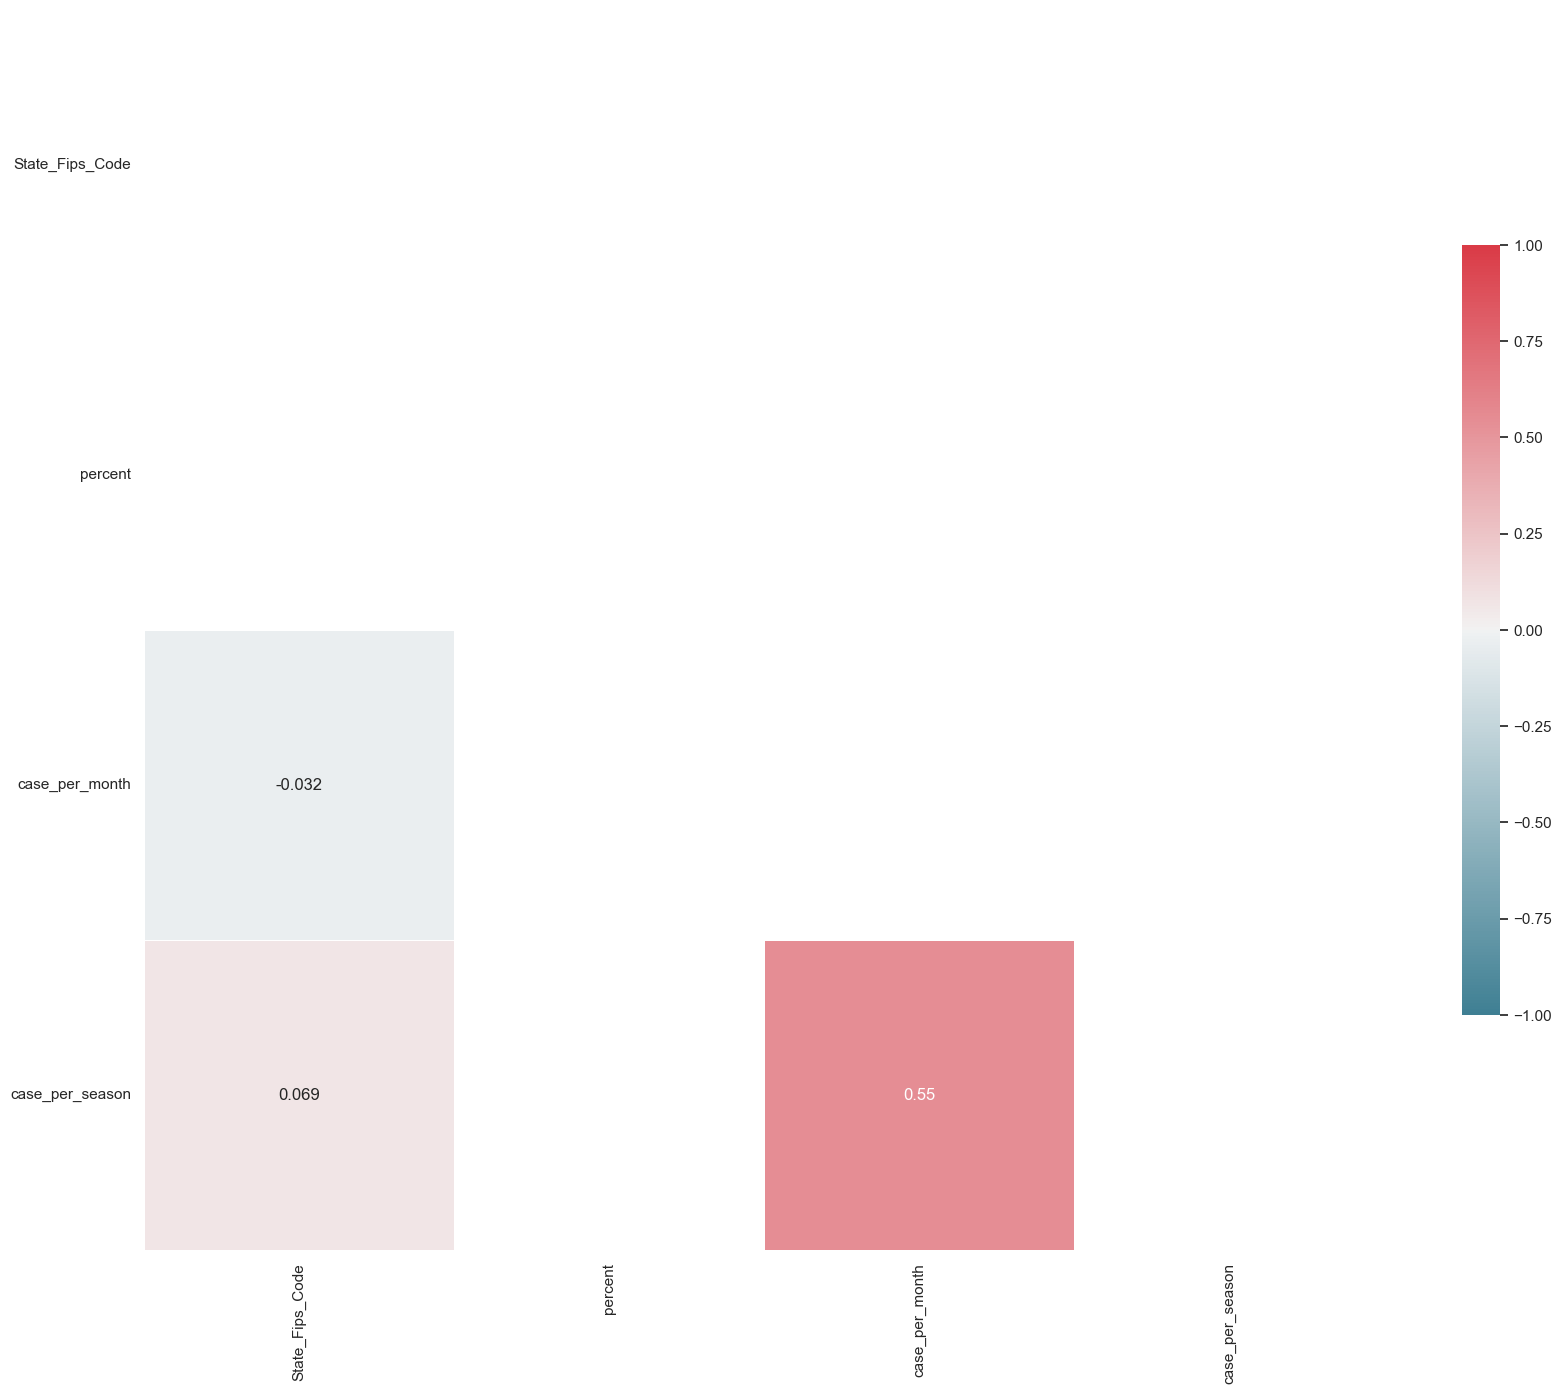

In [1635]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
continuous_columns = ['State_Fips_Code', 'percent', 'case_per_month', 'case_per_season']
corr = X_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)  # Use bool instead of np.bool
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

#### Interpretation of the results

* Strong correlations:
    * case_per_month: As there is a time based trend for the number of cases in a month and the number of cases in a day, it is to be expected that these will be strongly correlated with the time since the start as this is essentially just numerically representing the datetime.
* Weak correlations:
    * State_Fips_Code: This does not have any strong correlations. We will check this feature against the target feature later and if no strong correlation it will be removed. Not expected to have a strong correlation with residential codes. 
<br>
<br>
<b> Current status : Split all into individual correlation lists </b>

### 1.2.2 Plot interactions with between the continuous features and target features

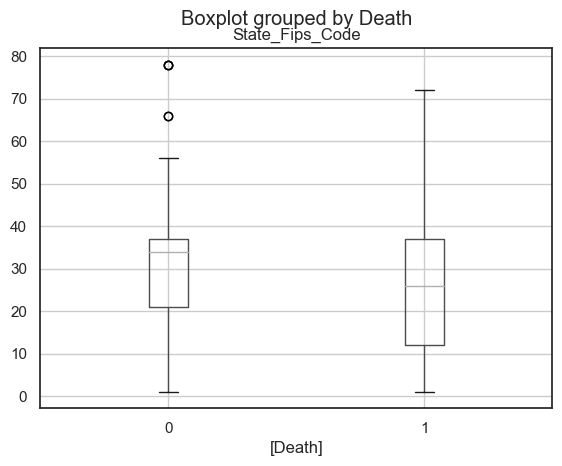

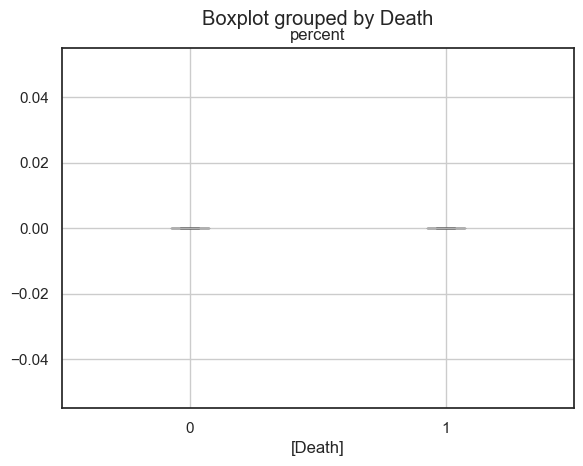

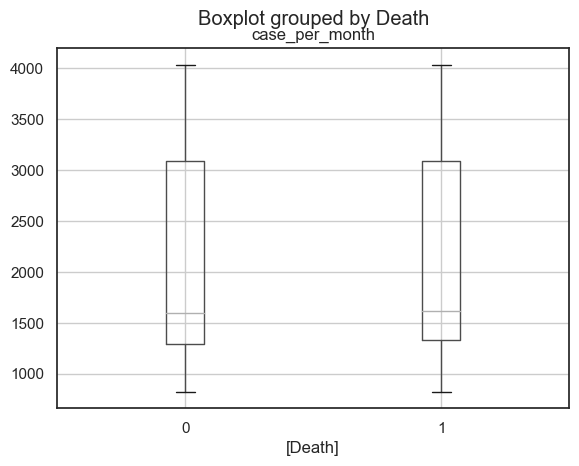

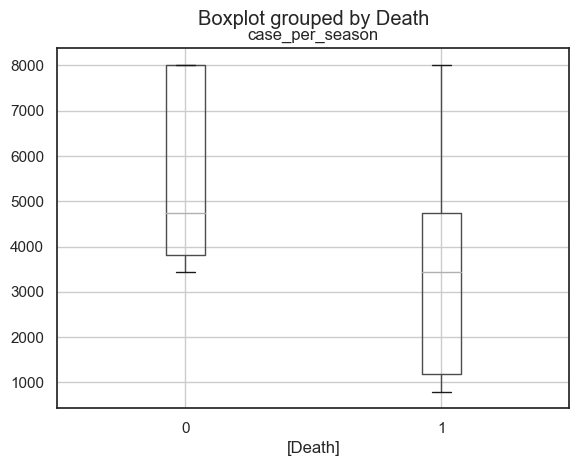

In [1636]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_columns]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], Y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "Death"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.boxplot(by="Death")
    # add correlation to dict
    corr_dict[column] = correlation

In [1637]:
# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Death']).sort_values('Death', ascending=False)
corr_df

Death
case_per_month   0.021240
State_Fips_Code -0.187201
case_per_season -0.425224
percent               NaN

Checking for standard deviation for above correlations 

In [1638]:
print(X_train['percent'].unique())
print(X_train['case_per_season'].unique())
print(X_train['percent'].std())
print(X_train['case_per_season'].std())

[ 0. nan]
[  nan 1994. 4739. 8020. 1041. 3428. 1175. 3813.  790.]
0.0
2460.358045865925


In [1639]:
X_train['case_per_season'].fillna(X_train['case_per_season'].mean(), inplace=True)

(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, 'case_per_month'),
  Text(1.5, 0, 'case_per_season'),
  Text(2.5, 0, 'percent')])

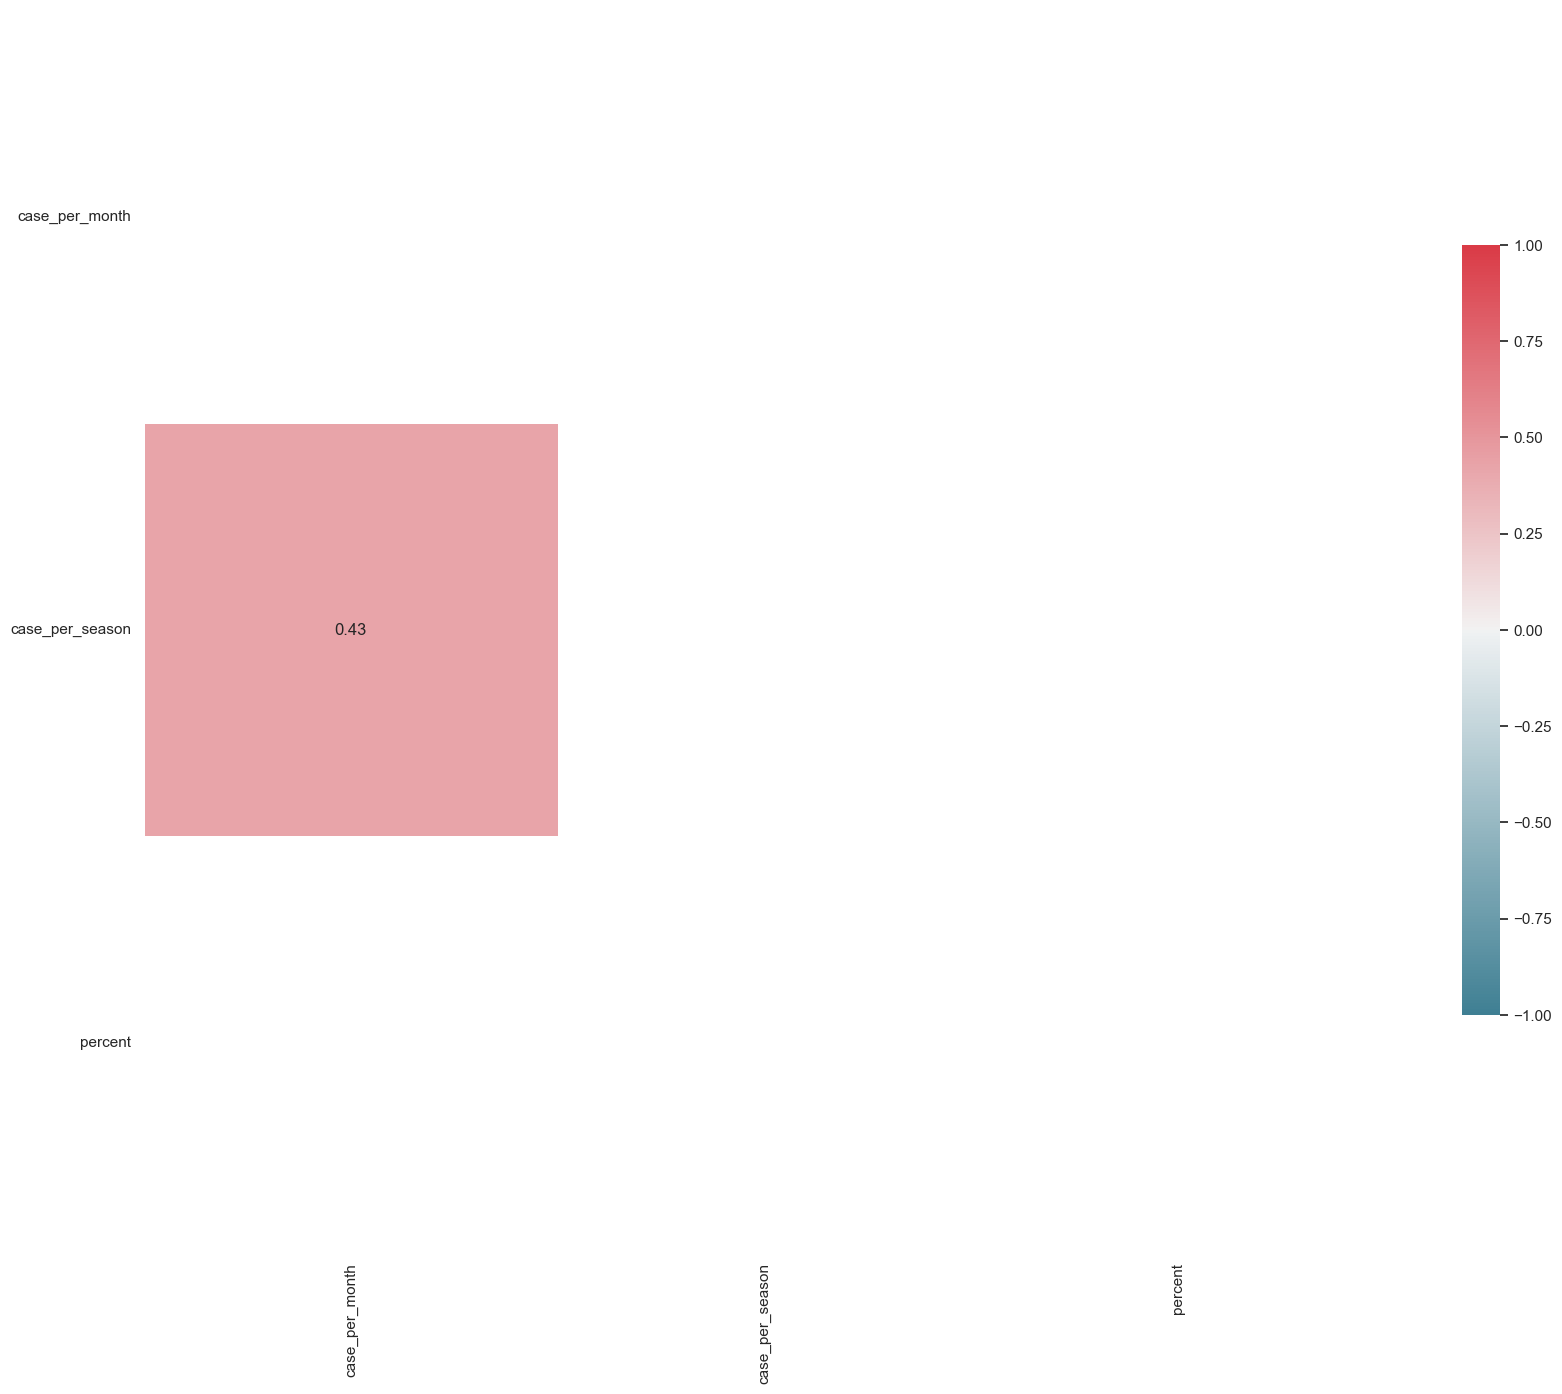

In [1640]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
continuous_columns = (X_train.select_dtypes(include=np.number).columns.tolist())[1:]
corr = X_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

In [1641]:
# Calculate the pairwise correlations between 'case_per_season' and other continuous features
for col in continuous_columns:
    if col != 'case_per_season':
        correlation = X_train['case_per_season'].corr(X_train[col])
        print(f"Correlation between case_per_season and {col}: {correlation}")

Correlation between case_per_season and case_per_month: 0.4280282334246263
Correlation between case_per_season and percent: nan


In [1642]:
print("Number of missing values in the 'percent' column:", X_train['percent'].isna().sum())
print("Unique values in the 'percent' column:", X_train['percent'].unique())

Number of missing values in the 'percent' column: 13982
Unique values in the 'percent' column: [ 0. nan]


### Interpretation of the results 
* After running numerous tests to verify the correlation between continuous features within the dataset, it's evident that 'percent' and 'case_per_season' have no correlation with the target feature 'Death'


* Observing the plots, visually there are no clearly defined correlations and this is probably to be expected with a complex problem like this. There are many interactions to take into account. Reviewing the sorted correlation dataframe we get a better overview of all the correlations. We will breakdown the correlation values into 3 bins for purposes of interpretation taking only their absolute value into account Note: The bounds for each bin are arbitrary and for the purpose of splitting up the features only. 

|                   | Low correlation | Medium correlation | High correlation |
|-------------------|-----------------|--------------------|------------------|
|                   | x <= 0.01       |  0.01 < x < 0.07   | x >= 0.7         |
|                   | 1 feature       | 1 feature          | 3 features       |
|                   | 20%             | 20%                | 60%              |


* The strongest correlation is: <br> 
    * State_Fips_Code: This is strongly correlated but has no impact on the actual correlation representation. This column just has a heavy dependency on numeric value and is correlated incorrectly.
* Medium correlation: 
    * case_per_month: This makes sense as the more cases there are in a certain day will lead to more deaths in that day <br>
* No correlation: <br>
    * case_per_season: This feature has a very low correlation to the target feature and we can safely drop this.
    * percent: This feature has a very low correlation to the target feature and we can safely drop this.

In [1643]:
# generate list of features for low correlation bin
low_correlation_features = []
for key, value in corr_dict.items():
    if value < 0.01 and value > -0.01:
        low_correlation_features.append(key)
low_correlation_features

[]

In [1644]:
# generate list of features for middle correlation bin
middle_correlation_features = []
for key, value in corr_dict.items():
    if 0.01 < abs(value) < 0.07:
        middle_correlation_features.append(key)
middle_correlation_features

['case_per_month']

In [1645]:
# generate list of features for high correlation bin
high_correlation_features = []
for key, value in corr_dict.items():
    if value > 0.07 or value < -0.07:
        high_correlation_features.append(key)
high_correlation_features

['State_Fips_Code', 'case_per_season']

In [1646]:
# generate list of features for no correlation (NaN) bin
no_correlation_features = []
for key, value in corr_dict.items():
    if math.isnan(value):
        no_correlation_features.append(key)
no_correlation_features

['percent']

### 1.2.3 Plot interaction between categorical features and target feature

* Here we will plot a pairwise interaction between each categorical feature against the target feature.
* We will discuss what we observe from these plots, e.g., which categorical features seem to be better at predicting the target feature...
* We will choose a subset of categorical features we find promising (if any) and justify our choice. <br>
Here we have 13 categorical features

Current_Status, Sex, Age_Group, Race, Ethnicity Hospital, ICU, Case_Month, Symptom_Status, Underlying_Conditions, Season, Death, at_risk, old_aged <br>
A stacked bar plot for each will be created.

In [1647]:
X_Y_train = pd.concat([X_train, Y_train], axis=1)

In [1648]:
# Values taken by each categorical feature, as a proportion and counts
for column in categorical_columns:
    #print("\n" + color.BOLD + column + color.END)
    count = 0
    t = PrettyTable(['Value', 'Proportion', 'Count'])
    for value in X_Y_train[column].unique():
        try:
            key = X_Y_train[column].value_counts(normalize=True).keys().tolist()[count]
            proportion_val = X_Y_train[column].value_counts(normalize=True).tolist()[count]
            count_val = X_Y_train[column].value_counts().tolist()[count]
            t.add_row([key, proportion_val, count_val])
            count += 1
        except:
            pass
    print(t)

+-----------+---------------------+-------+
|   Value   |      Proportion     | Count |
+-----------+---------------------+-------+
|  January  | 0.20089285714285715 |  5625 |
|  December | 0.15517857142857142 |  4345 |
|  November | 0.10439285714285715 |  2923 |
|   August  | 0.07946428571428571 |  2225 |
|   April   |       0.07125       |  1995 |
| September | 0.06707142857142857 |  1878 |
|  October  | 0.06667857142857143 |  1867 |
|    July   | 0.06521428571428571 |  1826 |
|    May    | 0.05739285714285714 |  1607 |
|  February | 0.04592857142857143 |  1286 |
|    June   | 0.04353571428571429 |  1219 |
|   March   |        0.043        |  1204 |
+-----------+---------------------+-------+
+-------+------------------------+-------+
| Value |       Proportion       | Count |
+-------+------------------------+-------+
|   NY  |  0.11210714285714286   |  3139 |
|   NC  |  0.08953571428571429   |  2507 |
|   NJ  |  0.08667857142857142   |  2427 |
|   FL  |  0.07721428571428571   |  21


 Case_Month
Index 	 Count
July 	 1826
January 	 5625
November 	 2923
February 	 1286
December 	 4345
October 	 1867
September 	 1878
April 	 1995
May 	 1607
March 	 1204
August 	 2225
June 	 1219

 Res_State
Index 	 Count
FL 	 2162
NY 	 3139
DC 	 104
KY 	 917
KS 	 694
OR 	 358
NJ 	 2427
NC 	 2507
AZ 	 703
TX 	 1537
TN 	 341
MD 	 972
NV 	 391
IN 	 1517
OH 	 1556
CA 	 1081
MN 	 1344
AR 	 219
AL 	 158
VT 	 38
UT 	 335
WY 	 38
MI 	 711
CT 	 95
PA 	 578
MT 	 149
ID 	 236
IL 	 391
MA 	 335
SC 	 429
VA 	 556
WI 	 449
OK 	 303
RI 	 169
CO 	 210
IA 	 75
ME 	 223
NH 	 116
PR 	 64
ND 	 19
NM 	 42
WA 	 71
MS 	 37
GA 	 23
MO 	 131
LA 	 36
AK 	 9
VI 	 3
GU 	 2

 Age_Group
Index 	 Count
50 to 64 years 	 4532
18 to 49 years 	 10899
65+ years 	 8679
0 - 17 years 	 3657
nan 	 0
Missing 	 25
Unknown 	 30

 Sex
Index 	 Count
Female 	 14181
Male 	 13136
nan 	 0
Unknown 	 127
Missing 	 11

 Race
Index 	 Count
White 	 17411
Black 	 2956
Unknown 	 2941
nan 	 0
Asian 	 640
American Indian/Alaska Native 	 99
M

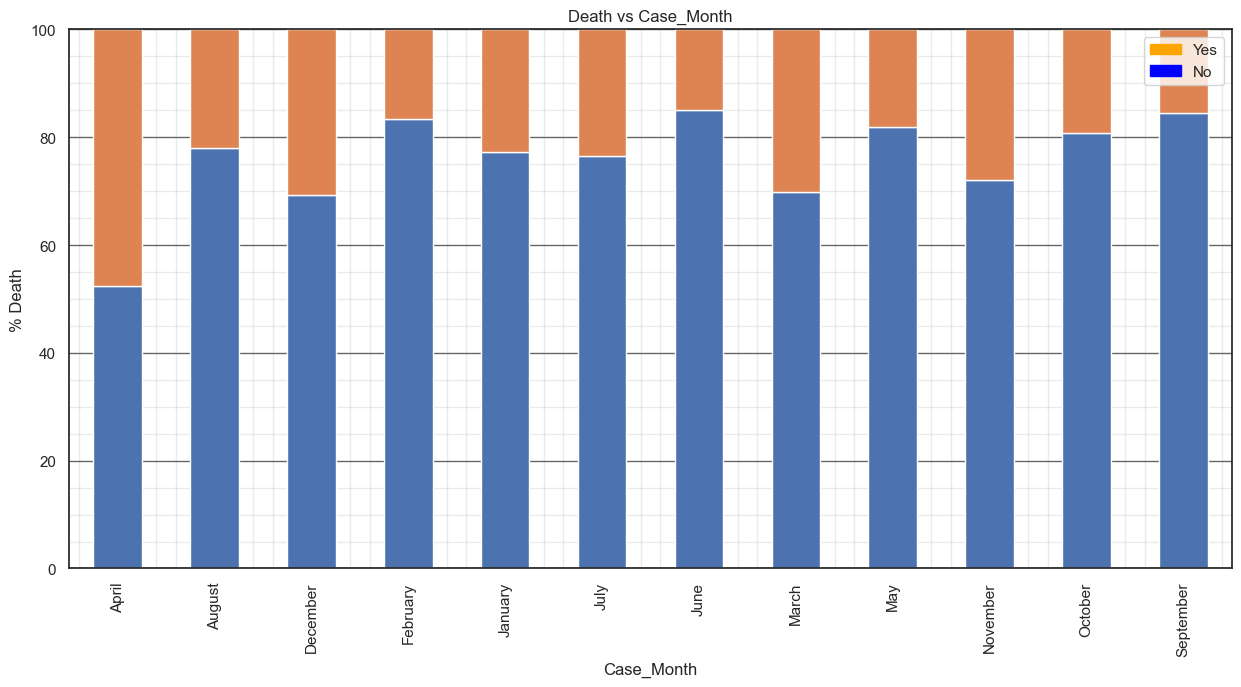

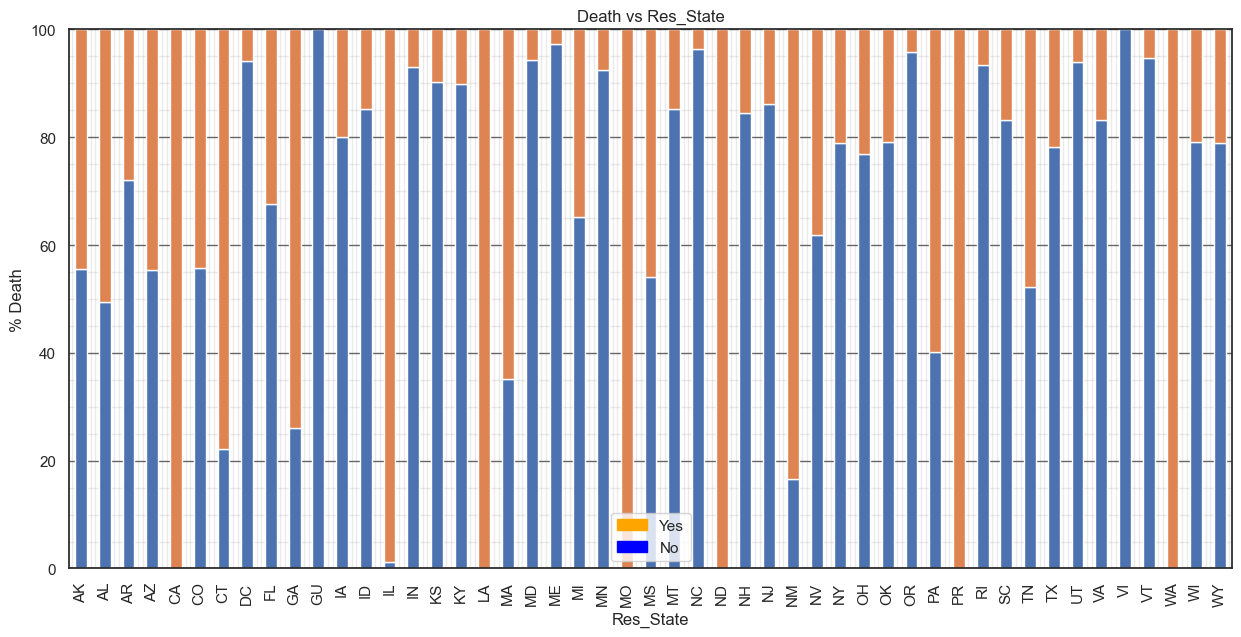

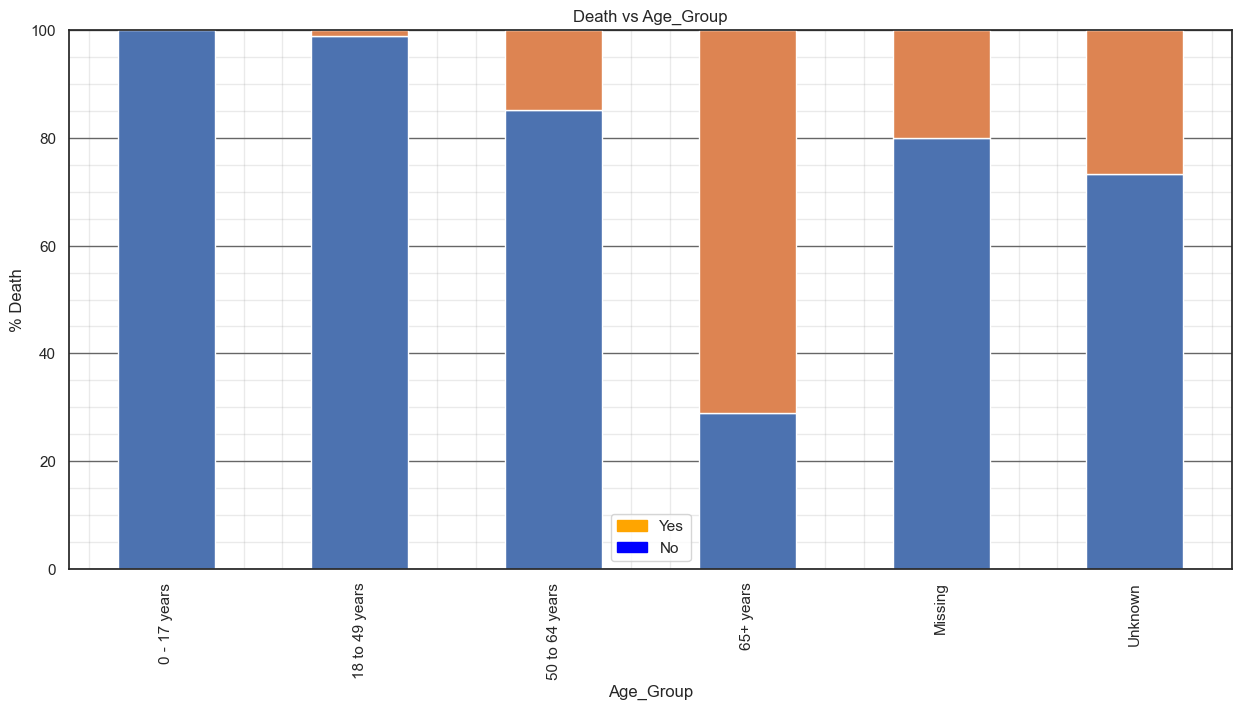

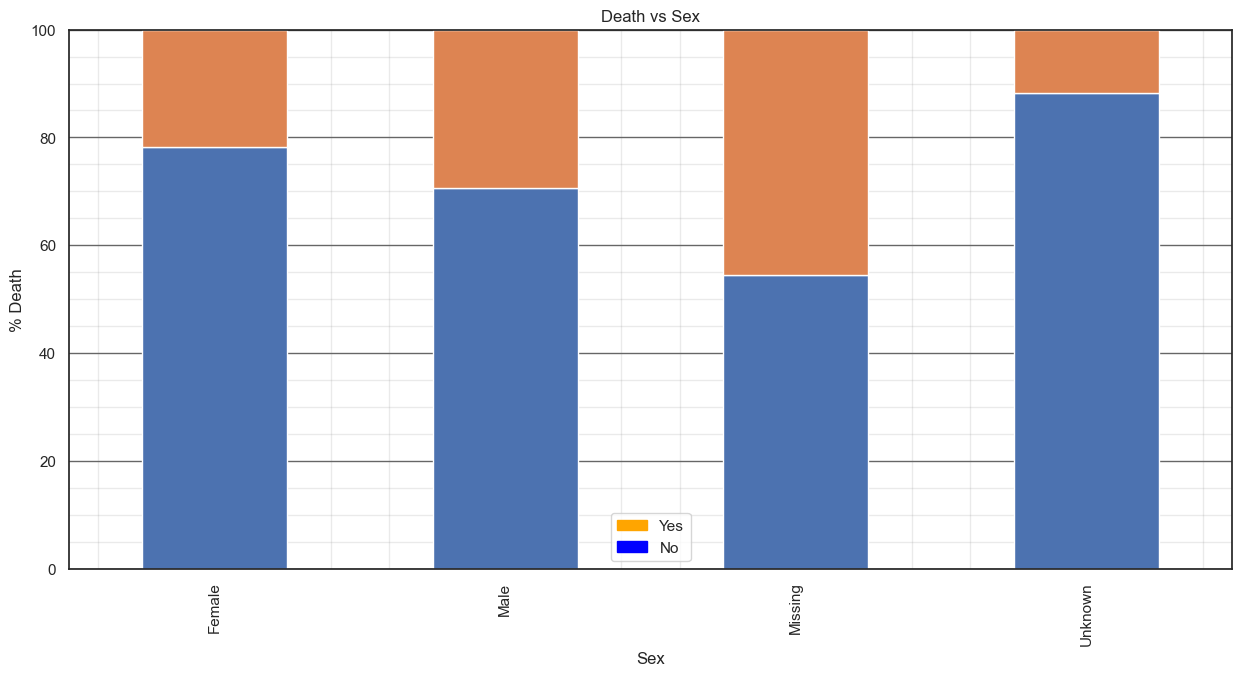

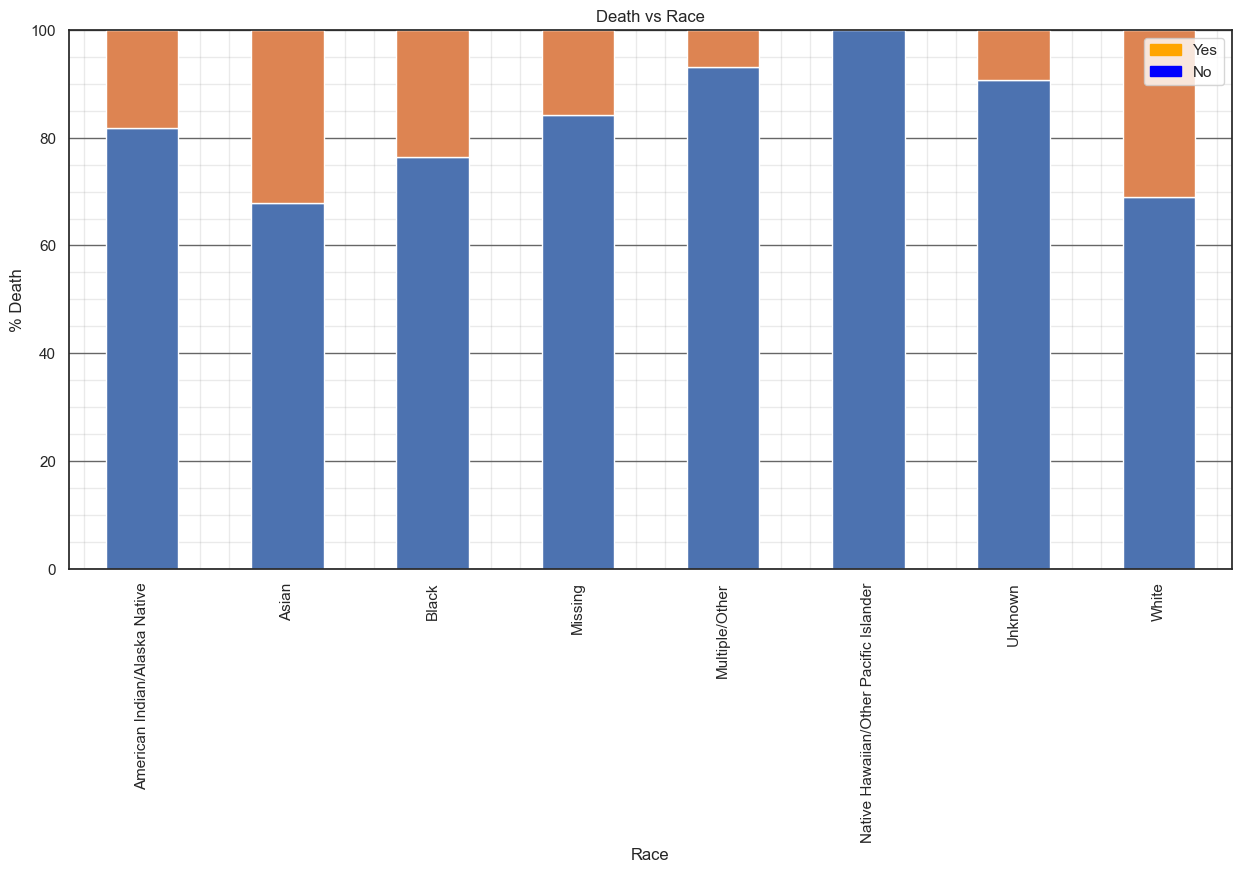

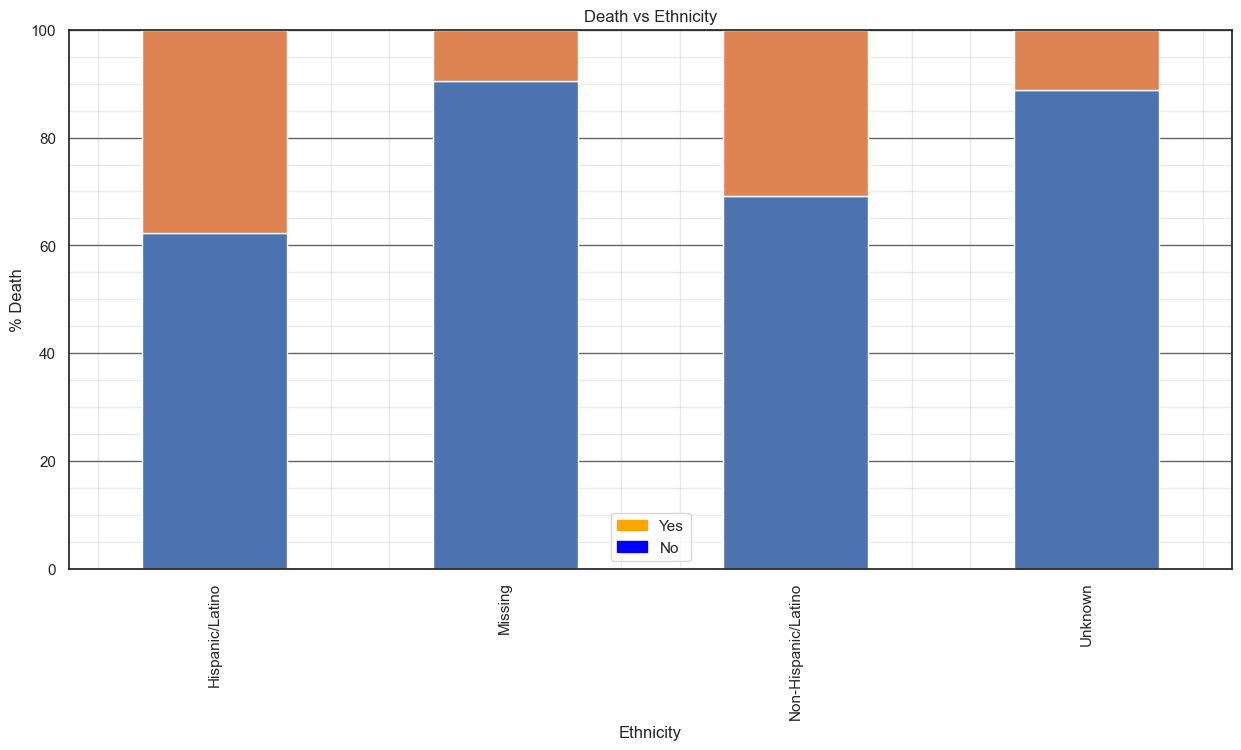

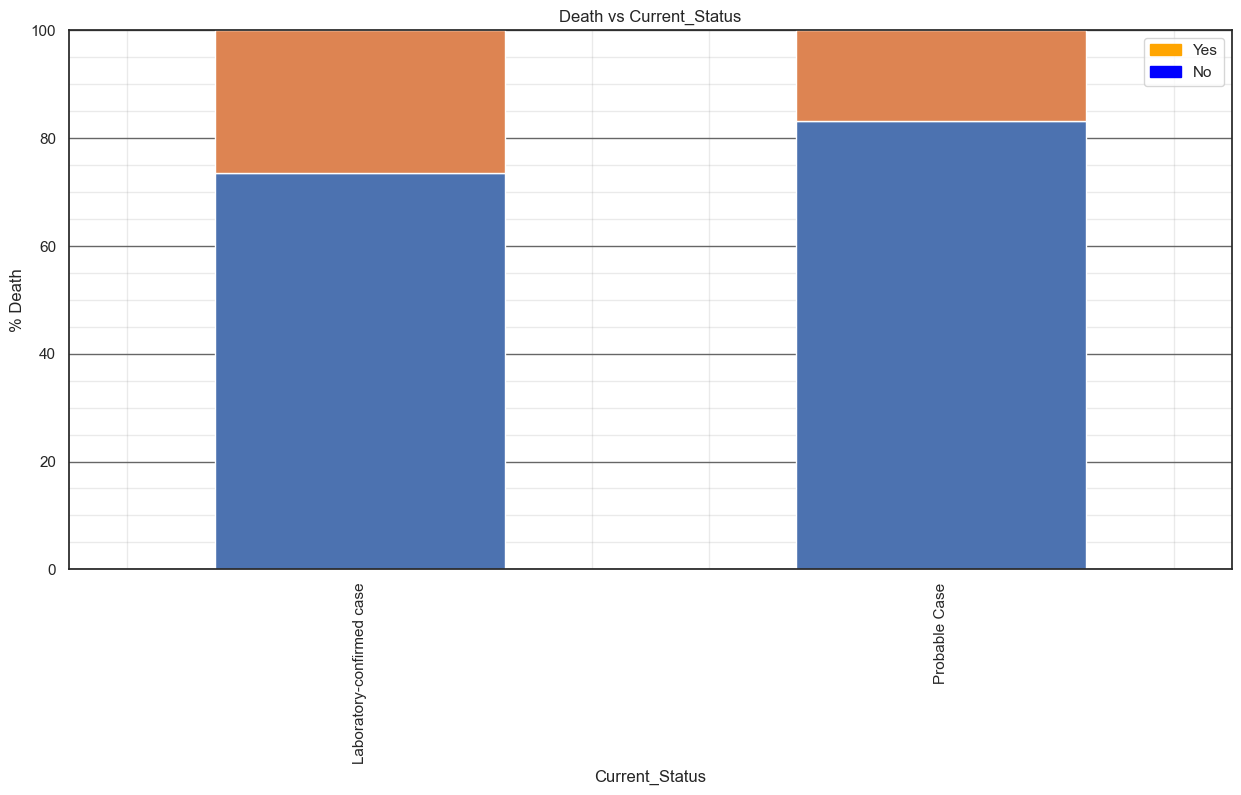

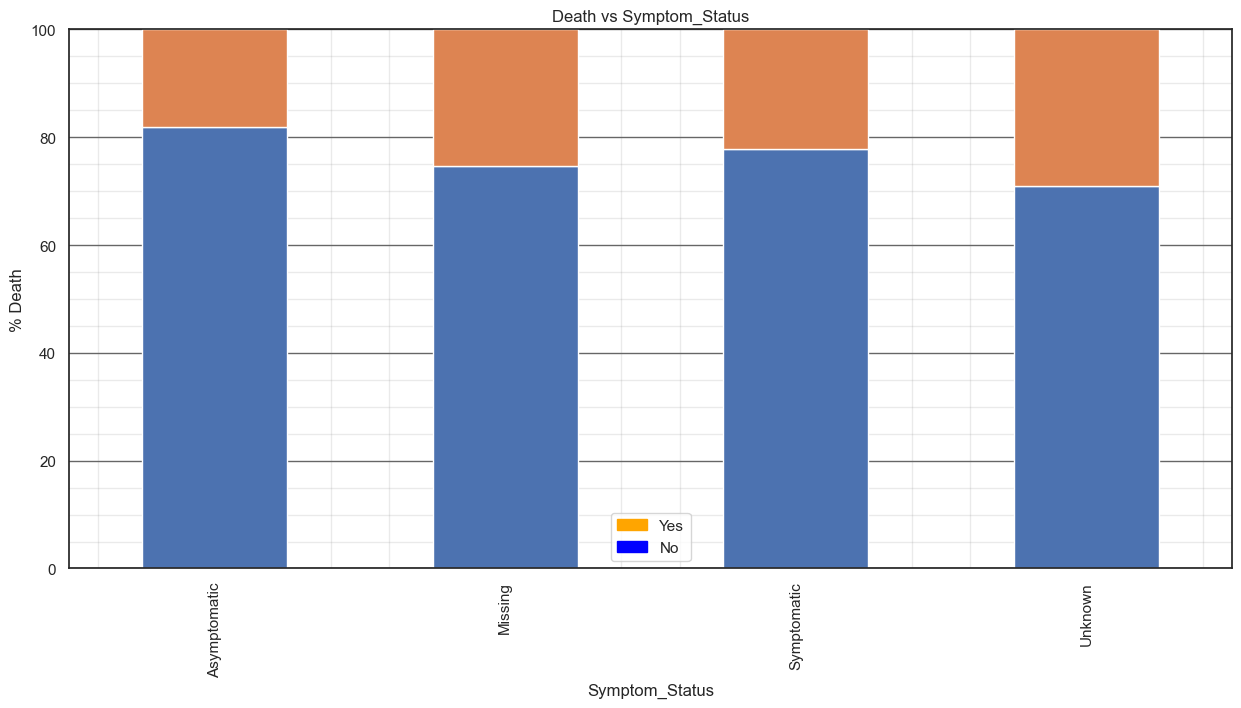

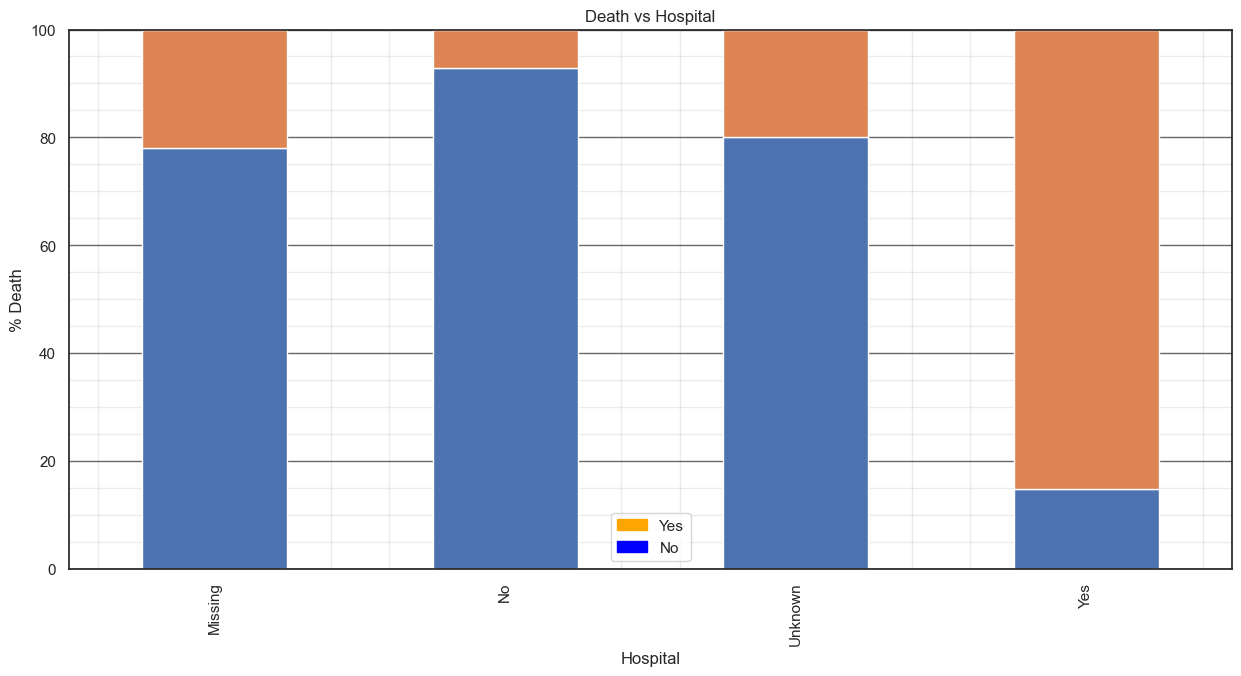

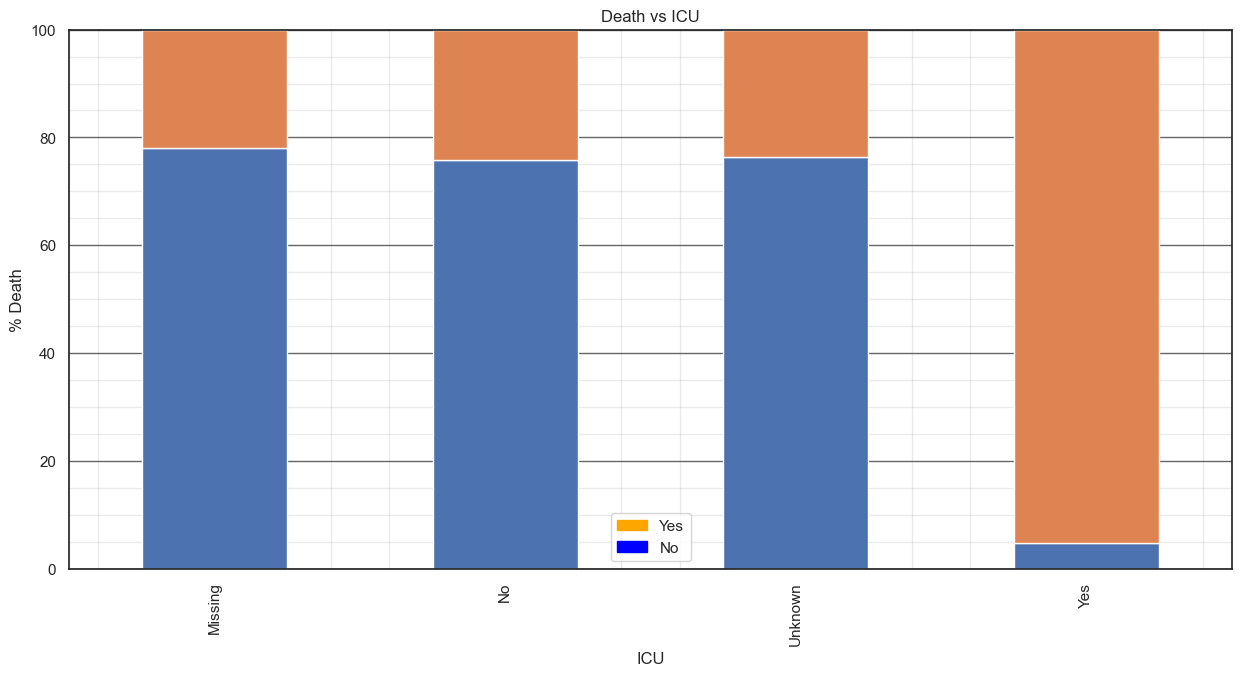

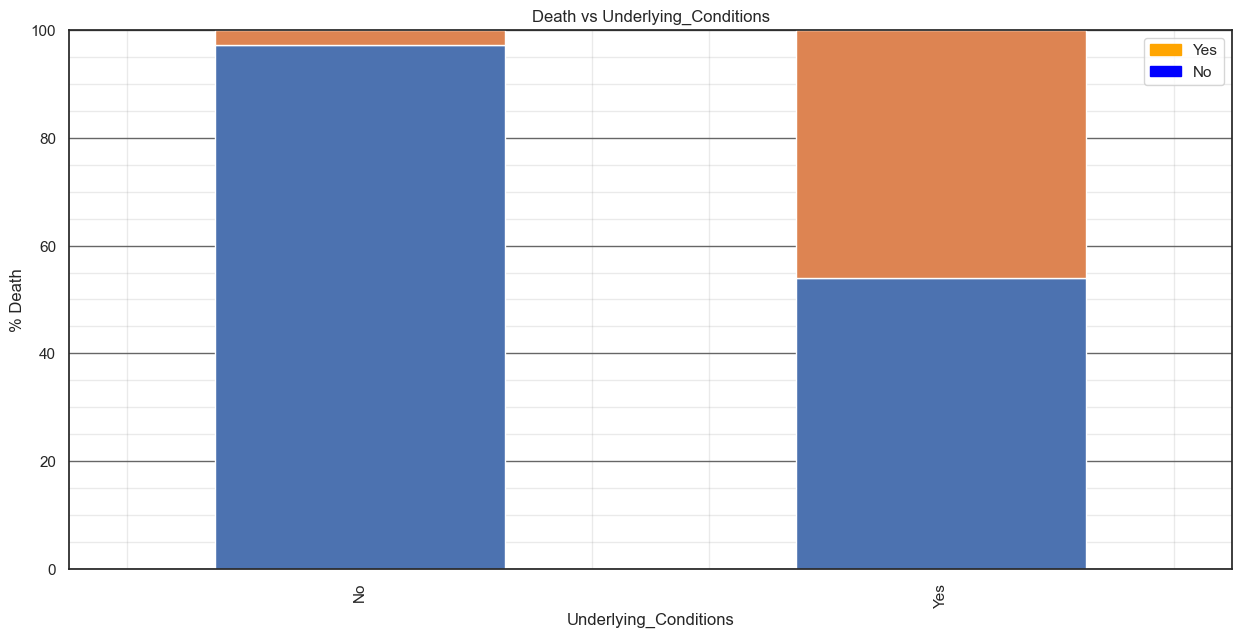

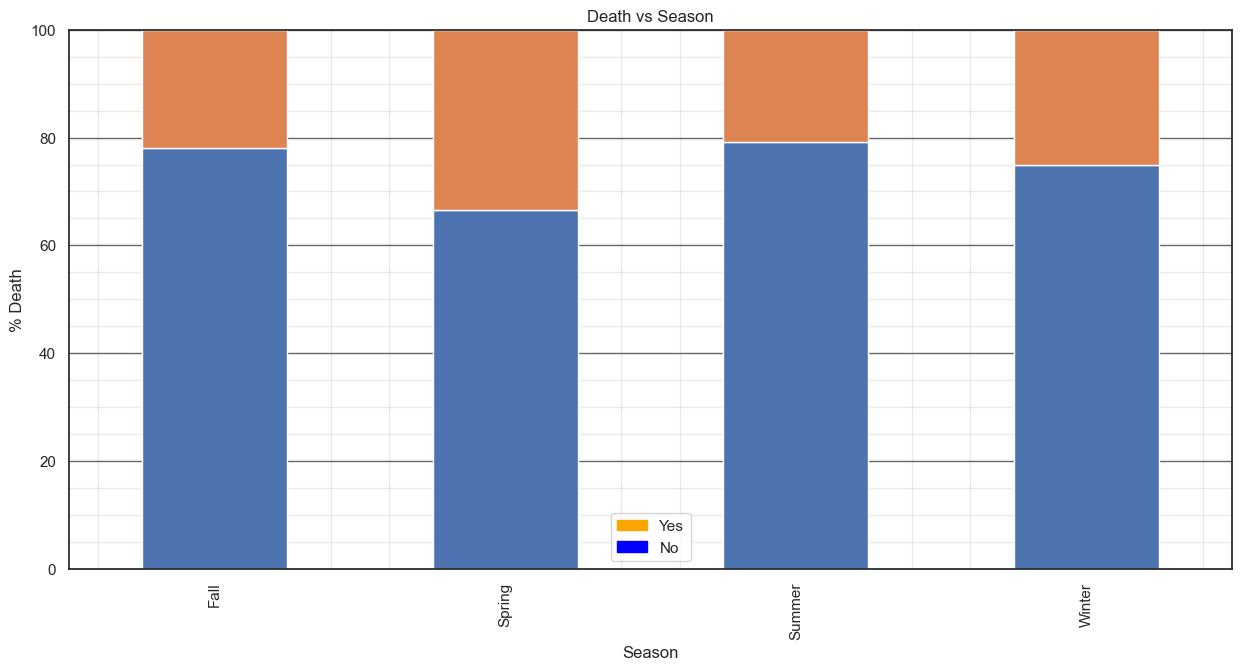

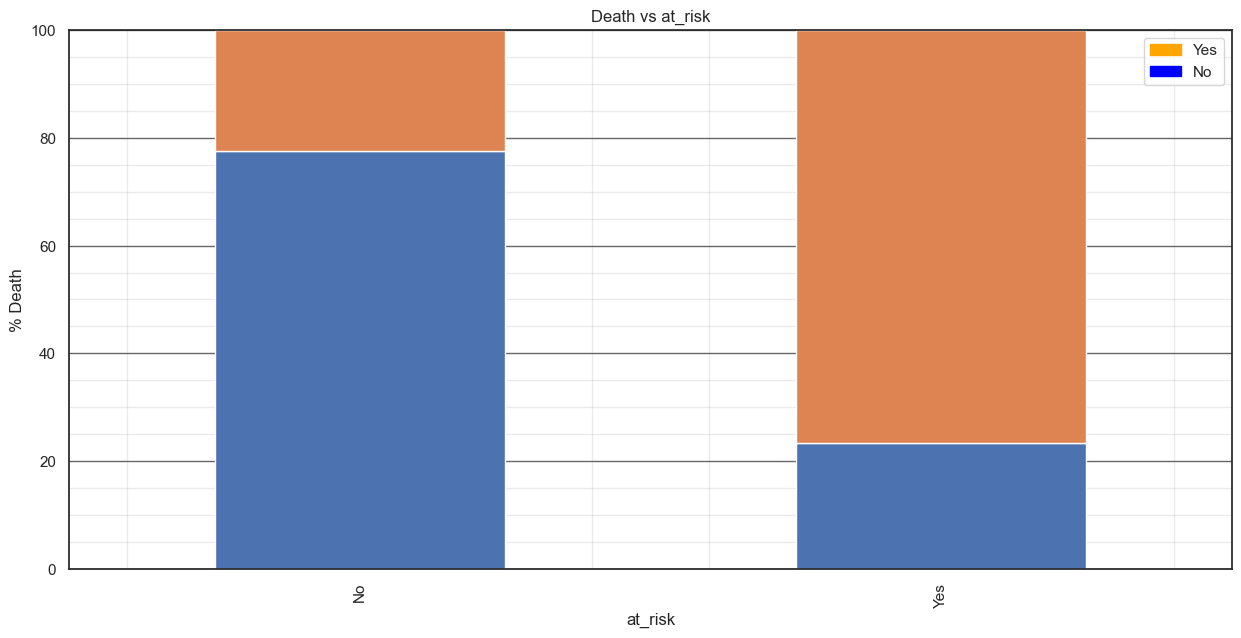

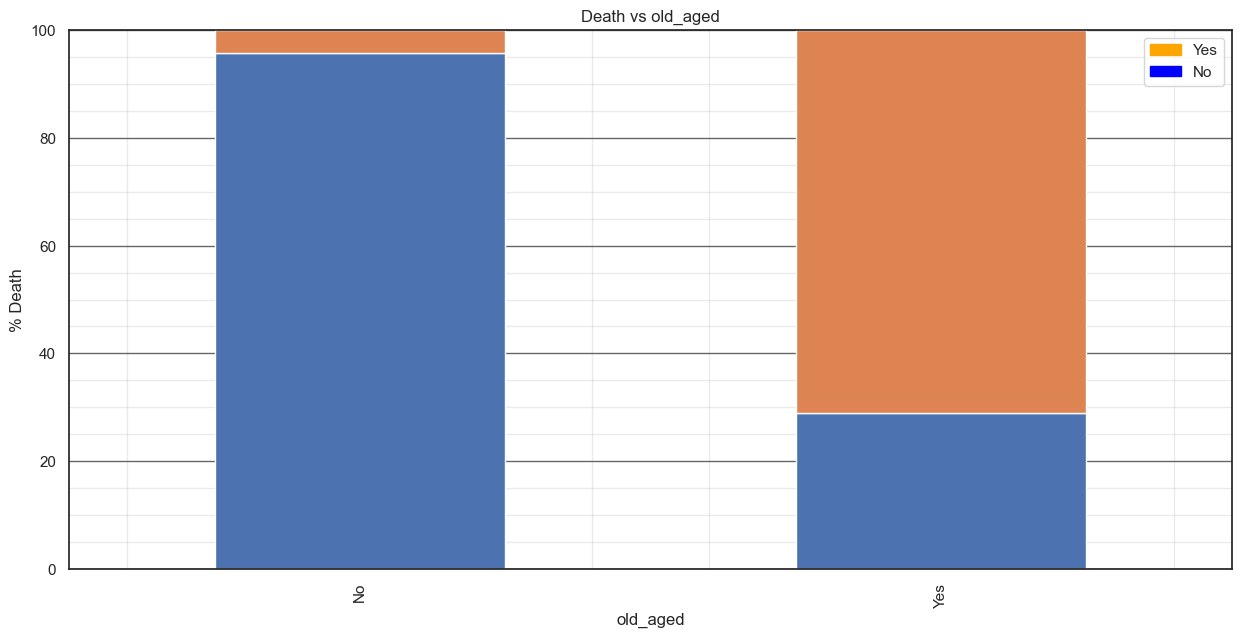

In [1649]:
# for the comparison we will convert the target back to categorical
Y_train = Y_train.astype("category")
#X_train[categorical_columns].columns

# we will create temp dataframe for these plots, merging X_train and y_train
df_temp= pd.concat([X_train, Y_train], axis=1)

# for each categorical feature create a stacked bar plot
for categorical_feature in categorical_columns:
    if categorical_feature != 'Res_County':
        try:
            # Using code from the module lab

            maxDelqEver = pd.unique(df_temp[categorical_feature].ravel())

            # add new column and set values to zero
            df_temp['percent'] = 0

            #print header
            print("\n", categorical_feature)
            print("Index \t Count")

            # for each delinquency category
            for i in maxDelqEver:
                count = df_temp[df_temp[categorical_feature] == i].count()['Death']
                if count != 0:
                    count_percentage = (1 / count) * 100
                else:
                    count_percentage = 0

                # print out index vs count
                print(i, "\t", count)

                index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
                for ind in index_list:
                    df_temp.loc[ind, 'percent'] = count_percentage

            group = df_temp[['percent',categorical_feature,'Death']].groupby([categorical_feature,'Death']).sum().reset_index()

            my_plot = group.pivot(index=categorical_feature, columns='Death', values='percent').plot(kind='bar', stacked=True, title=f"Death vs {categorical_feature}", figsize=(15,7), grid=True)

            # add legend
            red_patch = mpatches.Patch(color='orange', label='Yes')
            blue_patch = mpatches.Patch(color='blue', label='No')
            my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

            # add gridlines
            plt.grid(visible=True, which='major', color='#666666', linestyle='-')
            plt.minorticks_on()
            plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

            # add labels
            my_plot.set_xlabel(f"{categorical_feature}")
            my_plot.set_ylabel("% Death")
            my_plot.set_ylim([0,100])
        except Exception as e:
            print(f"Error while plotting {categorical_feature}: {e}")

# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop(labels="percent", axis=1)

Interpretation of the results

<b> Death vs Case_Month

Observing the plots we can see a medium correlation with Death per each month. Autumn seasons showing the least correlation but this was to be expected. 
We may revisit this feature in Part 5.

<b> Death vs Current_Status

Observing the plots we can see both Laboratory-confirmed case and Probable case have very little effect on the target outcome
Both show about 5% death=Yes values
Because of this it is necessary to drop this feature
    
<b> Death vs Sex

Observing the plots for sex it is hard to know if this will have much effect on the target outcome.
The proportion of deaths for male and female both lie around 5%, while for unknown values it seems like there are no deaths.
Because of the very low correlation with the target outcome it is necessary to drop this feature.
    
<b> Death vs Age_Group

Observing the plots here we see a clear trend between older age groups and the target outcome.
Up to age 50 there are very few deaths and we start seeing the trend grow as age gets older.
This column is clearly very valuable to the target outcome and will therefore be kept.
I would suggest ordinal encoding for this variable rather than one-hot also.
    
<b> Death vs Race

We see slight variations of the proportion that died based on their ethnicity but they never reach any higher than 10% death.
I will choose to drop this feature for now as it is not strongly correlated with the target outcome.
Because of the very low correlation with the target outcome it is necessary to drop this feature.
    
<b> Death vs Res_State

Feature causes severe run time errors through predictions due to the vast range of individual values. No immediate correlation with the target feature Death.
Because of the very low correlation with the target outcome it is necessary to drop this feature.
    
<b> Death vs Ethnicity

We see slight variations of the proportion that died based on their ethnicity but they never reach any higher than 10% death.
I will choose to drop this feature for now as it is not strongly correlated with the target outcome.
    
<b> Death vs Hospital

Observing the plot here we see a clear relation between hospitalisation and death. This is to be expected as cases that are hospitalised are more likely to be severe and therefore more likely to die.
We will keep this feature for modelling.
    
<b> Death vs ICU

Observing the plot for this feature, it represents a similar trend to hosp_yn, although it is a much stronger predictor.
Over 50% of cases that were in the ICU died.
This is a very strong predictor of the target outcome and will therefore be kept for modelling.
    
<b> Death vs at_risk

Observing the plot, we see that the at_risk members are much more likely to die than the not at_risk.
This is to be expected as the at_risk feature is based on features which would make the case have a higher risk of death.
We will be keeping this feature.
    
<b> Death vs old_aged

Observing the plot here, we see that old_aged is highly correlated with the target outcome and we will be keeping this feature for that reason.

In [1650]:
categorical_dropped = ["Res_State",
"Sex",
"Race",
"Current_Status",
"Ethnicity",
"Res_County"]

In [1651]:
categorical_columns = [
    'Case_Month', 'Res_State', 'Res_County', 'Age_Group', 'Sex', 'Race', 'Ethnicity', 'Current_Status',
    'Symptom_Status', 'Hospital', 'ICU', 'Underlying_Conditions', 'Season', 'at_risk', 'old_aged'
]

continuous_columns = [
    'State_Fips_Code', 'percent', 'case_per_month', 'case_per_season'
]

# Perform one-hot encoding on the categorical features
X_Y_train_dummies = pd.get_dummies(X_Y_train, columns=categorical_columns)

# Combine the continuous and one-hot encoded categorical columns
all_columns_dummies = continuous_columns + X_Y_train_dummies.columns.tolist()

# Calculate the correlation between all features and the target variable "Death"
corr_dict = {}

for column in X_Y_train_dummies[all_columns_dummies]:
    if column != "Death":
        df_temp = X_Y_train_dummies[[column, "Death"]]
        correlation = df_temp[[column, "Death"]].corr().values[0, 1]
        corr_dict[column] = correlation

corr_categ_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Death']).sort_values('Death', ascending=False)

In [1652]:
corr_categ_df.head(10)

Death
old_aged_Yes                   0.713674
Age_Group_65+ years            0.713674
Hospital_Yes                   0.631532
Res_State_CA                   0.347257
ICU_Yes                        0.272000
at_risk_Yes                    0.265957
Res_County_LOS ANGELES         0.231270
Res_State_IL                   0.202705
Race_White                     0.180732
Ethnicity_Non-Hispanic/Latino  0.164804

In [1653]:
corr_categ_df.tail(10)

Death
Res_County_SOLANO           NaN
Res_County_STAUNTON CITY    NaN
Res_County_SUWANNEE         NaN
Res_County_TERREBONNE       NaN
Res_County_TREMPEALEAU      NaN
Res_County_UINTAH           NaN
Res_County_VALENCIA         NaN
Res_County_VERMILION        NaN
Res_County_WHATCOM          NaN
Res_County_WILLACY          NaN

### Summary and Drop Features

In [1654]:
no_correlation_features

['percent']

In [1655]:
categorical_dropped

['Res_State', 'Sex', 'Race', 'Current_Status', 'Ethnicity', 'Res_County']

In [1656]:
# drop all low correlation features
low_value_features = list(set(no_correlation_features + categorical_dropped))
# before dropping, make a copy of the original
df_rev1 = df.copy()
# drop low value features
df_rev1.drop(labels=low_value_features, axis=1, inplace=True)
print('\nRemaining columns:', df_rev1.columns)
print('\nNew shape:', df_rev1.shape)


Remaining columns: Index(['Case_Month', 'State_Fips_Code', 'Age_Group', 'Symptom_Status',
       'Hospital', 'ICU', 'Death', 'Underlying_Conditions', 'at_risk',
       'old_aged', 'Season', 'case_per_month', 'case_per_season'],
      dtype='object')

New shape: (40000, 13)


## 1.3 Prepare dataset for modeling

Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling <br>

* We will now convert the categorical variables into dummies variable to allow modeling
* We will then remove the redundant dummies which contain no additional information
* We will then set up the train test split again based on the dataset with the dummies included

In [1657]:
df_rev1.Case_Month

0         January
14350    December
15593     January
9216     February
17398     January
           ...   
34557    February
15629      August
20177    December
34186    November
11336        July
Name: Case_Month, Length: 40000, dtype: category
Categories (12, object): ['April', 'August', 'December', 'February', ..., 'May', 'November', 'October', 'September']

In [1658]:
# ordinal encoding of the months
month_dict = dict((v,k) for k,v in enumerate(calendar.month_name))
month_dict = {"Case_Month": month_dict}

df_rev1 = df_rev1.replace(month_dict)
df_rev1

Case_Month  State_Fips_Code       Age_Group Symptom_Status Hospital   
0              1             12.0       65+ years        Missing  Missing  \
14350         12             36.0  18 to 49 years    Symptomatic       No   
15593          1             37.0  50 to 64 years        Unknown  Unknown   
9216           2             37.0  50 to 64 years        Unknown  Unknown   
17398          1             48.0  18 to 49 years        Missing       No   
...          ...              ...             ...            ...      ...   
34557          2             37.0  18 to 49 years        Unknown  Unknown   
15629          8             18.0    0 - 17 years        Missing       No   
20177         12             25.0       65+ years        Unknown      Yes   
34186         11             18.0  18 to 49 years        Unknown       No   
11336          7             48.0  18 to 49 years        Missing       No   

           ICU  Death Underlying_Conditions at_risk old_aged  Season   
0      Missing      1                   NaN      No      Yes  Winter  \
14350  Missing      0                   NaN      No       No  Winter   
15593  Unknown      0                   NaN      No       No  Winter   
9216   Unknown      0                   NaN      No       No  Winter   
17398  Missing      0                   NaN      No       No  Winter   
...        ...    ...                   ...     ...      ...     ...   
34557  Unknown      0                   NaN      No       No  Winter   
15629  Missing      0                   NaN      No       No  Summer   
20177  Unknown      1                   NaN      No      Yes  Winter   
34186  Unknown      0                   NaN      No       No    Fall   
11336  Missing      0                   NaN      No       No  Summer   

       case_per_month  case_per_season  
0                4033           8020.0  
14350            3070           8020.0  
15593            4033           8020.0  
9216              917           8020.0  
17398            4033           8020.0  
...               ...              ...  
34557             883              NaN  
15629            1612           3813.0  
20177            3090           1994.0  
34186            2051              NaN  
11336            1378           3813.0  

[40000 rows x 13 columns]

In [1659]:
# ordinal encoding of the age_groups
age_groups = [x for x in df.Age_Group.unique().tolist() if isinstance(x, str)]
age_groups = sorted(age_groups)[:-1]
age_groups.insert(0, "Unknown")

age_dict = dict((v, k) for k, v in enumerate(age_groups))

df_rev1 = df_rev1.replace(age_dict)
df_rev1

Case_Month  State_Fips_Code Age_Group Symptom_Status Hospital ICU   
0              1             12.0         4              5        5   5  \
14350         12             36.0         2    Symptomatic       No   5   
15593          1             37.0         3              0        0   0   
9216           2             37.0         3              0        0   0   
17398          1             48.0         2              5       No   5   
...          ...              ...       ...            ...      ...  ..   
34557          2             37.0         2              0        0   0   
15629          8             18.0         1              5       No   5   
20177         12             25.0         4              0      Yes   0   
34186         11             18.0         2              0       No   0   
11336          7             48.0         2              5       No   5   

       Death Underlying_Conditions at_risk old_aged  Season  case_per_month   
0          1                   NaN      No      Yes  Winter            4033  \
14350      0                   NaN      No       No  Winter            3070   
15593      0                   NaN      No       No  Winter            4033   
9216       0                   NaN      No       No  Winter             917   
17398      0                   NaN      No       No  Winter            4033   
...      ...                   ...     ...      ...     ...             ...   
34557      0                   NaN      No       No  Winter             883   
15629      0                   NaN      No       No  Summer            1612   
20177      1                   NaN      No      Yes  Winter            3090   
34186      0                   NaN      No       No    Fall            2051   
11336      0                   NaN      No       No  Summer            1378   

       case_per_season  
0               8020.0  
14350           8020.0  
15593           8020.0  
9216            8020.0  
17398           8020.0  
...                ...  
34557              NaN  
15629           3813.0  
20177           1994.0  
34186              NaN  
11336           3813.0  

[40000 rows x 13 columns]

In [1660]:
df_rev1

Case_Month  State_Fips_Code Age_Group Symptom_Status Hospital ICU   
0              1             12.0         4              5        5   5  \
14350         12             36.0         2    Symptomatic       No   5   
15593          1             37.0         3              0        0   0   
9216           2             37.0         3              0        0   0   
17398          1             48.0         2              5       No   5   
...          ...              ...       ...            ...      ...  ..   
34557          2             37.0         2              0        0   0   
15629          8             18.0         1              5       No   5   
20177         12             25.0         4              0      Yes   0   
34186         11             18.0         2              0       No   0   
11336          7             48.0         2              5       No   5   

       Death Underlying_Conditions at_risk old_aged  Season  case_per_month   
0          1                   NaN      No      Yes  Winter            4033  \
14350      0                   NaN      No       No  Winter            3070   
15593      0                   NaN      No       No  Winter            4033   
9216       0                   NaN      No       No  Winter             917   
17398      0                   NaN      No       No  Winter            4033   
...      ...                   ...     ...      ...     ...             ...   
34557      0                   NaN      No       No  Winter             883   
15629      0                   NaN      No       No  Summer            1612   
20177      1                   NaN      No      Yes  Winter            3090   
34186      0                   NaN      No       No    Fall            2051   
11336      0                   NaN      No       No  Summer            1378   

       case_per_season  
0               8020.0  
14350           8020.0  
15593           8020.0  
9216            8020.0  
17398           8020.0  
...                ...  
34557              NaN  
15629           3813.0  
20177           1994.0  
34186              NaN  
11336           3813.0  

[40000 rows x 13 columns]

In [1661]:
# Convert categorical columns to 'object' data type
df_rev1['Case_Month'] = df_rev1['Case_Month'].astype('object')
df_rev1['Age_Group'] = df_rev1['Age_Group'].astype('object')

# Fill missing values in Case_Month and Age_Group columns with "Unknown"
df_rev1['Case_Month'] = df_rev1['Case_Month'].fillna("Unknown")
df_rev1['Age_Group'] = df_rev1['Age_Group'].fillna("Unknown")

# Apply one-hot encoding on the remaining categorical features
df_rev1 = pd.get_dummies(df_rev1, drop_first=True)
df_rev1.dtypes

Case_Month                      int64
State_Fips_Code               float64
Death                           int64
case_per_month                  int64
case_per_season               float64
Age_Group_1                      bool
Age_Group_2                      bool
Age_Group_3                      bool
Age_Group_4                      bool
Age_Group_5                      bool
Age_Group_Unknown                bool
Symptom_Status_5                 bool
Symptom_Status_Symptomatic       bool
Symptom_Status_0                 bool
Hospital_No                      bool
Hospital_0                       bool
Hospital_Yes                     bool
ICU_No                           bool
ICU_0                            bool
ICU_Yes                          bool
Underlying_Conditions_Yes        bool
at_risk_Yes                      bool
old_aged_Yes                     bool
Season_Spring                    bool
Season_Summer                    bool
Season_Winter                    bool
dtype: objec

In [1662]:
# Convert boolean columns to uint8
for col in df_rev1.columns:
    if df_rev1[col].dtype == 'bool':
        df_rev1[col] = df_rev1[col].astype(np.uint8)


In [1663]:
# Revert one-hot encoding for Age_Group column
age_group_columns = ['Age_Group_1', 'Age_Group_2', 'Age_Group_3', 'Age_Group_4', 'Age_Group_5', 'Age_Group_Unknown']
age_group_df = df_rev1[age_group_columns]
df_rev1['Age_Group'] = age_group_df.apply(lambda x: x.idxmax(), axis=1)

# Drop the original one-hot encoded Age_Group columns
df_rev1 = df_rev1.drop(age_group_columns, axis=1)

# Extract the number from the 'Age_Group' column and replace 'Age_Group_Unknown' with 0
df_rev1['Age_Group'] = df_rev1['Age_Group'].apply(lambda x: int(x.split('_')[2]) if x != 'Age_Group_Unknown' else 0)

In [1664]:
df_rev1.dtypes

Case_Month                      int64
State_Fips_Code               float64
Death                           int64
case_per_month                  int64
case_per_season               float64
Symptom_Status_5                uint8
Symptom_Status_Symptomatic      uint8
Symptom_Status_0                uint8
Hospital_No                     uint8
Hospital_0                      uint8
Hospital_Yes                    uint8
ICU_No                          uint8
ICU_0                           uint8
ICU_Yes                         uint8
Underlying_Conditions_Yes       uint8
at_risk_Yes                     uint8
old_aged_Yes                    uint8
Season_Spring                   uint8
Season_Summer                   uint8
Season_Winter                   uint8
Age_Group                       int64
dtype: object

## Continuous columns are:

In [1665]:
continuous_columns = df_rev1.select_dtypes(include=['int64', 'float64']).columns.tolist()
# remove the target "RiskPerformance"
continuous_columns.pop(0)
continuous_columns

['State_Fips_Code', 'Death', 'case_per_month', 'case_per_season', 'Age_Group']

## Categorical columns are:

In [1666]:
categorical_columns = df_rev1.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['Symptom_Status_5',
 'Symptom_Status_Symptomatic',
 'Symptom_Status_0',
 'Hospital_No',
 'Hospital_0',
 'Hospital_Yes',
 'ICU_No',
 'ICU_0',
 'ICU_Yes',
 'Underlying_Conditions_Yes',
 'at_risk_Yes',
 'old_aged_Yes',
 'Season_Spring',
 'Season_Summer',
 'Season_Winter']

## Total features are:

In [1667]:
features = continuous_columns + categorical_columns
features

['State_Fips_Code',
 'Death',
 'case_per_month',
 'case_per_season',
 'Age_Group',
 'Symptom_Status_5',
 'Symptom_Status_Symptomatic',
 'Symptom_Status_0',
 'Hospital_No',
 'Hospital_0',
 'Hospital_Yes',
 'ICU_No',
 'ICU_0',
 'ICU_Yes',
 'Underlying_Conditions_Yes',
 'at_risk_Yes',
 'old_aged_Yes',
 'Season_Spring',
 'Season_Summer',
 'Season_Winter']

## Setting up the train/test split

* This is based on the dataset with dummy values
* The Target is stored in dataframe "y"
* The remaining features are stored in dataframe "X"
* Both are split into training and test subsets

In [1668]:
# y is the target
Y = df_rev1["Death"]
# X is everything else
X = df_rev1.drop(columns=["Death"])
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size=0.3)

print("original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  40000
training range (70%):	 rows 0 to 28000
test range (30%): 	 rows 28000 to 40000


In [1669]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", Y_train.head(5))


Descriptive features in X:
        Case_Month  State_Fips_Code  case_per_month  case_per_season   
37082           7             12.0            1277              NaN  \
26580           1             36.0            4018              NaN   
23599           1             11.0            4018           1994.0   
38390           1             21.0            4018              NaN   
417            11             20.0            2083           4739.0   

       Symptom_Status_5  Symptom_Status_Symptomatic  Symptom_Status_0   
37082                 0                           1                 0  \
26580                 0                           1                 0   
23599                 0                           0                 1   
38390                 0                           1                 0   
417                   0                           1                 0   

       Hospital_No  Hospital_0  Hospital_Yes  ICU_No  ICU_0  ICU_Yes   
37082            1           0   

#### Reset the indexes of the training and test splits

* We can see from the X_train printout below that the indexes are no longer consecutive
* This is the same for y_train, X_test, y_test
* This will need to be dealt with next as it will effect merging of dataframes in the coming sections

In [1670]:
X_train.head(5)

Case_Month  State_Fips_Code  case_per_month  case_per_season   
37082           7             12.0            1277              NaN  \
26580           1             36.0            4018              NaN   
23599           1             11.0            4018           1994.0   
38390           1             21.0            4018              NaN   
417            11             20.0            2083           4739.0   

       Symptom_Status_5  Symptom_Status_Symptomatic  Symptom_Status_0   
37082                 0                           1                 0  \
26580                 0                           1                 0   
23599                 0                           0                 1   
38390                 0                           1                 0   
417                   0                           1                 0   

       Hospital_No  Hospital_0  Hospital_Yes  ICU_No  ICU_0  ICU_Yes   
37082            1           0             0       0      1        0  \
26580            1           0             0       0      1        0   
23599            0           0             1       0      1        0   
38390            1           0             0       0      1        0   
417              1           0             0       1      0        0   

       Underlying_Conditions_Yes  at_risk_Yes  old_aged_Yes  Season_Spring   
37082                          0            0             0              0  \
26580                          0            0             0              0   
23599                          0            0             1              0   
38390                          0            0             0              0   
417                            0            0             1              0   

       Season_Summer  Season_Winter  Age_Group  
37082              1              0          3  
26580              0              1          2  
23599              0              1          4  
38390              0              1          2  
417                0              0          4

In [1671]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

Case_Month  State_Fips_Code  case_per_month  case_per_season   
0           7             12.0            1277              NaN  \
1           1             36.0            4018              NaN   
2           1             11.0            4018           1994.0   
3           1             21.0            4018              NaN   
4          11             20.0            2083           4739.0   

   Symptom_Status_5  Symptom_Status_Symptomatic  Symptom_Status_0   
0                 0                           1                 0  \
1                 0                           1                 0   
2                 0                           0                 1   
3                 0                           1                 0   
4                 0                           1                 0   

   Hospital_No  Hospital_0  Hospital_Yes  ICU_No  ICU_0  ICU_Yes   
0            1           0             0       0      1        0  \
1            1           0             0       0      1        0   
2            0           0             1       0      1        0   
3            1           0             0       0      1        0   
4            1           0             0       1      0        0   

   Underlying_Conditions_Yes  at_risk_Yes  old_aged_Yes  Season_Spring   
0                          0            0             0              0  \
1                          0            0             0              0   
2                          0            0             1              0   
3                          0            0             0              0   
4                          0            0             1              0   

   Season_Summer  Season_Winter  Age_Group  
0              1              0          3  
1              0              1          2  
2              0              1          4  
3              0              1          2  
4              0              0          4

## (2) Linear Regression
Below you will find a number of functions which we will use throughout the notebook to train and evaluate our models.

In [1672]:
# Print the weights learned for each feature.
def print_coef(model):
    """
    Print the coefficients of a trained model along with their corresponding feature names
    """
    print("\nIntercept is: \n", linreg.intercept_)
    coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(linreg.coef_))], axis = 1)
    coefficients.columns=['feature', 1]
    coefficients = coefficients.dropna()
    print(coefficients.sort_values(by=[1],ascending=True))

In [1673]:
def get_target(model, data="train", threshold=0.5):
    """
    calculate the prediction and threshold the value. If >= 0.5 its true
    """
    if data == "train":
        global X_train, Y_train
        X = X_train
        Y = Y_train
    else:
        global X_test, Y_test
        X = X_test
        Y = Y_test
    predictions = (model.predict(X) >= threshold) * 1.0
    return predictions

In [1674]:
def get_predict_head(predictions, head=10, data="train"):
    """
    get the first x rows from a the predictions
    """
    if data == "train":
        plot = Y_train 
    else:
        plot = Y_test
    print("\nPredictions with multiple linear regression: \n")
    actual_vs_predicted_linreg = pd.concat([plot, pd.DataFrame(predictions, columns=['Predicted'])], axis=1)
    return actual_vs_predicted_linreg.head(head)

In [1675]:
def printMetrics(testActualVal, predictions, datatype="", regression=False):
    """
    print various evaluation metrics based on the prediction vs the actual values
    """
    print(f"==================== {datatype} Data =======================")
    print("Accuracy: ", metrics.accuracy_score(testActualVal, predictions))
    print("Confusion matrix: \n", metrics.confusion_matrix(testActualVal, predictions))
    print("Classification report:\n ", metrics.classification_report(testActualVal, predictions))
    print('\n==============================================================================')
    if regression:
        print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
        print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
        print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
        print("R2: ", metrics.r2_score(testActualVal, predictions))
        print('\n==============================================================================')

In [1676]:
# https://stackoverflow.com/questions/52404857/how-do-i-plot-for-multiple-linear-regression-model-using-matplotlib
def plot_features(model, X):
    """
    Plot each of the features as its own model
    """
    train_copy = X.copy()
    linear_regr_test = model()
    fig, axes = plt.subplots(1,len(train_copy.columns.values),sharey=True,constrained_layout=True,figsize=(60,15))
    fig.suptitle("Best fit line", fontsize=50)
    for i,e in enumerate(train_copy.columns):
        linear_regr_test.fit(train_copy[e].values[:,np.newaxis], y_train.values)
        axes[i].set_xlabel(str(e), fontsize=50, rotation=10)
        if i == 0:
            axes[i].set_ylabel('death_yn', fontsize=50)
        axes[i].scatter(train_copy[e].values[:,np.newaxis], y_train,color='g')
        axes[i].plot(train_copy[e].values[:,np.newaxis], 
        linear_regr_test.predict(train_copy[e].values[:,np.newaxis]),color='k')

## (2.1) Train the Linear Regression
On the training set, train a linear regression model to predict the target feature using only the descriptive features

In [1677]:
# Drop rows with missing values
X_train = X_train.dropna()
Y_train = Y_train[X_train.index]

# Fit the data to the model
linreg = LinearRegression().fit(X_train, Y_train)

## (2.2) Coefficients
Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).

In [1678]:
# print the coefficients
print_coef(linreg)


Intercept is: 
 0.16188698484965114
                       feature         1
7                  Hospital_No -0.065269
14                 at_risk_Yes -0.043128
17               Season_Summer -0.022765
10                      ICU_No -0.010788
1              State_Fips_Code -0.002221
3              case_per_season -0.000052
2               case_per_month  0.000020
5   Symptom_Status_Symptomatic  0.000196
0                   Case_Month  0.003620
8                   Hospital_0  0.016186
16               Season_Spring  0.016304
4             Symptom_Status_5  0.026054
6             Symptom_Status_0  0.046681
11                       ICU_0  0.061035
13   Underlying_Conditions_Yes  0.064207
19                   Age_Group  0.066120
12                     ICU_Yes  0.104645
18               Season_Winter  0.144144
9                 Hospital_Yes  0.263795
15                old_aged_Yes  0.364294


* Linear regression is a statistical approach to modelling the relationship between a given target variable and one or more explanatory variables. In this case we are dealing with a multiple linear regression problem, because we have multiple explanatory variables.
    * It works by finding the line of best fit the describes the relationship between the target variable and predictors

* We can see the calculated intercept is 0.016 
    * This is the starting point. i.e. if all other coefficients are zero then the model result will be 0.016
* We can see all the coefficients for each feature
    * The sum of all the feature*coefficients + intercept will result in the model prediction
* We cannot make a direct comparison based on the value of each of the coefficients as it is tied directly to the range of each feature.
* Although we can compare the output of the binary coefficients because each of these lie in the range of 0 - 1:
    * ICU_Yes is a  strong predictor here with value 0.104
    * Hospital_Yes is also a strong predictor of death here with coefficient of 0.263
    * old_aged_Yes are also a very strong predictors of death too, lying in the range of 0.36
    * It is interesting to note how each of these features will work together to create the final prediction.
    * For instance, it must be noted that even if someone goes to the ICU this will not be enough to predict that they will die on its own
    * This is because the coefficient for ICU_Yes is less than 0.5 (the threshold).
    * A combination of features must be present for death to be predicted 
    
It is important to note that the output from a linear regression model is not suited to the classification problem that we are trying to solve. Regression works better with continuous target prediction variable.


## (2.3) Evaluate the Trained Data
Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples. Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1) and discuss your findings so far

In [1679]:
linreg_predictions_train = get_target(linreg, "train", threshold=0.5)
get_predict_head(linreg_predictions_train, data="train")


Predictions with multiple linear regression: 



Death  Predicted
2     1.0        0.0
4     1.0        1.0
5     0.0        0.0
7     0.0        0.0
9     1.0        0.0
10    0.0        1.0
12    1.0        1.0
14    1.0        0.0
15    1.0        0.0
16    0.0        0.0

We can see here that the model correctly identifies a number of the rows here, row 4,5,6,12,16. However there are still a number of rows incorrectly predicted Death and Predicted not yet working in correlation

In [1680]:
printMetrics(Y_train, linreg_predictions_train)

====================  Data =======================
Accuracy:  0.9127074985689754
Confusion matrix: 
 [[9511  964]
 [ 561 6434]]
Classification report:
                precision    recall  f1-score   support

           0       0.94      0.91      0.93     10475
           1       0.87      0.92      0.89      6995

    accuracy                           0.91     17470
   macro avg       0.91      0.91      0.91     17470
weighted avg       0.91      0.91      0.91     17470




Interpretation of results

* Accuracy

The Accuracy figure states that we have an accuracy of 91.2%.
This value is very high but we must keep in mind that the majority of our dataset is death_yn=0 (over 90%) which will make it easy to obtain a large accuracy.
This is known as an imbalanced dataset, which we will try to address in part 5 using rebalancing techniques.
* Confusion Matrix

    * [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    * [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    * [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    * [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
* Precision

    * What percentage of the predicted deaths are actually deaths?
    * It is the number of correctly predicted deaths over the total number of predicted deaths
    * Our precision figure is relatively high here, meaning that out of the deaths that were predicted by our model
    
* Recall

    * What percentage of the deaths did we predict correctly?
    * Is the number of correctly predicted deaths over the total number of actual deaths
    * Recall is quite low here, meaning that out of the total actual deaths we only corrected predicted 14% of them.
    
* F1 Score

    * Weighted average of Precision and Recall
    * Quite a low F1 score, which is being dragged down by the model's poor recall.

Text(0.5, 0, 'Prediction')

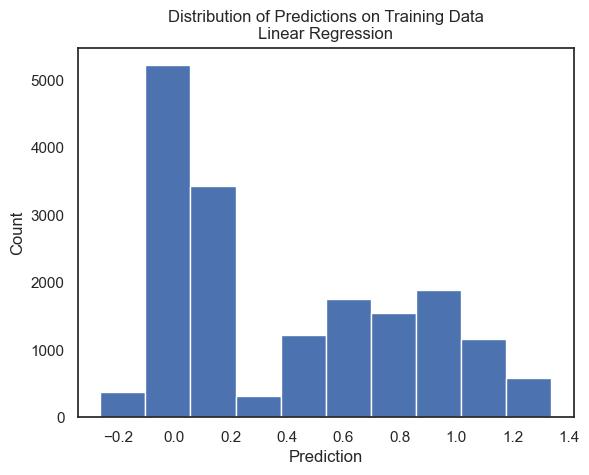

In [1681]:
# distribution of predictions
prediction = linreg.predict(X_train)
plt.hist(prediction,bins=10)
plt.title("Distribution of Predictions on Training Data\nLinear Regression")
plt.ylabel("Count")
plt.xlabel("Prediction")

Text(0.5, 0, 'Prediction')

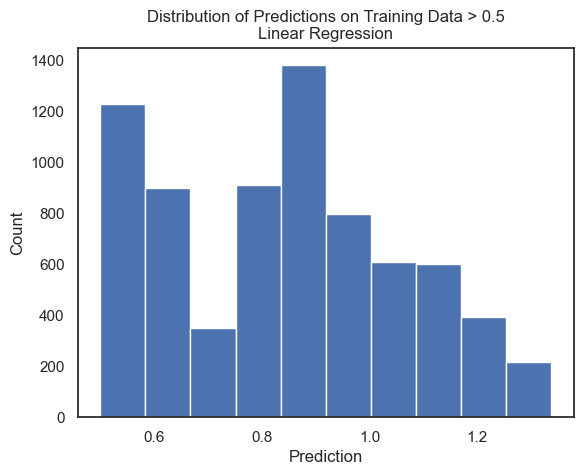

In [1682]:
plt.hist(prediction[prediction>0.5],bins=10)
plt.title("Distribution of Predictions on Training Data > 0.5\nLinear Regression")
plt.ylabel("Count")
plt.xlabel("Prediction")

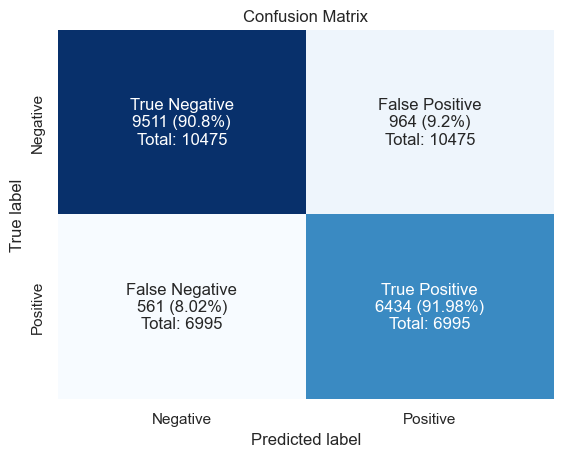

In [1683]:
# Calculate the confusion matrix and store it in the variable cm
cm = confusion_matrix(Y_train, linreg_predictions_train)

# Calculate the percentages
percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
percentages = np.round(percentages * 100, 2)

# Calculate the total number of samples for each class
totals = cm.sum(axis=1)

# Define class labels and headings for each cell
class_labels = ['Negative', 'Positive']
cell_headings = [['True Negative', 'False Positive'],
                 ['False Negative', 'True Positive']]

# Create custom annotation format
annot = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f'{cell_headings[i][j]}\n{cm[i, j]} ({percentages[i, j]}%)\nTotal: {totals[i]}'

# Plot the heatmap
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

The above confusion matrix shows how our model is performing.

1. 91% of negatives are predicted correctly
2. 8% of positives are predicted to be negatives

So while we have a high accuracy value of 0.908, this mostly lies on the fact that we have a large number of death=No in the dataset and we actually predict very few of the deaths.

Summary

* Very low F1 score value
* The model predicts death=No quite well but does not predict death=Yes very well at all
* This is because the model has more rows where death=No to learn from - it is the majority class.

## (2.4) Evaluate the Test Data

Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. 

* The results from the test data will be compared with the results from the training data.
* In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

In [1684]:
# Drop rows with missing values in the test dataset
X_test = X_test.dropna()
Y_test = Y_test[X_test.index]

# Use the preprocessed test dataset for prediction
linreg_predictions_test = linreg.predict(X_test)

In [1685]:
def get_predict_head(predictions, data="train"):
    if data == "train":
        df_temp = Y_train.copy()
    elif data == "test":
        df_temp = Y_test.copy()

    df_temp = pd.DataFrame(df_temp)
    df_temp['Predicted'] = predictions
    return df_temp.head(10)

# print first 10 rows
get_predict_head(linreg_predictions_test, data="test")

Death  Predicted
0       0   0.102140
1       0   0.375564
2       0   0.073835
3       0   0.078696
4       0  -0.040761
5       0  -0.011733
7       1   1.011184
8       0   0.022620
9       1   1.293456
10      0   0.315487

# Linear Regression Predictions returning continuous predict

Text(0.5, 0, 'Prediction')

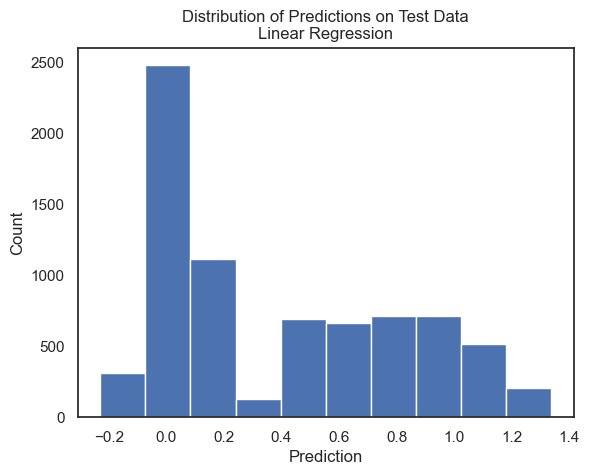

In [1686]:
prediction = linreg.predict(X_test)
plt.hist(prediction,bins=10)
plt.title("Distribution of Predictions on Test Data\nLinear Regression")
plt.ylabel("Count")
plt.xlabel("Prediction")

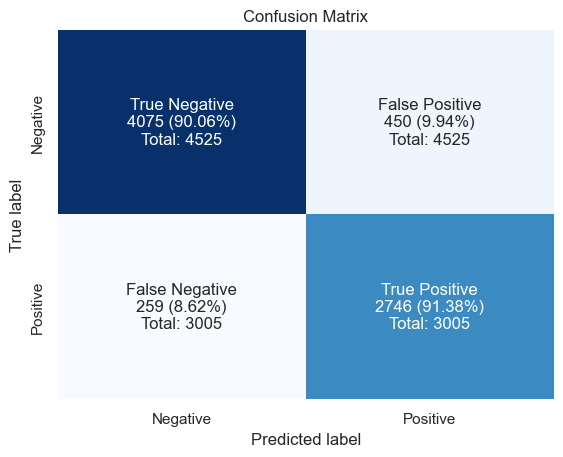

In [1687]:
linreg_predictions_test = np.round(linreg_predictions_test)
# Calculate the confusion matrix and store it in the variable cm
cm = confusion_matrix(Y_test, linreg_predictions_test)

# Calculate the percentages
percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
percentages = np.round(percentages * 100, 2)

# Calculate the total number of samples for each class
totals = cm.sum(axis=1)

# Define class labels and headings for each cell
class_labels = ['Negative', 'Positive']
cell_headings = [['True Negative', 'False Positive'],
                 ['False Negative', 'True Positive']]

# Create custom annotation format
annot = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f'{cell_headings[i][j]}\n{cm[i, j]} ({percentages[i, j]}%)\nTotal: {totals[i]}'

# Plot the heatmap
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [1688]:
printMetrics(Y_train, linreg_predictions_train, regression=False)

====================  Data =======================
Accuracy:  0.9127074985689754
Confusion matrix: 
 [[9511  964]
 [ 561 6434]]
Classification report:
                precision    recall  f1-score   support

           0       0.94      0.91      0.93     10475
           1       0.87      0.92      0.89      6995

    accuracy                           0.91     17470
   macro avg       0.91      0.91      0.91     17470
weighted avg       0.91      0.91      0.91     17470




<b> Interpretation of test results and comparison with training results </b>

* All Classification records stayed relatively consistent in comparison to the training data
* There were no major changes between the values returned for precision, recall, f1-score and support 

### Cross validation

* We will now perform cross validation on the linear regression model.
* Here we perform the same evaluation as above but multiple times
* We will cross validate using a number of different types of cross validation, namely:
    * KFold: Create k random equally sized samples, of the k samples one is partitioned to be used for testing, while the remaining k-1 are used for training the model
    * TimeSeriesSplit: Variation of K fold used for time based cross validation, returns the first k folds as the training set and the k +1 th fold as the test set
    * ShuffleSplit: Random permutation cross validator <br>
    <br>
First we need to create a function to perform this cross validation. Sklearn does not provide one for linear regression. However it does for logistic and random forests models

In [1690]:
def cross_val(model, X, Y, cv=10, split_type="shuffle",**model_args):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    results = pd.DataFrame(columns = ['accuracy','precision','recall', 'f1'])
    if split_type == "time":
        cv = TimeSeriesSplit(n_splits=cv)
    elif split_type == "kfold":
        cv = KFold(n_splits=cv)
    elif split_type == "loo":
        cv = LeaveOneOut()
    else:
        cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=0)
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        Y_train, Y_test = Y.iloc[list(train_index)], Y.iloc[list(test_index)]
        if model_args == None:
            multiple_linreg = model().fit(X_train, Y_train)
        else:
            multiple_linreg = model(**model_args).fit(X_train, Y_train)
        predictions = multiple_linreg.predict(X_test)
        multiple_linreg_predictions = (predictions >= 0.5) * 1.0
        accuracy = metrics.accuracy_score(Y_test, multiple_linreg_predictions)
        precision = metrics.precision_score(Y_test, multiple_linreg_predictions)
        f1 = metrics.f1_score(Y_test, multiple_linreg_predictions)
        recall = metrics.recall_score(Y_test, multiple_linreg_predictions)
        new_row = pd.DataFrame({"accuracy": [accuracy], "precision": [precision], "f1": [f1], "recall": [recall]})
        results = pd.concat([results, new_row], ignore_index=True)
    return results.describe(), predictions

In [1691]:
def cross_val_report(model, X, Y, cv=10, split_type="shuffle", **model_args):
    """
    Function to generate a cross validation report
    """
    if split_type == "random":
        df2, p3 = cross_val(model, X, Y, cv=cv)
        dfcon = pd.concat([df2], axis=1, keys=['random'])
        return dfcon
    df0, p1 = cross_val(model, X, Y, split_type="kfold", cv=cv)
    df1, p2 = cross_val(model, X, Y, split_type="time", cv=cv)
    df2, p3 = cross_val(model, X, Y, cv=cv)
    dfcon = pd.concat([df0, df1, df2], axis=1, keys=['kfold', 'time', 'random'])
    return dfcon

In [1692]:
def report_summary(report):
    """
    get a summary of the cross validation report
    """
    return report["random"].iloc[1, :]

In [1693]:
def report_comparison(columns, reports):
    """
    compare multiple cross validation reports
    """
    df = pd.DataFrame(columns = columns)
    
    for count, report in enumerate(reports):
        df[columns[count]] = report_summary(report)
    return df

In [1694]:
# fill in missing values with 0
X = X.fillna(0)

# get the linear regression cross validation report
linregreport = cross_val_report(LinearRegression, X, Y, cv=10)
linregreport

kfold                                        time              
        accuracy  precision     recall         f1   accuracy  precision   
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  \
mean    0.910575   0.801325   0.854184   0.826805   0.909901   0.799746   
std     0.006369   0.016556   0.014374   0.012234   0.006668   0.016853   
min     0.903000   0.777372   0.823869   0.814090   0.897690   0.770115   
25%     0.905188   0.789595   0.848275   0.818905   0.906628   0.790184   
50%     0.909750   0.796674   0.854816   0.823340   0.909653   0.797843   
75%     0.914875   0.813917   0.864067   0.831158   0.911991   0.808509   
max     0.922000   0.832258   0.874153   0.852691   0.921067   0.829980   

                                random                                   
          recall         f1   accuracy  precision     recall         f1  
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  
mean    0.853539   0.825639   0.910267   0.801970   0.853657   0.826960  
std     0.014427   0.011663   0.002156   0.008119   0.007849   0.004580  
min     0.821164   0.812121   0.906333   0.786785   0.839280   0.817473  
25%     0.848179   0.818751   0.909229   0.797715   0.849656   0.825215  
50%     0.854268   0.822192   0.910583   0.801381   0.852003   0.827130  
75%     0.860132   0.828836   0.911271   0.805628   0.858712   0.830317  
max     0.874867   0.851833   0.913250   0.814745   0.866579   0.832448

The accuracy across each of the validation methods lies around 91%. The model's precision is consistently higher than its recall, meaning that most of the death=Yes which the model is predicting are correct although it is returning very few of these values. Read more

Our F1 score across each of the cross validated analyses are quite poor, with a maximum of .14 mean for KFold. This is low due to our low recall values.

ShuffleSplit/Random returns the highest value of average f1 score across the 3 validation methods. This value is 0.82.

A big factor at play here is the chosen threshold value of 0.5. Our distribution of the predicted value mostly lies in the range from -0.1 - +0.1, while the threshold is 0.5. We are not missing a large amount of predictions with this given threshold value. This could also be optimised to improve our models predictions.

## (3) Logistic Regression

### (3.1) Train the Logistic Regression

In [1695]:
# Train aka fit, a model using all continuous and categorical features.
logisticreg = LogisticRegression(max_iter=1000).fit(X_train, Y_train)

### (3.2) Coefficients

In [1696]:
print_coef(logisticreg)


Intercept is: 
 0.16188698484965114
                       feature         1
7                  Hospital_No -0.065269
14                 at_risk_Yes -0.043128
17               Season_Summer -0.022765
10                      ICU_No -0.010788
1              State_Fips_Code -0.002221
3              case_per_season -0.000052
2               case_per_month  0.000020
5   Symptom_Status_Symptomatic  0.000196
0                   Case_Month  0.003620
8                   Hospital_0  0.016186
16               Season_Spring  0.016304
4             Symptom_Status_5  0.026054
6             Symptom_Status_0  0.046681
11                       ICU_0  0.061035
13   Underlying_Conditions_Yes  0.064207
19                   Age_Group  0.066120
12                     ICU_Yes  0.104645
18               Season_Winter  0.144144
9                 Hospital_Yes  0.263795
15                old_aged_Yes  0.364294


<b> Interpreting the results:</b>

The Logistic Regression function is a little different than the Linear Regression function.

<b> Output</b>

* Logistic Regression: Probability, a value between 0 and 1:
    * Logistic Regression can be effectively used for regression and classification problems
* Linear Regression: Continuous value that is not a probability
* Differences aside there is a direct relationship between the two
    * The first part of Logistic Regression function is similar to Linear Regression i.e. We find the line of best fit
    * We then pass this equation through a activation function (the sigmoid function) which outputs a value bound between 0 and 1. It is a probability
    * The model then applies a threshold to this probability so that if is is >= 0.5 its cast to 1 and if it is <0.5 it is cast to 0
    * All of these steps are carried out within the Logistic Regression function, however the threshold value can be adjusted up or down depending on the problem you are trying to solve.


* From the values above, we can see the calculated intercept is 0.16
    * This is the starting point. i.e. if all other coefficients were zero then the value for 'x' would be 0.16.
    * This is the input to the Logistic function and the Logistic function will then calculate the probability and threshold based on this.
* We can see all the coefficients for each features
    * The effect of these on the value 'x' is the same as for Linear Regression
    * Only when the value 'x' is fed into the Logistic function do we see the real difference between the to methods.
    * The coefficient values for Logistic Regression are identical to those found in the Linear Regression above, due to the reasons discussed above.<br>
    <br>
A major benefit of Logistic Regression worth highlighting is its ability to handle outliers.

### (3.3) Evaluate the Trained Data

In [1697]:
logisticreg_predictions_train = get_target(logisticreg, data="train")
get_predict_head(logisticreg_predictions_train, data="train")

Death  Predicted
2       1        1.0
4       1        1.0
5       0        0.0
7       0        0.0
9       1        1.0
10      0        0.0
12      1        1.0
14      1        1.0
15      1        1.0
16      0        0.0

In [1698]:
printMetrics(Y_train, logisticreg_predictions_train)

====================  Data =======================
Accuracy:  0.9242701774470521
Confusion matrix: 
 [[9792  683]
 [ 640 6355]]
Classification report:
                precision    recall  f1-score   support

           0       0.94      0.93      0.94     10475
           1       0.90      0.91      0.91      6995

    accuracy                           0.92     17470
   macro avg       0.92      0.92      0.92     17470
weighted avg       0.92      0.92      0.92     17470




Interpretation of results

* Accuracy

    * The Accuracy figure states that we have an accuracy of 92%, this value is slightly higher than the Linear Regression.
* Precision

    * Precision death=No is 0.94
    * Precision death=Yes is 0.90
    * High precision for death=No, relatively low for death=Yes but also quite high.
    * Slightly higher precision than the same value for Linear Regression.
    
* Recall

    * Recall death=No is 0.93
    * Recall death=Yes is 0.91
 
* F1 Score

    * Weighted average of Precision and Recall
    * Recall death=No is 0.94
    * Recall death=Yes is 0.91

Summary

* These values seem more reasonable than the Linear Regression model.
* Accuracy is in line with the Linear Regression model
* The Logistic Regression model has higher precision, recall and f1 score than Linear Regression.

In [1699]:
def plot_proba(model, X):
    """
    Plot the probabilities from the model
    """
    prediction = model.predict_proba(X)[:,1]
    prediction
    plt.figure(figsize=(15,7))
    plt.hist(prediction, bins=50, label='Death=Yes', alpha=0.7, color='r')
    plt.xlabel('Probability of being Death', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=15)
    plt.tick_params(axis='both', labelsize=15, pad=5)
    plt.title("Probability distrubtion of given model prediction")
    plt.show()

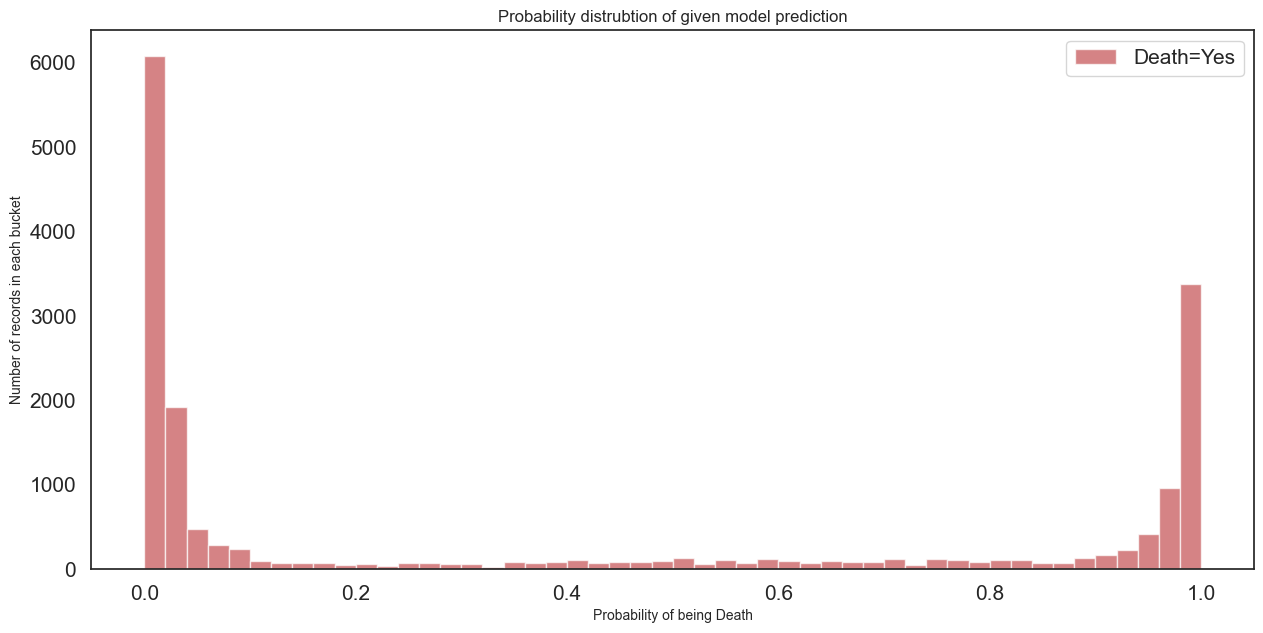

In [1700]:
plot_proba(logisticreg, X_train)

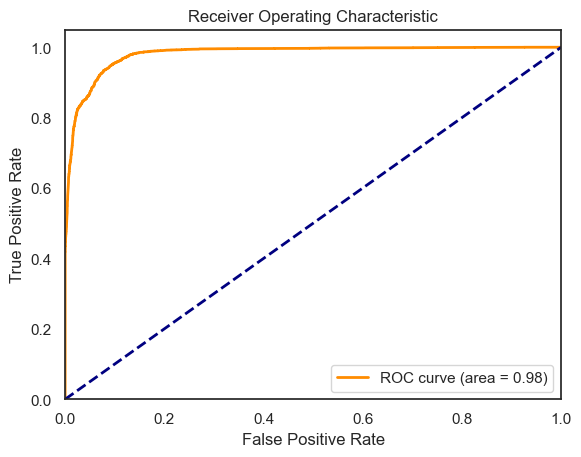

In [1701]:
# Compute the ROC curve and AUC score
y_pred_prob = logisticreg.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(Y_train, y_pred_prob)
roc_auc = roc_auc_score(Y_train, y_pred_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

We have obtained a very high AUC value of 0.98 on the testing data

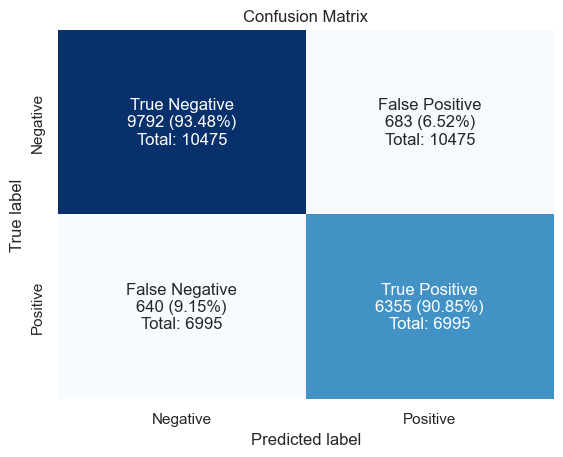

In [1702]:
# Calculate the confusion matrix and store it in the variable cm
cm = confusion_matrix(Y_train, logisticreg_predictions_train)

# Calculate the percentages
percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
percentages = np.round(percentages * 100, 2)

# Calculate the total number of samples for each class
totals = cm.sum(axis=1)

# Define class labels and headings for each cell
class_labels = ['Negative', 'Positive']
cell_headings = [['True Negative', 'False Positive'],
                 ['False Negative', 'True Positive']]

# Create custom annotation format
annot = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f'{cell_headings[i][j]}\n{cm[i, j]} ({percentages[i, j]}%)\nTotal: {totals[i]}'

# Plot the heatmap
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

### (3.4) Evaluate the Test Data
Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. 
* These results from the test data will be compared the results from the training data.
* In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [1703]:
logisticreg_predictions_test = get_target(logisticreg, data="test")
printMetrics(Y_test, logisticreg_predictions_test)

====================  Data =======================
Accuracy:  0.9209827357237715
Confusion matrix: 
 [[4204  321]
 [ 274 2731]]
Classification report:
                precision    recall  f1-score   support

           0       0.94      0.93      0.93      4525
           1       0.89      0.91      0.90      3005

    accuracy                           0.92      7530
   macro avg       0.92      0.92      0.92      7530
weighted avg       0.92      0.92      0.92      7530




In [1704]:
get_predict_head(logisticreg_predictions_test, data="test")

Death  Predicted
0       0        0.0
1       0        0.0
2       0        0.0
3       0        0.0
4       0        0.0
5       0        0.0
7       1        1.0
8       0        0.0
9       1        1.0
10      0        0.0

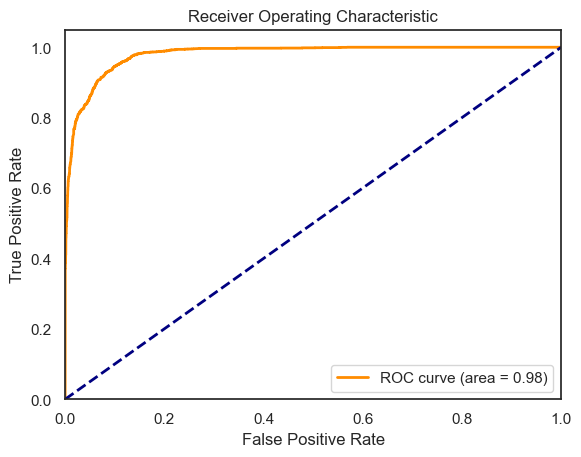

In [1705]:
# Compute the ROC curve and AUC score
y_pred_prob = logisticreg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, y_pred_prob)
roc_auc = roc_auc_score(Y_test, y_pred_prob)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

We obtained quite a high AUC value of 0.98 on the testing data as well

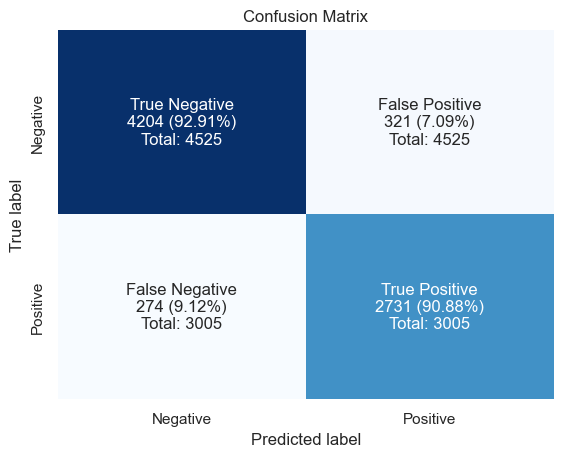

In [1706]:
# Calculate the confusion matrix and store it in the variable cm
cm = confusion_matrix(Y_test, logisticreg_predictions_test)

# Calculate the percentages
percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
percentages = np.round(percentages * 100, 2)

# Calculate the total number of samples for each class
totals = cm.sum(axis=1)

# Define class labels and headings for each cell
class_labels = ['Negative', 'Positive']
cell_headings = [['True Negative', 'False Positive'],
                 ['False Negative', 'True Positive']]

# Create custom annotation format
annot = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f'{cell_headings[i][j]}\n{cm[i, j]} ({percentages[i, j]}%)\nTotal: {totals[i]}'

# Plot the heatmap
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

<b>Interpretation of test results and comparison with training results</b>
* The majority of the results stayed somewhat in line with the results from Linear Regression
* Accuracy
    * Overall accuracy score of 0.9209
* True Negative 92.92% vs 90.06%
* False Positive 7.09% vs 9.94%
* False Negative 9.12% vs 8.62%
* True Positive 90.88% vs 91.38%
<br>
* Summary

    * The model's predictions for the test set are not as bad as we were expecting after Linear Regression above.
    * The values we see here are reducing by much less between train and test than what we saw for the Linear Regression.

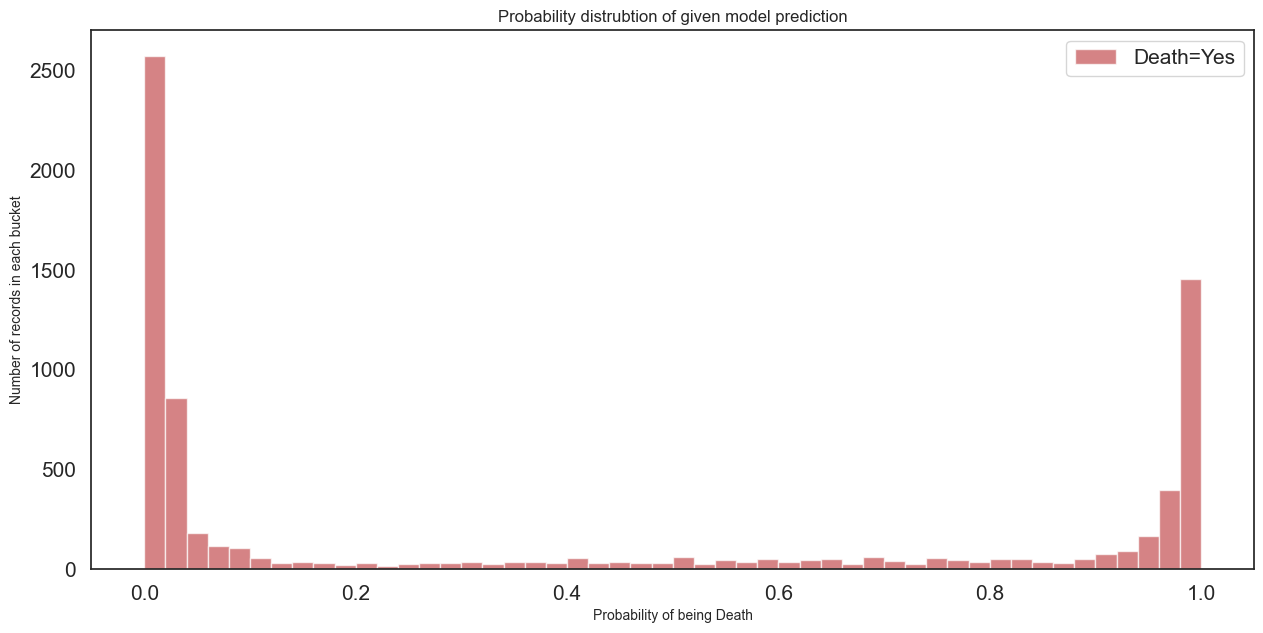

In [1707]:
plot_proba(logisticreg, X_test)

### Cross Validation

In [1708]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    logregreport = cross_val_report(LogisticRegression, X, Y, cv=10)
    display(logregreport)

kfold                                        time              
        accuracy  precision     recall         f1   accuracy  precision   
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  \
mean    0.888625   0.782987   0.769267   0.775740   0.897057   0.803486   
std     0.021219   0.044115   0.041767   0.039847   0.008959   0.036292   
min     0.850250   0.694799   0.680433   0.702730   0.874587   0.724299   
25%     0.876563   0.753175   0.768328   0.766487   0.895283   0.791262   
50%     0.897125   0.804142   0.781211   0.792442   0.899065   0.807270   
75%     0.904500   0.811726   0.791210   0.800171   0.900646   0.816340   
max     0.907000   0.818458   0.812749   0.813559   0.908416   0.871011   

                                random                                   
          recall         f1   accuracy  precision     recall         f1  
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  
mean    0.783484   0.791949   0.888742   0.785584   0.766465   0.775835  
std     0.036098   0.011510   0.019964   0.044071   0.038400   0.040440  
min     0.694592   0.772682   0.851167   0.703183   0.693932   0.701537  
25%     0.777165   0.788912   0.887313   0.779443   0.766650   0.774103  
50%     0.790374   0.795820   0.897292   0.801917   0.777890   0.794663  
75%     0.802112   0.797055   0.901250   0.816728   0.787523   0.798931  
max     0.827991   0.807848   0.904500   0.821975   0.805519   0.807395

In [1709]:
report_comparison(["Linear Regression", "Logistic Regression"],[linregreport, logregreport])

Linear Regression  Logistic Regression
accuracy            0.910267             0.888742
precision           0.801970             0.785584
recall              0.853657             0.766465
f1                  0.826960             0.775835

We obtain quite high scores across the board for accuracy, which is to be expected due to the unbalanced nature of the data.

<b> Summary </b>
* Surprisingly, the Linear Regression model produced more accurate results across the board, even though most of the Logistic Regression model results were quite high as well
* It is possible that the relationship between the features and the target variable in this dataset is more linear than sigmoidal, which might cause Logistic Regression to perform worse than Linear Regression
* The performance of Logistic Regression can be influenced by hyperparameters which will be analysed later 

## (4) Random Forest 

### (4.1) Train the Random Forest
On the training set, train a random forest model to predict the target feature, using the descriptive features selected in exercise (1) above.
___ - A random forest model will now be trained on our test data. - We use the RandomForestClassifier() function. - The random state will be set to 1 to allow the results to be repeated

In [1710]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, Y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)

### Understanding the Random Forest model

We will now try to understand how this Random Forest model works

* We will first start by trying to understand a Decision Tree
* A Random Forest is made up of an ensemble/collection of Decision Trees

* Decision Tree
    * A Decision Tree is a set of if-then-else rules based on splitting the data into subgroups based on specific feature values
    * The decision on which feature to split on is based on the information gain (default is Gini index).
    * The tree will always split on the feature that gives the highest information gain
    * The feature with the highest information gain will sit at the root of each Decision Tree
    * Each Decision Tree will be a single prediction
    <br>
* Random Forest
    * The Random Forest is made up of a number of Decision Trees (default 100)
    * The output of the Random Forest is based on the majority output of all Decision Trees combined
    * This gives reliable results but can be hard to interpret
    * The Random Forest will keep track of the importance of features in terms of information gain, which we will see
    <br>
    <br>
We will now look examples various Decision Trees to gain a better understanding:

In [1711]:
# create a decision tree with max depth of 4
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)

# create a decision tree with max depth of 10
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)

# fit them both on training data
dtc4.fit(X_train, Y_train)
dtc10.fit(X_train, Y_train)

# print max depths
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeClassifier(max_depth=10, random_state=1)


### Display Decision Tree

In [1712]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(
        dtc4,
        out_file=f1,
        feature_names=list(X_train.columns),
        class_names=["No", "Yes"],
        filled=True,
        rounded=True
    )

with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(
        dtc10,
        out_file=f2,
        feature_names=list(X_train.columns),
        class_names=["No", "Yes"],
        filled=True,
        rounded=True
    )

# Create PDFs with larger bitmaps
!dot -Tpdf -Gdpi=800 DecisionTree4.dot -o DecisionTree4.pdf
!dot -Tsvg -Gdpi=800 DecisionTree10.dot -o DecisionTree10.svg

In [1713]:
# with WandImage(filename='DecisionTree4.pdf') as img:
#     img.format = 'png'
#     img.save(filename='DecisionTree4.png')

In [314]:
display(Image(filename='trees/DecisionTree4.png'))

We can see below the decision tree with max_depth=4

* We can see the root is hosp_yn at value less than or equal to 0.5 - This splits the data best i.e. has the highest information gain
* For each split the the model selects the next best feature
* This continues until it reaches a leaf node where the data cannot be split anymore
* The output of this is the prediction
* We can see the leftmost path below is resolved in 4 branches

In [1715]:
# with WandImage(filename='DecisionTree10-compressed_compressed.pdf') as img:
#     img.format = 'png'
#     img.save(filename='DecisionTree10-compressed.png')

In [325]:
from IPython.display import IFrame
IFrame("trees/DecisionTree10.pdf", width=18000, height=1000)

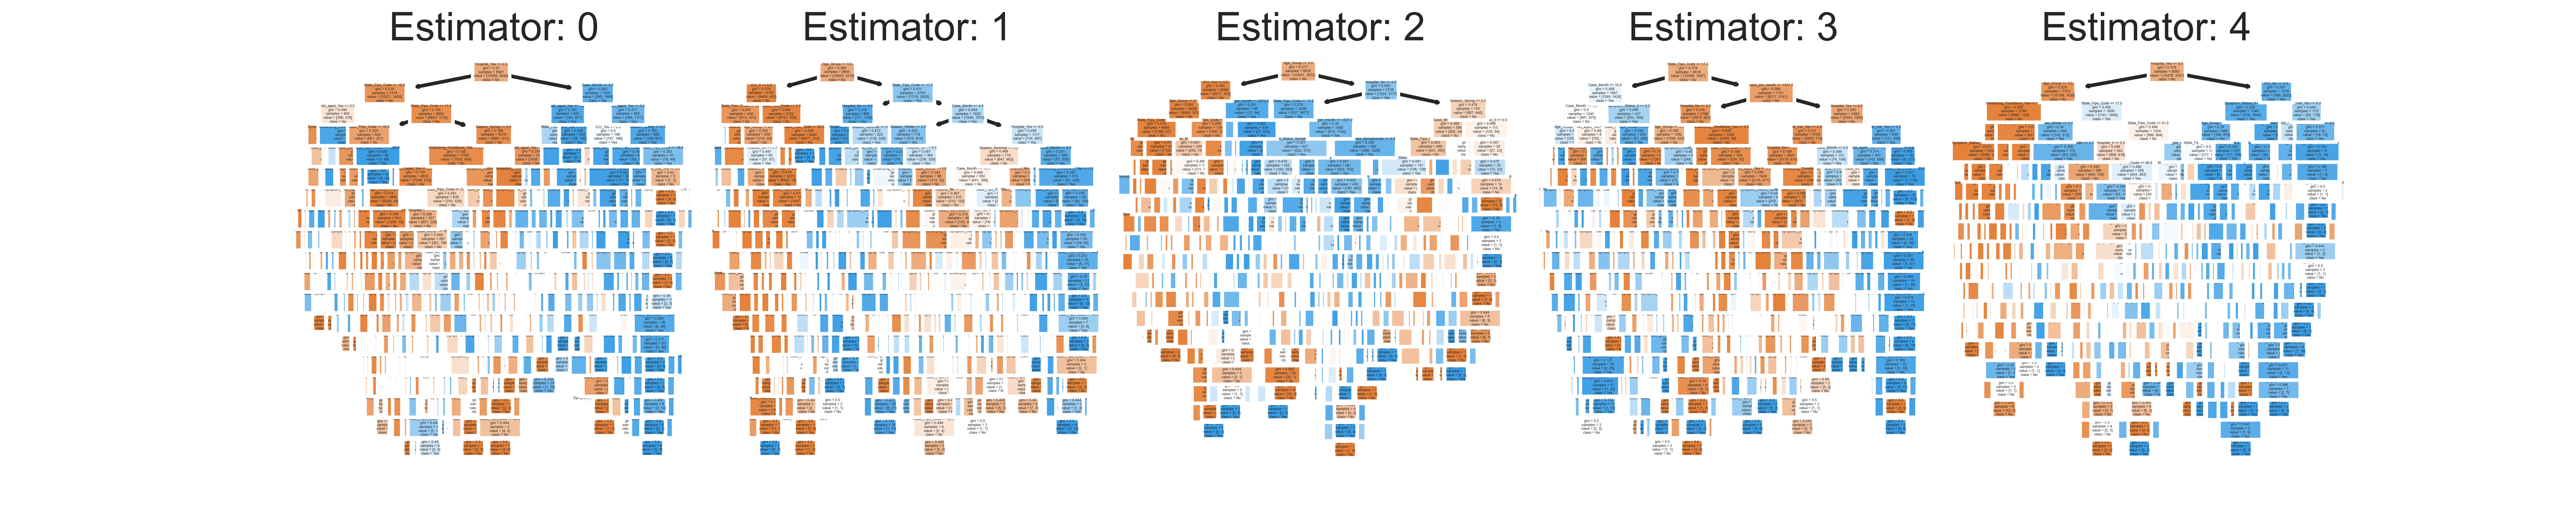

In [326]:
display(Image(filename='trees/rf_5trees.png'))

We can also look at the Decision Trees within the Random Forest which we have trained. These visualisations show how the complexity grows when we don't limit the max_depth.

### Interpretation of the Random Forest model

As mentioned above the Random Forest will keep track of the importance of features

* We can see from the dataframe below the results of this feature importance ranking
* I have used a number of different metrics to plot the feature importance:
    * feature_importances: This is an impurity based feature importance metric. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. 
    * permutation_importance: This is the decrease in a model score when a single value is randomly shuffled, breaking the relationship between the feature and the target variable. 

* The more important features are the features that the Random Forest has identified as having higher information gain across all of the Decision Trees
* We can use the information we learn below to choose which features to drop and which to keep in our final prediction model.

In [1719]:

def get_importances(model, X, y, shap_plot=True):
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.title("feature_importances_")
    plt.show()
    perm_importance = permutation_importance(model, X, y)
    perm_importance_df = pd.DataFrame({'feature': X.columns[sorted_idx], 'perm_importance':perm_importance.importances_mean[sorted_idx]})
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
    plt.title("perm_importance")
    plt.show()


## (4.3) Evaluate the Trained Data

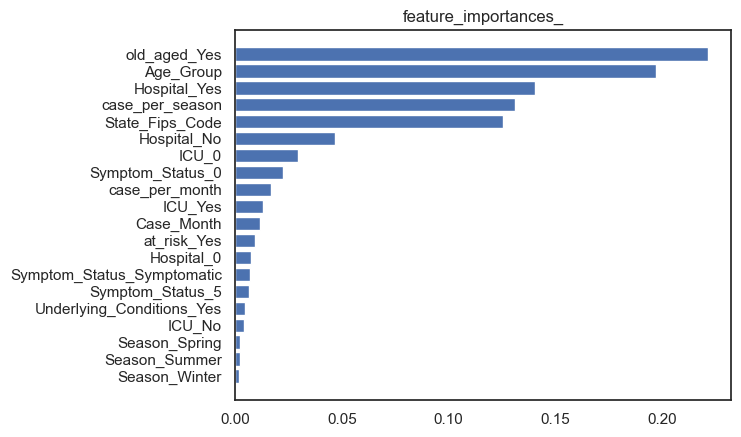

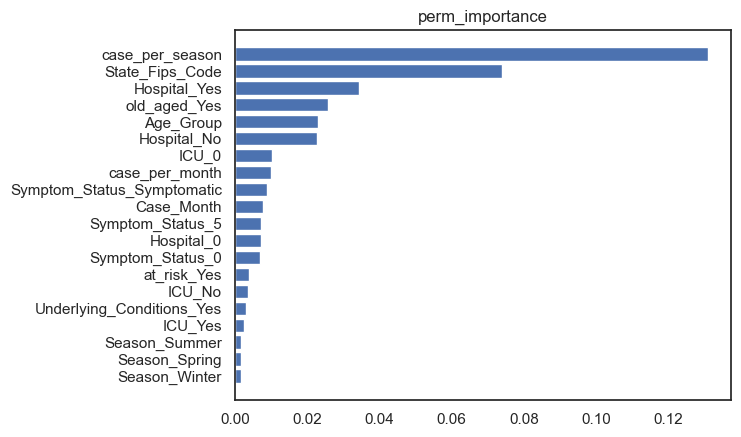

In [1720]:
get_importances(rfc, X_train, Y_train)

In [1721]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
get_predict_head(rfc_predictions_train, data="train")

Death  Predicted
2       1          1
4       1          0
5       0          0
7       0          0
9       1          1
10      0          0
12      1          1
14      1          0
15      1          1
16      0          0

In [1722]:
printMetrics(Y_train, rfc_predictions_train)

====================  Data =======================
Accuracy:  0.9769891242129365
Confusion matrix: 
 [[10275   200]
 [  202  6793]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.98      0.98     10475
           1       0.97      0.97      0.97      6995

    accuracy                           0.98     17470
   macro avg       0.98      0.98      0.98     17470
weighted avg       0.98      0.98      0.98     17470




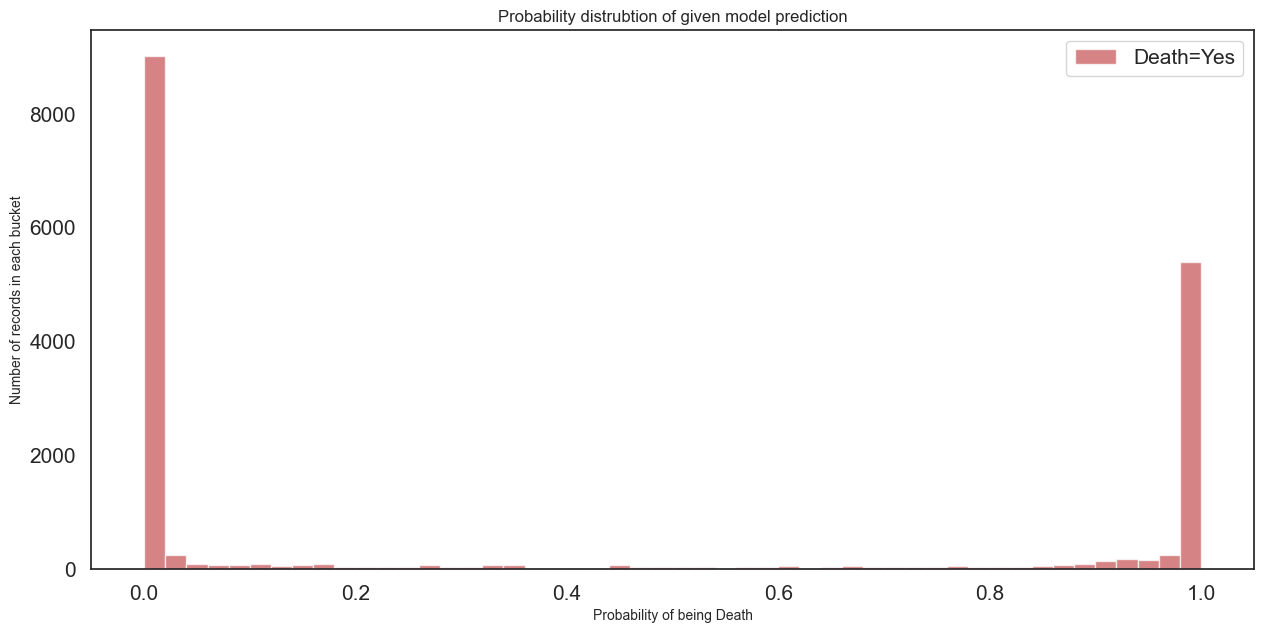

In [1723]:
plot_proba(rfc, X_train)

## (4.4) Evaluate the Test Data
Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained when using the training (70%) dataset for evaluation. Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated train/test (70/30) splits. Compare the cross-validation metrics to those obtained on the single train/test split and to the out-of-sample error and discuss your findings. 

In [1724]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
get_predict_head(rfc_predictions_test, data="test")

Death  Predicted
0       0          0
1       0          0
2       0          0
3       0          0
4       0          0
5       0          0
7       1          1
8       0          0
9       1          1
10      0          0

In [1725]:
X_test.iloc[[9],: ]

Case_Month  State_Fips_Code  case_per_month  case_per_season   
10          11             34.0            2083           4739.0  \

    Symptom_Status_5  Symptom_Status_Symptomatic  Symptom_Status_0   
10                 0                           1                 0  \

    Hospital_No  Hospital_0  Hospital_Yes  ICU_No  ICU_0  ICU_Yes   
10            0           0             1       0      0        0  \

    Underlying_Conditions_Yes  at_risk_Yes  old_aged_Yes  Season_Spring   
10                          0            0             0              0  \

    Season_Summer  Season_Winter  Age_Group  
10              0              0          2

The model incorrectly predicts value 10 as being death=Yes here. Looking at the data this may have been because this person was in Hospital and also Symptomatic.

In [1792]:
printMetrics(Y_test, rfc_predictions_test)

====================  Data =======================
Accuracy:  0.9468791500664011
Confusion matrix: 
 [[4325  200]
 [ 200 2805]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      0.96      0.96      4525
           1       0.93      0.93      0.93      3005

    accuracy                           0.95      7530
   macro avg       0.94      0.94      0.94      7530
weighted avg       0.95      0.95      0.95      7530




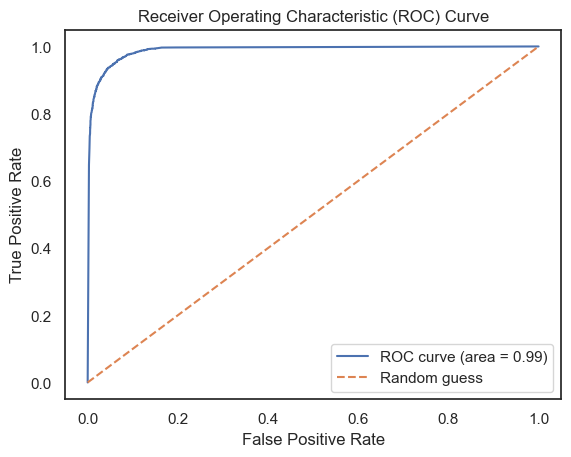

In [1727]:
# Get predicted probabilities for positive class
y_pred_proba = rfc.predict_proba(X_test)[:,1]

# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba, pos_label=1)
auc_score = roc_auc_score(Y_test, y_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

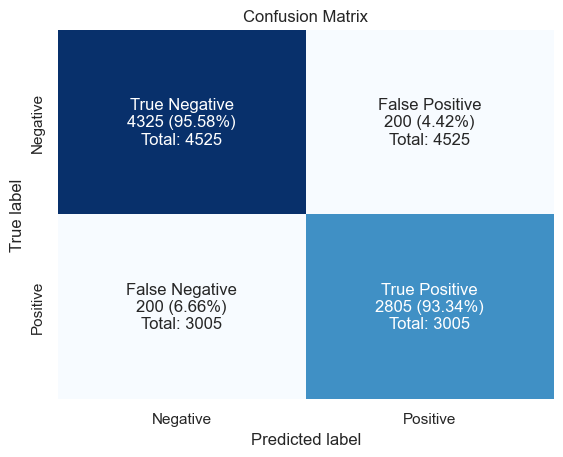

In [1728]:
# Calculate the confusion matrix and store it in the variable cm
cm = confusion_matrix(Y_test, rfc_predictions_test)

# Calculate the percentages
percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
percentages = np.round(percentages * 100, 2)

# Calculate the total number of samples for each class
totals = cm.sum(axis=1)

# Define class labels and headings for each cell
class_labels = ['Negative', 'Positive']
cell_headings = [['True Negative', 'False Positive'],
                 ['False Negative', 'True Positive']]

# Create custom annotation format
annot = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f'{cell_headings[i][j]}\n{cm[i, j]} ({percentages[i, j]}%)\nTotal: {totals[i]}'

# Plot the heatmap
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [1729]:
randomforestreport = cross_val_report(RandomForestClassifier, X,Y, cv=10)
randomforestreport

kfold                                        time              
        accuracy  precision     recall         f1   accuracy  precision   
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  \
mean    0.967650   0.934116   0.936713   0.935375   0.963834   0.929480   
std     0.002853   0.009622   0.006883   0.005548   0.004624   0.007496   
min     0.963500   0.920523   0.927396   0.929672   0.956271   0.917109   
25%     0.965562   0.927676   0.932826   0.930955   0.960740   0.924910   
50%     0.967250   0.932165   0.936999   0.933316   0.964109   0.929285   
75%     0.969938   0.938849   0.939188   0.939373   0.967753   0.932565   
max     0.972500   0.952429   0.951819   0.944779   0.969472   0.941748   

                                random                                   
          recall         f1   accuracy  precision     recall         f1  
count  10.000000  10.000000  10.000000  10.000000  10.000000  10.000000  
mean    0.925807   0.927619   0.965783   0.931007   0.932959   0.931971  
std     0.010562   0.007912   0.001354   0.005036   0.003331   0.002506  
min     0.907937   0.915200   0.962833   0.921105   0.927643   0.926281  
25%     0.919760   0.921700   0.965187   0.928630   0.931258   0.931283  
50%     0.925250   0.927514   0.965917   0.930760   0.932660   0.931753  
75%     0.930655   0.934389   0.966438   0.933634   0.935337   0.933418  
max     0.944506   0.938776   0.967667   0.939880   0.938420   0.935505

## (5) Improving Predictive Models

### (5.1) Best Model Evaluation

In [1730]:
death_Yes_count = Y_test[Y_test == 1].count()
death_No_count = Y_test[Y_test == 0].count()
total = death_Yes_count + death_No_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number death_yn=Yes:\t {death_Yes_count}\t{round(death_Yes_count/len(Y_test)*100,2)}%')
print(f'Total number death_yn=No:\t {death_No_count}\t{round(death_No_count/len(Y_test)*100,2)}%')

# generate array of zeros with the length of Y_test
majority = np.zeros(len(Y_test))
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual

printMetrics(Y_test, df_majorityClass)

# calculate scores of rfc prediction vs actual
rfc_pred = rfc.predict(X_test)
df_rfc = pd.DataFrame(rfc_pred, columns=['prediction'])
printMetrics(Y_test, df_rfc)

From original dataset: 		Count 7530
Total number death_yn=Yes:	 3005	39.91%
Total number death_yn=No:	 4525	60.09%
====================  Data =======================
Accuracy:  0.600929614873838
Confusion matrix: 
 [[4525    0]
 [3005    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.60      1.00      0.75      4525
           1       0.00      0.00      0.00      3005

    accuracy                           0.60      7530
   macro avg       0.30      0.50      0.38      7530
weighted avg       0.36      0.60      0.45      7530


====================  Data =======================
Accuracy:  0.9468791500664011
Confusion matrix: 
 [[4325  200]
 [ 200 2805]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      0.96      0.96      4525
           1       0.93      0.93      0.93      3005

    accuracy                           0.95      7530
   macro avg       0.94      0.94 

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### Comparing each of the models vs the Majority Class

We are only recording the metrics for predicting target feature = 1, i.e. Death=Yes, so we will compare these values with the train test metrics. We will use the random/ShuffleSplit for comparison

| Metric    | Linear Regression | Logistic Regression | Random Forest | Majority Class |
|-----------|-------------------|---------------------|---------------|----------------|
| Accuracy  | 91.2%             | 92.4%               | 97.6%         | 60.1%          |
| Precision | 87%               | 90%                 | 97%           | 0              |
| Recall    | 92%               | 91%                 | 97%           | 0              |
| F1        | 89%               | 91%                 | 97%           | 0              |

As we previously identified Recall to be the main value we would like to optimise the model for, I believe we should stick with the Random Forest Classifier model to better predict the values. While Logistic Regression may have a higher Precision value than the Random Forest we are not trying to optimise this so it may be more difficult to get to a valuable prediction with this model. The Linear regression has the highest prediction although its recall is incredibly low, so we will not be moving forward with this model.

All of that models have better Precision, Recall and F1 scores than simply using the majority class. While the majority class represents a 60.1% accuracy, the other values are all 0. This is because it does not identify any deaths. Using this model vs any of the other models which I have presented would be dangerous as it would assume that no one would die from Covid-19, regardless of symptoms. In this case we would be best to try to optimise the Random Forest model as it is providing the best overall results for F1 score.

### (5.2) Summary of Understanding
Summarise your understanding of the problem and of your predictive modeling results so far. Can you think of any new ideas to improve the best model so far (e.g., by using further data prep such as: feature selection, feature re-scaling, creating new features, combining models, or using other knowledge)? Please show how your ideas actually work in practice, by training and evaluating your proposed models. Summarise your findings so far.

In [1793]:
X.columns.to_frame().reset_index(drop=True)

0
0                   Case_Month
1              State_Fips_Code
2               case_per_month
3              case_per_season
4             Symptom_Status_5
5   Symptom_Status_Symptomatic
6             Symptom_Status_0
7                  Hospital_No
8                   Hospital_0
9                 Hospital_Yes
10                      ICU_No
11                       ICU_0
12                     ICU_Yes
13   Underlying_Conditions_Yes
14                 at_risk_Yes
15                old_aged_Yes
16               Season_Spring
17               Season_Summer
18               Season_Winter
19                   Age_Group

1. Case_Month = This feature did not add much value to the dataframe.
2. State_Fips_Code = No value added to the dataset and will have very little value going forward. Could also be damaging to a prediciton model with the number of individual values
3. case_per_month = This feature did not add much value to the dataframe. Might have focused more so on the cases per day
4. case_per_season = This feature did not add much value to the dataframe.
5. Symptom_Status_Symptomatic = This feature did add value and we will be keeping it for now.
6. Hospital_No = This feature was not very important after encoding, although its counterpart Hospital_Yes was.
7. Hospital_Yes = This feature was important and will therefore be kept. We will consider dropping Hosptial_No alone (essentially grouped Hospital_No and Unknown values together into the hidden feature).
8. ICU_No = This feature did not add nearly as much value as expected. My thoughts on this are that there was very little actual data for icu_yn in the original dataset so it was hard to predict using it. 
9. ICU_Yes = This feature did not as much value as suspected. We will keep for further investigation.
10. Underlying_Conditions_Yes = Has had a small correlation to the main target feature. Will be kept for now.
11. at_risk_Yes = This feature did not as much value as suspected. We will keep for further investigation.
12. old_aged_Yes = This feature did add value and we will be keeping it.
13. Age_Group = Strong predictor across all of the models, we could try rescaling this feature to see if this would help.

<b> High correlation features only </b>
<br>
   * We will repeat tests using high correlation features identified above

In [1732]:
highest_corr_features = ["Age_Group", "ICU_Yes", "old_aged_Yes", "Hospital_Yes", "Symptom_Status_Symptomatic"]

In [1733]:
df_highCorr = df_rev1.copy()
y_highCorr = df_highCorr["Death"]
X_highCorr = df_highCorr[highest_corr_features]
print("Number of features: ", len(X_highCorr.columns))

Number of features:  5


In [1734]:
linregreport_highCorr = cross_val_report(LinearRegression, X_highCorr,y_highCorr, cv=10)
logregreport_highCorr = cross_val_report(LogisticRegression, X_highCorr,y_highCorr, cv=10)
randforestreport_highCorr = cross_val_report(RandomForestClassifier, X_highCorr,y_highCorr, cv=10)

report_comparison(["linreg", "logistic", "randomfor"], [linregreport_highCorr,logregreport_highCorr,randforestreport_highCorr])

linreg  logistic  randomfor
accuracy   0.894717  0.896950   0.898325
precision  0.779961  0.778891   0.772786
recall     0.809152  0.823599   0.843175
f1         0.794228  0.800599   0.806430

# All Features

In [313]:
df_all = pd.read_csv("CSV Files/merged_covid19_data.csv")

Columns (0,1,3,5,6,7,8,11,12,13,14,15,16,17,18,20,21,23,24,25,26,27,28,29,30,31,32,33,35,38,39) have mixed types. Specify dtype option on import or set low_memory=False.


In [1736]:
df_all

Case_Month Res_State  State_Fips_Code Res_County       Age_Group   
0        January        FL             12.0      DUVAL       65+ years  \
1        January        PA             42.0       YORK       65+ years   
2       December        OH             39.0      ALLEN       65+ years   
3          April        NY             36.0     QUEENS       65+ years   
4       November        IL             17.0   TAZEWELL       65+ years   
...          ...       ...              ...        ...             ...   
39995    January        FL             12.0    VOLUSIA    0 - 17 years   
39996    January        KS             20.0   SEDGWICK  18 to 49 years   
39997        May        OH             39.0     SUMMIT  18 to 49 years   
39998        May        NC             37.0      DAVIE  18 to 49 years   
39999    January        NV             32.0        NaN  50 to 64 years   

          Sex   Race            Ethnicity             Current_Status   
0      Female  White  Non-Hispanic/Latino  Laboratory-confirmed case  \
1        Male  White  Non-Hispanic/Latino  Laboratory-confirmed case   
2        Male  White  Non-Hispanic/Latino  Laboratory-confirmed case   
3        Male  White  Non-Hispanic/Latino  Laboratory-confirmed case   
4        Male  White  Non-Hispanic/Latino  Laboratory-confirmed case   
...       ...    ...                  ...                        ...   
39995  Female  White      Hispanic/Latino              Probable Case   
39996    Male  White  Non-Hispanic/Latino              Probable Case   
39997    Male  Asian  Non-Hispanic/Latino  Laboratory-confirmed case   
39998  Female  White  Non-Hispanic/Latino  Laboratory-confirmed case   
39999    Male  White  Non-Hispanic/Latino  Laboratory-confirmed case   

      Symptom_Status  ...      ICU Death Underlying_Conditions at_risk   
0            Missing  ...  Missing   Yes                   NaN      No  \
1        Symptomatic  ...  Unknown   Yes                   NaN      No   
2        Symptomatic  ...  Missing   Yes                   Yes     Yes   
3            Unknown  ...  Unknown   Yes                   Yes     Yes   
4            Missing  ...  Missing   Yes                   NaN      No   
...              ...  ...      ...   ...                   ...     ...   
39995        Unknown  ...  Unknown    No                   NaN      No   
39996    Symptomatic  ...  Unknown    No                   NaN      No   
39997        Unknown  ...  Unknown    No                   NaN      No   
39998    Symptomatic  ...  Unknown    No                   NaN      No   
39999    Symptomatic  ...  Unknown    No                   NaN      No   

      old_aged  Season case_per_month  case_per_season  Unnamed: 0  percent  
0          Yes  Winter           4033           8020.0         NaN      NaN  
1          Yes  Winter           4033           8020.0         NaN      NaN  
2          Yes  Winter           3070           8020.0         NaN      NaN  
3          Yes  Spring           1414           3428.0         NaN      NaN  
4          Yes    Fall           2083           4739.0         NaN      NaN  
...        ...     ...            ...              ...         ...      ...  
39995       No  Winter           4018              NaN     19995.0      0.0  
39996       No  Winter           4018              NaN     19996.0      0.0  
39997       No  Spring           1172              NaN     19997.0      0.0  
39998       No  Spring           1172              NaN     19998.0      0.0  
39999       No  Winter           4018              NaN     19999.0      0.0  

[40000 rows x 21 columns]

In [1737]:
df_all = df_all.drop(columns=["Unnamed: 0","percent","case_per_season","State_Fips_Code","Res_State","Res_County"])

In [1738]:
df_all = df_all.replace(age_dict)

In [1739]:
try:
    df_all['Death'] = df_all['Death'].map({'Yes': 1, "No": 0})
    df_all['Death'] = df_all['Death'].astype('int64')
except:
    pass

df_all = pd.get_dummies(df_all, drop_first=True)

In [1740]:
# setup dataframe
all_y = df_all["Death"]

In [1741]:
all_X = df_all.drop(["Death"], axis=1)

In [1742]:
# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
all_X_imputed = pd.DataFrame(imputer.fit_transform(all_X), columns=all_X.columns)

# Split the data into training and testing sets
all_X_train, all_X_test, all_y_train, all_y_test = train_test_split(all_X_imputed, all_y, test_size=0.3, random_state=1)

# Create an instance of RandomForestClassifier and fit it on the training data
all_rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
all_rfc.fit(all_X_train, all_y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)

In [1743]:
all_randforestreport = cross_val_report(RandomForestClassifier, all_X_imputed, all_y, cv=10, split_type="random")

In [1744]:
all_randforestreport

random                                 
        accuracy  precision     recall         f1
count  10.000000  10.000000  10.000000  10.000000
mean    0.913917   0.819105   0.840109   0.829435
std     0.002342   0.005966   0.009730   0.005236
min     0.909750   0.812439   0.826917   0.823068
25%     0.912708   0.813491   0.834436   0.826095
50%     0.914167   0.819468   0.839080   0.828688
75%     0.914542   0.821579   0.843705   0.830750
max     0.918417   0.830164   0.861600   0.841355

Interestingly when we train the model using all of the features, we have quite a high precision value but our recall does suffer. Ultimately it is not quite as good as the filtered model.

In [1745]:
all_X_numeric = all_X_imputed.apply(pd.to_numeric, errors='coerce')

In [1746]:


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(all_X_numeric.values, i) for i in range(all_X_numeric.shape[1])]
vif["features"] = all_X_numeric.columns
vif_sorted = vif.sort_values("VIF Factor")
print(vif_sorted)

divide by zero encountered in scalar divide


     VIF Factor                                     features
21     1.004682  Race_Native Hawaiian/Other Pacific Islander
13     1.019617                                        Sex_5
26     1.025591                 Current_Status_Probable Case
17     1.037782           Race_American Indian/Alaska Native
20     1.067069                          Race_Multiple/Other
28     1.077341                  Symptom_Status_Asymptomatic
16     1.209682                                       Race_5
34     1.211308                                       ICU_No
35     1.234034                                      ICU_Yes
23     1.234366                                  Ethnicity_5
18     1.260882                                   Race_Asian
24     1.658899                    Ethnicity_Hispanic/Latino
29     1.996202                   Symptom_Status_Symptomatic
30     2.064072                                   Hospital_5
19     2.068819                                   Race_Black
32     2.169587         

Next, we will try to train the model using only the top half of features in terms of importance (i.e. split on the median)

In [1747]:
important_features = pd.Series(data=all_rfc.feature_importances_,index=all_X.columns)
important_features.sort_values(ascending=False,inplace=True)
high_importance = important_features[important_features > important_features.median()].index

In [1748]:
high_importance

Index(['old_aged_Yes', 'Age_Group', 'Hospital_Yes', 'Hospital_No',
       'case_per_month', 'ICU_Yes', 'Ethnicity_Non-Hispanic/Latino',
       'Symptom_Status_Symptomatic', 'Race_White', 'at_risk_Yes',
       'Ethnicity_Hispanic/Latino', 'Current_Status_Probable Case', 'ICU_5',
       'Underlying_Conditions_Yes', 'Sex_Male', 'Sex_Female',
       'Symptom_Status_5', 'ICU_No', 'Race_Black', 'Hospital_5',
       'Season_Spring'],
      dtype='object')

In [1749]:
# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
all_X_imputed = pd.DataFrame(imputer.fit_transform(all_X[high_importance]), columns=all_X[high_importance].columns)

# Split the data into training and testing sets
high_importance_X_train, high_importance_X_test, high_importance_y_train, high_importance_y_test = train_test_split(
    all_X_imputed, all_y, test_size=0.3, random_state=1)

# Create an instance of RandomForestClassifier and fit it on the training data
high_importance_rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
high_importance_rfc.fit(high_importance_X_train, high_importance_y_train)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)

In [1750]:
high_importance_X = all_X[high_importance]
high_importance_X

old_aged_Yes  Age_Group  Hospital_Yes  Hospital_No  case_per_month   
0              True        4.0         False        False            4033  \
1              True        4.0         False        False            4033   
2              True        4.0         False         True            3070   
3              True        4.0          True        False            1414   
4              True        4.0         False        False            2083   
...             ...        ...           ...          ...             ...   
39995         False        1.0         False        False            4018   
39996         False        2.0         False        False            4018   
39997         False        2.0         False        False            1172   
39998         False        2.0         False         True            1172   
39999         False        3.0         False         True            4018   

       ICU_Yes  Ethnicity_Non-Hispanic/Latino  Symptom_Status_Symptomatic   
0        False                           True                       False  \
1        False                           True                        True   
2        False                           True                        True   
3        False                           True                       False   
4        False                           True                       False   
...        ...                            ...                         ...   
39995    False                          False                       False   
39996    False                           True                        True   
39997    False                           True                       False   
39998    False                           True                        True   
39999    False                           True                        True   

       Race_White  at_risk_Yes  ...  Current_Status_Probable Case  ICU_5   
0            True        False  ...                         False   True  \
1            True        False  ...                         False  False   
2            True         True  ...                         False   True   
3            True         True  ...                         False  False   
4            True        False  ...                         False   True   
...           ...          ...  ...                           ...    ...   
39995        True        False  ...                          True  False   
39996        True        False  ...                          True  False   
39997       False        False  ...                         False  False   
39998        True        False  ...                         False  False   
39999        True        False  ...                         False  False   

       Underlying_Conditions_Yes  Sex_Male  Sex_Female  Symptom_Status_5   
0                          False     False        True              True  \
1                          False      True       False             False   
2                           True      True       False             False   
3                           True      True       False             False   
4                          False      True       False              True   
...                          ...       ...         ...               ...   
39995                      False     False        True             False   
39996                      False      True       False             False   
39997                      False      True       False             False   
39998                      False     False        True             False   
39999                      False      True       False             False   

       ICU_No  Race_Black  Hospital_5  Season_Spring  
0       False       False        True          False  
1       False       False       False          False  
2       False       False       False          False  
3       False       False       False           True  
4       False       False        True          False  
.

In [1751]:
# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
high_importance_X_imputed = pd.DataFrame(imputer.fit_transform(high_importance_X), columns=high_importance_X.columns)

# Run cross_val_report with imputed data
high_importance_rfc_randforestreport = cross_val_report(RandomForestClassifier, high_importance_X_imputed, all_y, cv=10, split_type="random")

In [1752]:
high_importance_rfc_randforestreport

random                                 
        accuracy  precision     recall         f1
count  10.000000  10.000000  10.000000  10.000000
mean    0.912908   0.817466   0.837585   0.827365
std     0.002737   0.007425   0.008801   0.005510
min     0.908667   0.809508   0.824613   0.820739
25%     0.911312   0.811913   0.832120   0.823327
50%     0.912667   0.814608   0.835283   0.826803
75%     0.914167   0.821476   0.842258   0.828884
max     0.918250   0.831680   0.852970   0.839732

We did not yield as good results here either. The recall is quite low.
* Try feature rescaling before training the model

In [1753]:
def test_regressors(X, y):
    regressors=[StandardScaler(),MinMaxScaler(),
    PowerTransformer(method='yeo-johnson'),
    RobustScaler(quantile_range=(25,75)),MaxAbsScaler()]
    for regressor in regressors:
        X_scaled = pd.DataFrame(regressor.fit_transform(X.values), columns=X.columns, index=X.index)
        high_importance_rfc_randforestreport = cross_val_report(RandomForestClassifier, X_scaled, y, cv=10, split_type="random")
        print(high_importance_rfc_randforestreport)

In [1754]:
test_regressors(all_X_imputed, all_y)

          random                                 
        accuracy  precision     recall         f1
count  10.000000  10.000000  10.000000  10.000000
mean    0.913533   0.819354   0.837750   0.828414
std     0.002960   0.006915   0.009690   0.006100
min     0.908500   0.813460   0.825885   0.819645
25%     0.911438   0.813708   0.829494   0.823945
50%     0.913542   0.815701   0.836765   0.828502
75%     0.915625   0.824152   0.844428   0.831864
max     0.918500   0.832617   0.854298   0.840353
          random                                 
        accuracy  precision     recall         f1
count  10.000000  10.000000  10.000000  10.000000
mean    0.913033   0.817511   0.838141   0.827659
std     0.002373   0.006702   0.008836   0.005032
min     0.908917   0.810147   0.825930   0.821259
25%     0.911667   0.812340   0.832197   0.825689
50%     0.913250   0.816219   0.837587   0.826563
75%     0.913750   0.820331   0.842228   0.828495
max     0.917083   0.831139   0.856621   0.838395


In [1755]:
def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [1756]:
imputer = SimpleImputer(strategy='mean')
high_importance_X_imputed = pd.DataFrame(imputer.fit_transform(high_importance_X), columns=high_importance_X.columns)

high_importance_X_dropped = calculate_vif_(high_importance_X_imputed)
high_importance_X_dropped_scaled = pd.DataFrame(MaxAbsScaler().fit_transform(high_importance_X_dropped.values), columns=high_importance_X_dropped.columns, index=high_importance_X_dropped.index)

dropping 'Age_Group' at index: 1
dropping 'Sex_Female' at index: 14
dropping 'Race_White' at index: 7
Remaining variables:
Index(['old_aged_Yes', 'Hospital_Yes', 'Hospital_No', 'case_per_month',
       'ICU_Yes', 'Ethnicity_Non-Hispanic/Latino',
       'Symptom_Status_Symptomatic', 'at_risk_Yes',
       'Ethnicity_Hispanic/Latino', 'Current_Status_Probable Case', 'ICU_5',
       'Underlying_Conditions_Yes', 'Sex_Male', 'Symptom_Status_5', 'ICU_No',
       'Race_Black', 'Hospital_5', 'Season_Spring'],
      dtype='object')


In [1757]:
high_importance_X_dropped_scaled

old_aged_Yes  Hospital_Yes  Hospital_No  case_per_month  ICU_Yes   
0               1.0           0.0          0.0        1.000000      0.0  \
1               1.0           0.0          0.0        1.000000      0.0   
2               1.0           0.0          1.0        0.761220      0.0   
3               1.0           1.0          0.0        0.350607      0.0   
4               1.0           0.0          0.0        0.516489      0.0   
...             ...           ...          ...             ...      ...   
39995           0.0           0.0          0.0        0.996281      0.0   
39996           0.0           0.0          0.0        0.996281      0.0   
39997           0.0           0.0          0.0        0.290603      0.0   
39998           0.0           0.0          1.0        0.290603      0.0   
39999           0.0           0.0          1.0        0.996281      0.0   

       Ethnicity_Non-Hispanic/Latino  Symptom_Status_Symptomatic  at_risk_Yes   
0                                1.0                         0.0          0.0  \
1                                1.0                         1.0          0.0   
2                                1.0                         1.0          1.0   
3                                1.0                         0.0          1.0   
4                                1.0                         0.0          0.0   
...                              ...                         ...          ...   
39995                            0.0                         0.0          0.0   
39996                            1.0                         1.0          0.0   
39997                            1.0                         0.0          0.0   
39998                            1.0                         1.0          0.0   
39999                            1.0                         1.0          0.0   

       Ethnicity_Hispanic/Latino  Current_Status_Probable Case  ICU_5   
0                            0.0                           0.0    1.0  \
1                            0.0                           0.0    0.0   
2                            0.0                           0.0    1.0   
3                            0.0                           0.0    0.0   
4                            0.0                           0.0    1.0   
...                          ...                           ...    ...   
39995                        1.0                           1.0    0.0   
39996                        0.0                           1.0    0.0   
39997                        0.0                           0.0    0.0   
39998                        0.0                           0.0    0.0   
39999                        0.0                           0.0    0.0   

       Underlying_Conditions_Yes  Sex_Male  Symptom_Status_5  ICU_No   
0                            0.0       0.0               1.0     0.0  \
1                            0.0       1.0               0.0     0.0   
2                            1.0       1.0               0.0     0.0   
3                            1.0       1.0               0.0     0.0   
4                            0.0       1.0               1.0     0.0   
...                          ...       ...               ...     ...   
39995                        0.0       0.0               0.0     0.0   
39996                        0.0       1.0               0.0     0.0   
39997                        0.0       1.0               0.0     0.0   
39998                        0.0       0.0               0.0     0.0   
39999                        0.0       1.0               0.0     0.0   

       Race_Black  Hospital_5  Season_Spring  
0             0.0         1.0            0.0  
1             0.0         0.0            0.0  
2             0.0         0.0            0.0  
3             0.0         0.0            1.0  
4             0.0         1.0            0.0  
...           ...         ...            ...  
39995         0.0         0.0            0.0  
39996         0

In [1758]:
high_importance_dropped_scaled_rfc_randforestreport = cross_val_report(RandomForestClassifier, high_importance_X_dropped_scaled, all_y, cv=10, split_type="random")

In [1759]:
high_importance_dropped_scaled_rfc_randforestreport

random                                 
        accuracy  precision     recall         f1
count  10.000000  10.000000  10.000000  10.000000
mean    0.911617   0.817514   0.830812   0.824084
std     0.002478   0.006596   0.007184   0.004864
min     0.907417   0.810266   0.818578   0.816525
25%     0.910292   0.812162   0.825566   0.820756
50%     0.911667   0.814784   0.830967   0.824325
75%     0.913708   0.823100   0.836549   0.827672
max     0.914917   0.829131   0.840358   0.830314

After dropping the low importance features, using the MaxAbsScaler and removing the high VIF features we obtain the above results. These still do not yield better scores for any of the metrics in comparison to the original Random Forest Classifier.

The above analysis of using all of the features and whittling them down to the current state shows that the feature selection cannot be fully automated - we obtain better results using the original models.

In [1760]:
# setup dataframe
y = df_rev1["Death"]
X = df_rev1.drop(["Death"],axis=1)

# RandomizedSearchCV for Model Optimisation

In [1761]:
# Grid to be used for randomized search
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators':  [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [1762]:
# Fill missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# fit the randomized search to the original feature set
rfc_opt = RandomForestClassifier(n_estimators=10)
rf_random = RandomizedSearchCV(estimator=rfc_opt, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=1, n_jobs=-1)

# Commented out
#rf_random.fit(X_imputed, y)
rf_random

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=10),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [1763]:
#save to pickle
# with open("randomizedsearch_new.pkl", 'wb') as f:
#      pickle.dump(rf_random, f)

#load pickle    
with open("pkl/randomizedsearch_new.pkl", 'rb') as f:
    rf_random = pickle.load(f)

In [1764]:
print('Best Score: %s' % rf_random.best_score_)
print('Best Hyperparameters: %s' % rf_random.best_params_)

Best Score: 0.9681749580862665
Best Hyperparameters: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [1765]:
# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Run cross_val_report with imputed data
randforestreport_2 = cross_val_report(RandomForestClassifier, X_imputed, y, cv=10, split_type="random", bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, n_estimators=1200)

In [1766]:
report_comparison(["Original Features", "High Correlation", "Original Features & Optimised Parameters"], [randomforestreport,randforestreport_highCorr, randforestreport_2])

Original Features  High Correlation   
accuracy            0.965783          0.898325  \
precision           0.931007          0.772786   
recall              0.932959          0.843175   
f1                  0.931971          0.806430   

           Original Features & Optimised Parameters  
accuracy                                   0.965342  
precision                                  0.933097  
recall                                     0.928645  
f1                                         0.930852

## New Models

* There are a number of classification models implemented in Sklearn which may be better suited to the problem, we will analyse these below in comparison to the Random Forest Classifier to see if these may train better on the dataset.
* We will try out these models to see if we can gain any value from them
* My final model will still be a Random Forest, this is just to compare performance vs other models

## Original Feature Set 
This is the feature set which was used throughout the notebook for testing the Linear Regression, Logistic Regression and Random Forest Models.

In [1767]:
experimental_models = [AdaBoostClassifier, KNeighborsClassifier, MLPClassifier, GradientBoostingClassifier, RandomForestClassifier]
reports = []
original_trained_models = []
for model in experimental_models:
    reports.append(cross_val_report(model, X_imputed, y, cv=1, split_type="random"))
    original_trained_models.append(model().fit(X_imputed, y))
    
# reports
report_comparison(["AdaBoostClassifier", "KNeighborsClassifier", "MLPClassifier", "GradientBoostingClassifier", "RandomForestClassifier"], reports)

AdaBoostClassifier  KNeighborsClassifier  MLPClassifier   
accuracy             0.964500              0.962667       0.949417  \
precision            0.939241              0.934092       0.923800   
recall               0.919487              0.917516       0.872494   
f1                   0.929259              0.925729       0.897414   

           GradientBoostingClassifier  RandomForestClassifier  
accuracy                     0.966667                0.965667  
precision                    0.938891                0.931736  
recall                       0.929017                0.932961  
f1                           0.933928                0.932348

## High Correlation Features Only 

In [1768]:
experimental_models = [AdaBoostClassifier, KNeighborsClassifier, MLPClassifier, GradientBoostingClassifier, RandomForestClassifier]
reports = []
highcorr_trained_models = []
for model in experimental_models:
    reports.append(cross_val_report(model, X_highCorr, y_highCorr, cv=1, split_type="random"))
    highcorr_trained_models.append(model().fit(X_highCorr, y_highCorr))    
# reports
report_comparison(["AdaBoostClassifier", "KNeighborsClassifier", "MLPClassifier", "GradientBoostingClassifier", "RandomForestClassifier"], reports)

AdaBoostClassifier  KNeighborsClassifier  MLPClassifier   
accuracy             0.897667              0.897750       0.887833  \
precision            0.781570              0.775318       0.705997   
recall               0.827802              0.840289       0.955636   
f1                   0.804022              0.806497       0.812064   

           GradientBoostingClassifier  RandomForestClassifier  
accuracy                     0.899583                0.899667  
precision                    0.774656                0.774888  
recall                       0.851791                0.851791  
f1                           0.811395                0.811522

## All Features

In [1769]:
experimental_models = [AdaBoostClassifier, KNeighborsClassifier, MLPClassifier, GradientBoostingClassifier, RandomForestClassifier]
reports = []
allfeatures_trained_models = []

for model in experimental_models:
    reports.append(cross_val_report(model, all_X_imputed, all_y, cv=1, split_type="random"))
    allfeatures_trained_models.append(model().fit(all_X_imputed, all_y))    
# reports
report_comparison(["AdaBoostClassifier", "KNeighborsClassifier", "MLPClassifier", "GradientBoostingClassifier", "RandomForestClassifier"], reports)

AdaBoostClassifier  KNeighborsClassifier  MLPClassifier   
accuracy             0.913917              0.909667       0.907917  \
precision            0.832768              0.811746       0.770619   
recall               0.819699              0.830718       0.898497   
f1                   0.826182              0.821122       0.829659   

           GradientBoostingClassifier  RandomForestClassifier  
accuracy                     0.921083                0.912833  
precision                    0.827995                0.814659  
recall                       0.863105                0.842404  
f1                           0.845186                0.828299

* When we include all features in the model, we can see there isn't any significant differences between the classifiers
* Overall, we feel made the right choice to focus on RandomForest 
* These modesl seem to benefit from more information regardless of importance which is evident after the merging of the datasets 

In [1770]:
X_highCorr.columns

Index(['Age_Group', 'ICU_Yes', 'old_aged_Yes', 'Hospital_Yes',
       'Symptom_Status_Symptomatic'],
      dtype='object')

In [1771]:
X_highCorr_features = X_highCorr.copy()

In [1772]:
X_highCorr_features.drop(columns=['Symptom_Status_Symptomatic','ICU_Yes'], axis = 1, inplace = True)

In [1773]:
X_highCorr_features.columns

Index(['Age_Group', 'old_aged_Yes', 'Hospital_Yes'], dtype='object')

# Over and Undersampling

In [1774]:
over = over_sampling.SMOTE(sampling_strategy=0.5)
X_over, y_over = over.fit_resample(X_highCorr, y_highCorr)
under = under_sampling.RandomUnderSampler(sampling_strategy=0.5)
X_over_under, y_over_under = under.fit_resample(X_over, y_over)

experimental_models = [AdaBoostClassifier, KNeighborsClassifier, MLPClassifier, GradientBoostingClassifier, RandomForestClassifier]

reports = []
overundermodels = []
for model in experimental_models:
    reports.append(cross_val_report(model, X_over_under, y_over_under, cv=10, split_type="random"))
    overundermodels.append(model().fit(X_over, y_over))

# reports
report_comparison(["AdaBoostClassifier", "KNeighborsClassifier", "MLPClassifier", "GradientBoostingClassifier", "RandomForestClassifier"], reports)

AdaBoostClassifier  KNeighborsClassifier  MLPClassifier   
accuracy             0.889933              0.881259       0.894785  \
precision            0.836126              0.827294       0.791178   
recall               0.833578              0.826635       0.932706   
f1                   0.834804              0.817518       0.854993   

           GradientBoostingClassifier  RandomForestClassifier  
accuracy                     0.896296                0.896089  
precision                    0.782786                0.780961  
recall                       0.953919                0.957028  
f1                           0.859912                0.860065

The test metrics in the RandomForestClassifier have been driven down slightly with the additional cases of Death=Yes

# Final Strategy

Through the analysis, we have discovered that incorporating multiple techniques can enhance the model's performance. The ultimate approach to be applied on the new dataset is outlined below:

1. Utilize only high-correlation features and avoid time-based features
* Time-based features could distort the model when applied to the new dataset
* The new dataset has cases from February 2021 which our original dataset did not
2. Employ over- and under-sampling to generate training data for the model
* We will adopt a strategy from imblearn called SMOTETomek
* This combines over- and under-sampling using SMOTE and Tomek links.
* SMOTE: Augments the number of low-incidence examples in a dataset through synthetic minority oversampling 
* Tomek links: A pair of examples is considered a Tomek link if they belong to different classes and are each other's nearest neighbors. Undersampling can be achieved by removing all Tomek links from the dataset
3. Utilize RandomizedSearchCV to optimize Random Forest hyperparameters
* Executes a randomized search on specified hyperparameters for optimization
* The following hyperparameters will be optimized:
    * n_estimators: Number of trees in random forest
    * max_features: Number of features to consider at every split
    * max_depth: Maximum number of levels in tree
    * min_samples_split: Minimum number of samples required to split a node
    * min_samples_leaf: Minimum number of samples required at each leaf node
    * bootstrap: Method of selecting samples for training each tree
<br>
<br>


NOTE: We are not using the train_test_split method for training the final model to improve accuracy. As a result, we cannot effectively evaluate the model's performance after training, except by applying it to the new dataset.

### 1. Get High Correlation Feature Datasets

In [1775]:
final_features = ['Age_Group', 'old_aged_Yes', 'Hospital_Yes']
final_X = X[final_features]
final_y = y

### 2. Over & Undersample the dataset using Imblearn

In [1776]:

# resampling strategy from here https://machinelearningmastery.com/combine-oversampling-and-undersampling-for-imbalanced-classification/
resample = SMOTETomek()

X_resampled, y_resampled = resample.fit_resample(final_X, final_y)
X_resampled

Age_Group  old_aged_Yes  Hospital_Yes
0              4             1             0
1              2             0             0
2              3             0             0
3              3             0             0
4              2             0             0
...          ...           ...           ...
59995          3             0             1
59996          4             1             1
59997          4             1             1
59998          4             1             0
59999          4             1             0

[60000 rows x 3 columns]

### 3. Use Randomized Search to find the best hyper parameters

In [1777]:
# Grid to be used for randomized search
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

random_grid = {'n_estimators':  [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [1778]:
# use randomized search to find the best hyper parameters
rfc_opt_final = RandomForestClassifier(n_estimators=10)
rf_random_final = RandomizedSearchCV(estimator = rfc_opt_final, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)

# Commented out
#rf_random_final.fit(X_resampled, y_resampled) 
rf_random_final

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(n_estimators=10),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=1, verbose=2)

In [1779]:
# save to pickle
# with open("randomizedsearch_final_new.pkl", 'wb') as f:
#      pickle.dump(rf_random_final, f)

# load pickle    
with open("pkl/randomizedsearch_final_new.pkl", 'rb') as f:
    rf_random_final = pickle.load(f)

In [1780]:
print('Best Score: %s' % rf_random_final.best_score_)
print('Best Hyperparameters: %s' % rf_random_final.best_params_)

Best Score: 0.9097833333333334
Best Hyperparameters: {'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}


In [1798]:
rfc_final_model = RandomForestClassifier(n_estimators=1400, min_samples_split=10, min_samples_leaf=2, max_features='auto', max_depth=40, bootstrap=False).fit(X_resampled, y_resampled)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


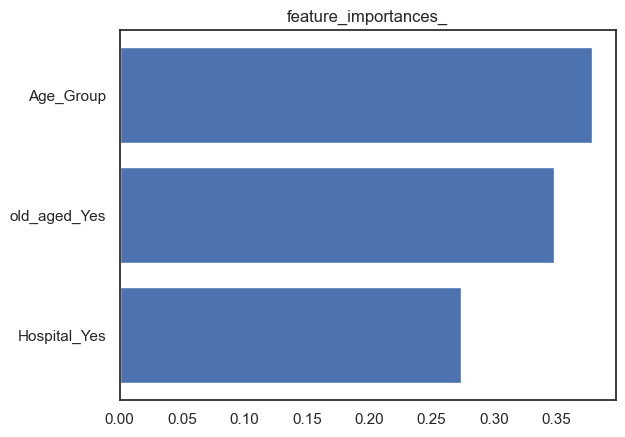

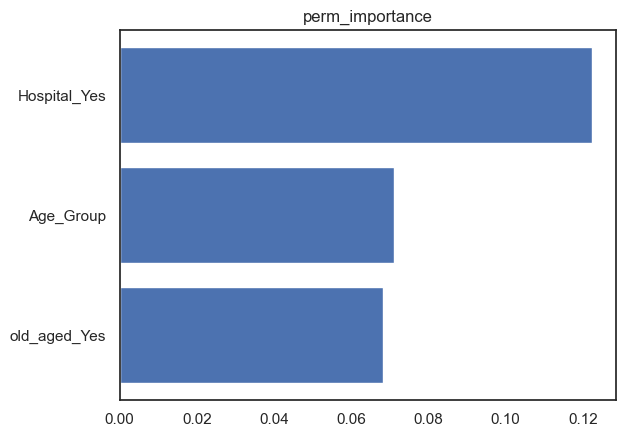

In [1799]:
get_importances(rfc_final_model, X_resampled, y_resampled)

In [1800]:
# run the cross val report using the same hyper parameters
report_summary(cross_val_report(RandomForestClassifier, X_resampled, y_resampled, cv=10, split_type="random", n_estimators= 800, min_samples_split= 2, min_samples_leaf= 1, max_features= "auto", max_depth= 100, bootstrap= False))

accuracy     0.911422
precision    0.873626
recall       0.962204
f1           0.915776
Name: mean, dtype: float64

We see very high values of precision, recall and f1 on this model. It is difficult to compare the results here with our reports throughout the notebook because the over/under sampled data has much more death=Yes values which would make precision, recall and f1 much more likely to be high.

# (5.3) Test on the new Dataset

Take your best model trained and selected based on past data (ie your cleaned Homework1 dataset), and evaluate it on the new test dataset provided with this homework (in this I have chosen to use Nick's raw dataset and clean it). <br> Discuss your findings. <br>
For the new datase, we have created a small data pipeline which follows all of the cleaning steps needed to get it to the state of the final chosen feature set above.

In [1801]:
def final_pipeline(new_df):
    """
    Process a new dataset for predictions
    """
    # Replace "Missing" values with "Unknown"
    new_df = new_df.replace("Missing", "Unknown")

    # Add old_aged feature
    def old_aged(s):
        if s["Age_Group"] == "65+ years":
            return "Yes"
        else:
            return "No"

    new_df['old_aged'] = new_df.apply(old_aged, axis=1)

    # Convert the Age_Group to numerical values
    age_dict = {
        '0 - 17 years': 1,
        '18 to 49 years': 2,
        '50 to 64 years': 3,
        '65+ years': 4
    }
    new_df.Age_Group = new_df.Age_Group.replace(age_dict)

    # Convert Death to numerical values
    try:
        new_df['Death'] = new_df['Death'].map({'Yes': 1, "No": 0})
        new_df['Death'] = new_df['Death'].astype('int64')
    except:
        pass

    # One-hot encode the categorical features
    new_df = pd.get_dummies(new_df, columns=['old_aged', 'Hospital'], drop_first=True)

    # Select only the relevant columns for the model
    new_df_X = new_df[['Age_Group', 'old_aged_Yes', 'Hospital_Yes']]
    
    # Convert non-numeric values to NaN
    new_df_X = new_df_X.apply(pd.to_numeric, errors='coerce')
    
    # Use SimpleImputer to fill missing values with the median value
    imputer = SimpleImputer(strategy='median')
    new_df_X = imputer.fit_transform(new_df_X)

    new_df_y = new_df["Death"]

    return new_df_X, new_df_y

In [1802]:
df1

Case_Month Res_State  State_Fips_Code Res_County       Age_Group   
0        January        FL             12.0      DUVAL       65+ years  \
1        January        PA             42.0       YORK       65+ years   
2       December        OH             39.0      ALLEN       65+ years   
3          April        NY             36.0     QUEENS       65+ years   
4       November        IL             17.0   TAZEWELL       65+ years   
...          ...       ...              ...        ...             ...   
19995   December        IN             18.0   HAMILTON  18 to 49 years   
19996  September        KY             21.0     SHELBY  18 to 49 years   
19997       June        TX             48.0       BELL  50 to 64 years   
19998    January        KS             20.0        NaN       65+ years   
19999        May        MD             24.0    CARROLL    0 - 17 years   

          Sex     Race            Ethnicity             Current_Status   
0      Female    White  Non-Hispanic/Latino  Laboratory-confirmed case  \
1        Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
2        Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
3        Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
4        Male    White  Non-Hispanic/Latino  Laboratory-confirmed case   
...       ...      ...                  ...                        ...   
19995  Female    White  Non-Hispanic/Latino  Laboratory-confirmed case   
19996    Male    White  Non-Hispanic/Latino              Probable Case   
19997  Female      NaN                  NaN  Laboratory-confirmed case   
19998  Female    White  Non-Hispanic/Latino  Laboratory-confirmed case   
19999  Female  Missing              Missing  Laboratory-confirmed case   

      Symptom_Status Hospital      ICU Death Underlying_Conditions at_risk   
0            Missing  Missing  Missing   Yes                   NaN      No  \
1        Symptomatic  Unknown  Unknown   Yes                   NaN      No   
2        Symptomatic       No  Missing   Yes                   Yes     Yes   
3            Unknown      Yes  Unknown   Yes                   Yes     Yes   
4            Missing  Missing  Missing   Yes                   NaN      No   
...              ...      ...      ...   ...                   ...     ...   
19995        Missing       No  Missing    No                   NaN      No   
19996    Symptomatic       No  Missing    No                   Yes      No   
19997        Missing       No  Missing    No                   NaN      No   
19998    Symptomatic       No  Missing    No                   NaN      No   
19999        Missing       No  Missing    No                   NaN      No   

      old_aged  Season  case_per_month  case_per_season  
0          Yes  Winter            4033             8020  
1          Yes  Winter            4033             8020  
2          Yes  Winter            3070             8020  
3          Yes  Spring            1414             3428  
4          Yes    Fall            2083             4739  
...        ...     ...             ...              ...  
19995       No  Winter            3070             8020  
19996       No    Fall            1331             4739  
19997       No  Summer             823             3813  
19998      Yes  Winter            4033             8020  
19999       No  Spring            1144             3428  

[20000 rows x 19 columns]

In [1803]:
new_df_X, new_df_y = final_pipeline(df1)

In [1804]:
X_highCorr_features.columns

Index(['Age_Group', 'old_aged_Yes', 'Hospital_Yes'], dtype='object')

In [1805]:
final_prediction = rfc_final_model.predict(new_df_X)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


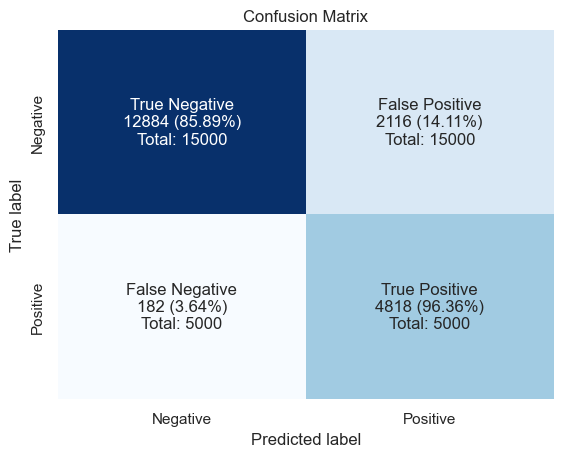

In [1806]:
# Calculate the confusion matrix and store it in the variable cm
cm = confusion_matrix(new_df_y, final_prediction)

# Calculate the percentages
percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
percentages = np.round(percentages * 100, 2)

# Calculate the total number of samples for each class
totals = cm.sum(axis=1)

# Define class labels and headings for each cell
class_labels = ['Negative', 'Positive']
cell_headings = [['True Negative', 'False Positive'],
                 ['False Negative', 'True Positive']]

# Create custom annotation format
annot = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f'{cell_headings[i][j]}\n{cm[i, j]} ({percentages[i, j]}%)\nTotal: {totals[i]}'

# Plot the heatmap
sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, cbar=False)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

In [1807]:
printMetrics(new_df_y, final_prediction)

====================  Data =======================
Accuracy:  0.8851
Confusion matrix: 
 [[12884  2116]
 [  182  4818]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      0.86      0.92     15000
           1       0.69      0.96      0.81      5000

    accuracy                           0.89     20000
   macro avg       0.84      0.91      0.86     20000
weighted avg       0.91      0.89      0.89     20000




Our final predictions are reasonable although they are not quite as good as our original predictions from the RandomForest model using the original data and without resampling and hyperparameter optimisation. The precision and f1-score are significantly lower with precision (0.69 vs 0.97) and f1-score (0.81 vs 0.97)

This was to be expected though:
* New data: While cross validation was used to ensure proper evaluation of the model's metrics above, when introducing a completely new dataset we would expect there to be some variation between it and the old data we had trained the model on. While I have not taken a look at the underlying statistics of this model, the proportion of deaths in this model is about half that in the original data - meaning the underlying data will differ.

# (6) Conclusion

### (6.1) Further Work

---------------------------------------------------------------------------------------------------------------

1. I could have better used both the ROC and AUC curves for model evaluation:
* While I plotted the ROC curves for each of the original models the focus of my analysis was on the evaluation metrics (accuracy, precision, recall & f1 score) along with the confusion matrix analysis
2. Other models:
* In part 5, we saw that some models (namely GradientBoosting and AdaBoost) performed well at predictions on this dataset.
* My focus throughout the final section was on optimising the Random Forest, although there may be potential to use the otehr models rather than the Random Forest here.
3. Automatically Updating the Model:
* A clear limitation we discussed above was that the model is limited to not using the time based features as they differ year to year
* If this model was setup to automatically updated as new data came in we would be able to effectively predict while keeping the time based features
* This would be preferable because the time based features had a clear positive impact on prediction throughout the dataset.

### (6.2) Summary

---------------------------------------------------------------------------------------------------------------

* In this notebook, we assessed three predictive models, each demonstrating similar accuracy levels but distinct recall, precision, and F1 scores. The dataset's majority of features were found to negatively impact the models' predictive metrics. Only a few critical features were employed in the final model, providing adequate accuracy.

* Several optimizations were implemented that enhanced all models: Randomized Search for identifying optimal hyperparameters and data resampling to address the imbalance issue. Although the linear regression model showed marginally better accuracy and recall, it is not recommended due to the potential for skewed results caused by valid outliers and a relatively low overall F1 score.

* The linear regression model offered improved precision compared to the logistic regression model. This model's F1 score showed an improvement over logistic regression. Out of the three models, Random Forests performed the best overall. This model achieved the highest F1 score, and by optimizing and resampling, we were able to develop an effective final model for prediction.

### (6.3) Recommendations

---------------------------------------------------------------------------------------------------------------

1. Assess the models further using ROC and AUC curves for a comprehensive evaluation
2. Conduct a detailed examination of the additional sklearn models explored in part 5
3. Train the models using the complete dataset and incorporate external features for better performance
4. Develop a self-updating model, potentially hosted on a platform like AWS or Heroku, which delivers updated predictions and continuously updates the model used for generating these predictions.